# Analytics - Product Quality

#### Date: 2023/06

#### SUMMARY:

- This notebook represents the project quality analysis of the date exposed right above. 

### TEAM:

##### Semester: 2023/01
##### Professor: Hilmer Neri

##### Members:

- Ana Carolina Rodrigues Leite
- Ariel Vieira Lima Serafim
- Caio César Oliveira
- Ian Pereira de Sousa Rocha
- João Victor Max Bisinotti de Oliveira
- Lameque Fernandes Azevedo
- Levi Lunique Izidio da Silva
- Luana de Lima Medeiros
- Lucas Freire Lopes
- Lucas Gomes Lopes
- Murilo Schiler Lopes Santana
- Renata Quadros Kurzawa
- Vinicius Angelo de Brito Vieira
- Vitor Eduardo Kühl Rodrigues


### LIBRARIES

In [34]:
# Deal with data
import pandas as pd
import json
from glob import glob
import os

# Deal with visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Deal with type hints
from typing import List

# Deal with time
import datetime

### GRAPH SETTINGS

In [35]:
%config InlineBackend.figure_format ='retina'
sns.set(font_scale=1.5)
sns.set_style('darkgrid',
              {'xtick.bottom' : True,
               'ytick.left': True,
               'grid.linestyle':'--',
               'font.monospace': ['Computer Modern Typewriter'],
               'axes.edgecolor' : 'white'})

### DATAFRAME SETTINGS

In [36]:
pd.set_option("display.max_rows", None, "display.max_columns", None)

#### Replace your semester, project name, repository name, and the programming language extension

In [37]:
# Set your repo major name here
# Example: fga-eps-mds-2022-2-MeasureSoftGram-
repo_name = 'fga-eps-mds-2023-2-MeasureSoftGram-'

# Add your repos here
# Example: 'Front': 'py',
repos_language = {
    'Service': 'py',
    'CLI': 'py',
    'Front': 'ts',
    'Core': 'py',
    'Action': 'ts',
    'Parser': 'py'
}

### SonarCloud
##### Path to the folder with all your jsons

In [38]:
# Maybe you should change this path to your own path
import os
import re

sonar_files = glob('./analytics-raw-data/*.json')
#sonar_files = [file for file in sonar_files if "Helper-Action" not in file and "/test.json" not in file]

for file in sonar_files:
    wrong_date = re.findall(r"[a-z]-(\d+-\d+-\d+-\d+-\d+)-[a-z]", file)
    if len(wrong_date) > 0:
        print(re.sub(r"(\d+-\d+-\d+-\d+-\d+)", wrong_date[0][3:5] + wrong_date[0][2:3] + wrong_date[0][:2] + wrong_date[0][5:] + "-01", file))
        os.rename(file, re.sub(r"(\d+-\d+-\d+-\d+-\d+)", wrong_date[0][3:5] + wrong_date[0][2:3] + wrong_date[0][:2] + wrong_date[0][5:] + "-01", file))

sonar_files = glob('./analytics-raw-data/*.json')
#sonar_files = [file for file in sonar_files if "Helper-Action" not in file and "/test.json" not in file]

## Create DataFrame

#### Unmarshall json

In [39]:
def unmarshall(json_path: str) -> dict:
    with open(json_path) as json_file:
        json_obj = json.load(json_file)
    return json_obj

#### Create a list with all valid columns

In [40]:
metric_list = ['files',
               'functions',
               'complexity',
               'comment_lines_density',
               'duplicated_lines_density',
               'coverage',
               'ncloc',
               'tests',
               'test_errors',
               'test_failures',
               'test_execution_time',
               'security_rating']

#### Extract files dataframe out of component dataframe

In [41]:
def get_files_df(df: pd.DataFrame) -> pd.DataFrame:

    files_df = df[df['qualifier'] == 'FIL']

    files_df = files_df.dropna(subset=['functions', 'complexity','comment_lines_density', 'duplicated_lines_density', 'coverage' ])

    return files_df

#### Extract directories dataframe out of component dataframe

In [42]:
def get_dir_df(df: pd.DataFrame) -> pd.DataFrame:
    dirs = df[df["qualifier"] == "DIR"]

    newdf = pd.to_numeric(dirs["tests"])

    max_value_index = newdf.idxmax()

    return dirs.loc[max_value_index]

#### Extract uts dataframe out of component dataframe

In [43]:
def get_uts_df(df: pd.DataFrame) -> pd.DataFrame:
    uts_df = df[df['qualifier'] == 'UTS']

    uts_df = uts_df.fillna(0)

    uts_df = uts_df.dropna(subset=['test_execution_time'])

    return uts_df

#### Generate component dataframe

In [44]:
def metric_per_file(json_dict: dict) -> List[dict]:
    file_json = []

    for component in json_dict['components']:
        ncloc_value = 0
        for measure in component['measures']:
            if measure['metric'] == 'ncloc':
                ncloc_value = float(measure['value'])
                break

        if (component['qualifier'] == 'FIL' and ncloc_value > 0) \
                or component['qualifier'] == 'DIR' \
                or component['qualifier'] == 'UTS':
            file_json.append(component)

    return file_json


def generate_component_dataframe_data(
        metrics_list: List[str],
        file_component_data: List[dict],
        language_extension: str) -> pd.DataFrame:

    df_columns = metrics_list

    files_df = pd.DataFrame(columns = df_columns)
    dirs_df = pd.DataFrame(columns = df_columns)
    uts_df = pd.DataFrame(columns = df_columns)

    for file in file_component_data:
        try:
                if file['qualifier'] == 'FIL' and file['language'] == language_extension:
                    for measure in file['measures']:
                        files_df.at[file['path'], measure['metric']] = measure['value']

                    files_df['qualifier'] = file['qualifier']

                elif file['qualifier'] == 'DIR':
                    for measure in file['measures']:
                        dirs_df.at[file['path'], measure['metric']] = measure['value']

                    dirs_df['qualifier'] = file['qualifier']

                elif file['qualifier'] == 'UTS':
                    for measure in file['measures']:
                        uts_df.at[file['path'], measure['metric']] = measure['value']

                    uts_df['qualifier'] = file['qualifier']

        except:
            pass

    files_df.reset_index(inplace = True)
    dirs_df.reset_index(inplace = True)
    uts_df.reset_index(inplace = True)

    files_df = files_df.rename({'index': 'path'}, axis=1).drop(['files'], axis=1)
    dirs_df = dirs_df.rename({'index': 'path'}, axis=1).drop(['files'], axis=1)
    uts_df = uts_df.rename({'index': 'path'}, axis=1).drop(['files'], axis=1)

    df = pd.concat([files_df, dirs_df, uts_df], axis=0)

    return df


def create_component_df(json_list):
    df = pd.DataFrame()

    for json_path in json_list:
        file_component = unmarshall(json_path)
        file_component_data = metric_per_file(file_component)

        base_name = os.path.basename(json_path)

        file_component_dataframe = generate_component_dataframe_data(
            metric_list,
            file_component_data,
            language_extension = repos_language[base_name.split("-")[6]])


        file_component_dataframe['filename'] = base_name

        df = pd.concat([df, file_component_dataframe], ignore_index=True)

    aux_df = df['filename'].str.split(r"-(\d+-\d+-\d+-\d+-\d+-\d+)-(.*?).json", expand=True)
        
    df['repository'] = aux_df[0]
    df['datetime'] = aux_df[1]
    df['version'] = aux_df[2]

    df = df.sort_values(by=['repository', 'datetime'])

    return df

In [45]:
file_component_df = create_component_df(sonar_files)
file_component_df = file_component_df[~file_component_df.path.str.contains("__init__") & ~file_component_df.path.str.contains("staticfiles")]
file_component_df.repository.unique()

array(['fga-eps-mds-2023-2-MeasureSoftGram-Action',
       'fga-eps-mds-2023-2-MeasureSoftGram-CLI',
       'fga-eps-mds-2023-2-MeasureSoftGram-Core',
       'fga-eps-mds-2023-2-MeasureSoftGram-Front',
       'fga-eps-mds-2023-2-MeasureSoftGram-Parser',
       'fga-eps-mds-2023-2-MeasureSoftGram-Service'], dtype=object)

### Create dataframe per repository

In [46]:
repos_dataframes = []

for repo in repos_language.keys():
    dataframe = file_component_df[file_component_df['repository'] == repo_name+repo]
    repos_dataframes.append({'name': repo, 'df': dataframe})

## Measure calculations according to Q-Rapids quality model

In [47]:
def _ncloc(df: pd.DataFrame) -> int:
    ncloc = 0
    for each in df['ncloc']:
        # try to cast the current ncloc value to int, if the value is NaN/Null, consider it as zero.
        try:
            n = int(each)
        except ValueError:
            n = 0
        ncloc += n

    return ncloc

## Quality Aspect - Maintainability

### Factor - Code Quality

#### Complexity

In [48]:
def m1(df: pd.DataFrame):

    files_df = get_files_df(df)

    density_non_complex_files = len(files_df[(files_df['complexity'].astype(float) /
                                              files_df['functions'].astype(float)) < 10]) / len(files_df)

    return density_non_complex_files

#### Comments

In [49]:
def m2(df: pd.DataFrame):

    files_df = get_files_df(df)

    density_comment_files = len(files_df[(files_df['comment_lines_density'].astype(float) > 10) &
                                         (files_df['comment_lines_density'].astype(float) < 30)]) / len(files_df)

    return density_comment_files

#### Duplications

In [50]:
def m3(df: pd.DataFrame):

    files_df = get_files_df(df)

    duplication = len(files_df[(files_df['duplicated_lines_density'].astype(float) < 5)])/len(files_df)

    return duplication

## Quality Aspect - Reliability

### Factor - Testing Status

#### Passed tests

In [51]:
def m4(df: pd.DataFrame):

    dir_df = get_dir_df(df)

    passed_tests = (float(dir_df['tests']) - (float(dir_df['test_errors']) + float(dir_df['test_failures']))) /\
               float(dir_df['tests'])

    return passed_tests

#### Fast test builds

In [52]:
def m5(df: pd.DataFrame):
    dir_df = get_uts_df(df)

    density_fast_test_builds = len(dir_df[(dir_df['test_execution_time'].astype(float)) < 300000]) /\
                               len(dir_df['test_execution_time'].astype(float))
    return density_fast_test_builds

#### Test coverage

In [53]:
def m6(df: pd.DataFrame):

    files_df = get_files_df(df)

    density_test_coverage = len(files_df[(files_df['coverage'].astype(float) > 60)]) / len(files_df)

    return density_test_coverage

## Calculate measures for each repository

In [54]:
def create_metrics_df(df: pd.DataFrame) -> pd.DataFrame:

    date_time_vec = df['datetime'].unique()

    m1_list = []
    m2_list = []
    m3_list = []
    m4_list = []
    m5_list = []
    m6_list = []

    ncloc_list = []
    repository_list = []
    version_list = []

    for version in date_time_vec:

        version_df = df[df['datetime'] == version]

        try:
            m1_list.append(m1(version_df))
        except Exception:
            m1_list.append(0)

        try:
            m2_list.append(m2(version_df))
        except Exception:
            m2_list.append(0)

        try:
            m3_list.append(m3(version_df))
        except Exception:
            m3_list.append(0)

        try:
            m4_list.append(m4(version_df))
        except Exception:
            m4_list.append(0)

        try:
            m5_list.append(m5(version_df))
        except Exception:
            m5_list.append(0)

        try:
            m6_list.append(m6(version_df))
        except Exception:
            m6_list.append(0)

        ncloc_list.append(_ncloc(version_df))
        repository_list.append(version_df['repository'].iloc[0])
        version_list.append(version)

    final_dict = {
        'm1': m1_list,
        'm2': m2_list,
        'm3': m3_list,
        'm4': m4_list,
        'm5': m5_list,
        'm6': m6_list,
        'repository': repository_list,
        'version': version_list,
        'ncloc': ncloc_list
    }

    metrics_df = pd.DataFrame(final_dict)

    return metrics_df

In [55]:
# Here we will create a dictionary with the metrics for each repository
metrics = {}

for repo_df in repos_dataframes:
    metrics[repo_df['name']] = create_metrics_df(repo_df['df'])

/tmp/ipykernel_20219/2067229751.py:6: FutureWarning: The behavior of Series.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  max_value_index = newdf.idxmax()
/tmp/ipykernel_20219/2067229751.py:6: FutureWarning: The behavior of Series.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  max_value_index = newdf.idxmax()
/tmp/ipykernel_20219/2067229751.py:6: FutureWarning: The behavior of Series.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  max_value_index = newdf.idxmax()
/tmp/ipykernel_20219/2067229751.py:6: FutureWarning: The behavior of Series.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  max_value_index = newdf.idxmax()
/tmp/ipykernel_20219/2067229751.py:6: FutureWarning: The behavior of Series.idxmax with 

## Data visualization

In this area you will need to plot the metrics of each repository.

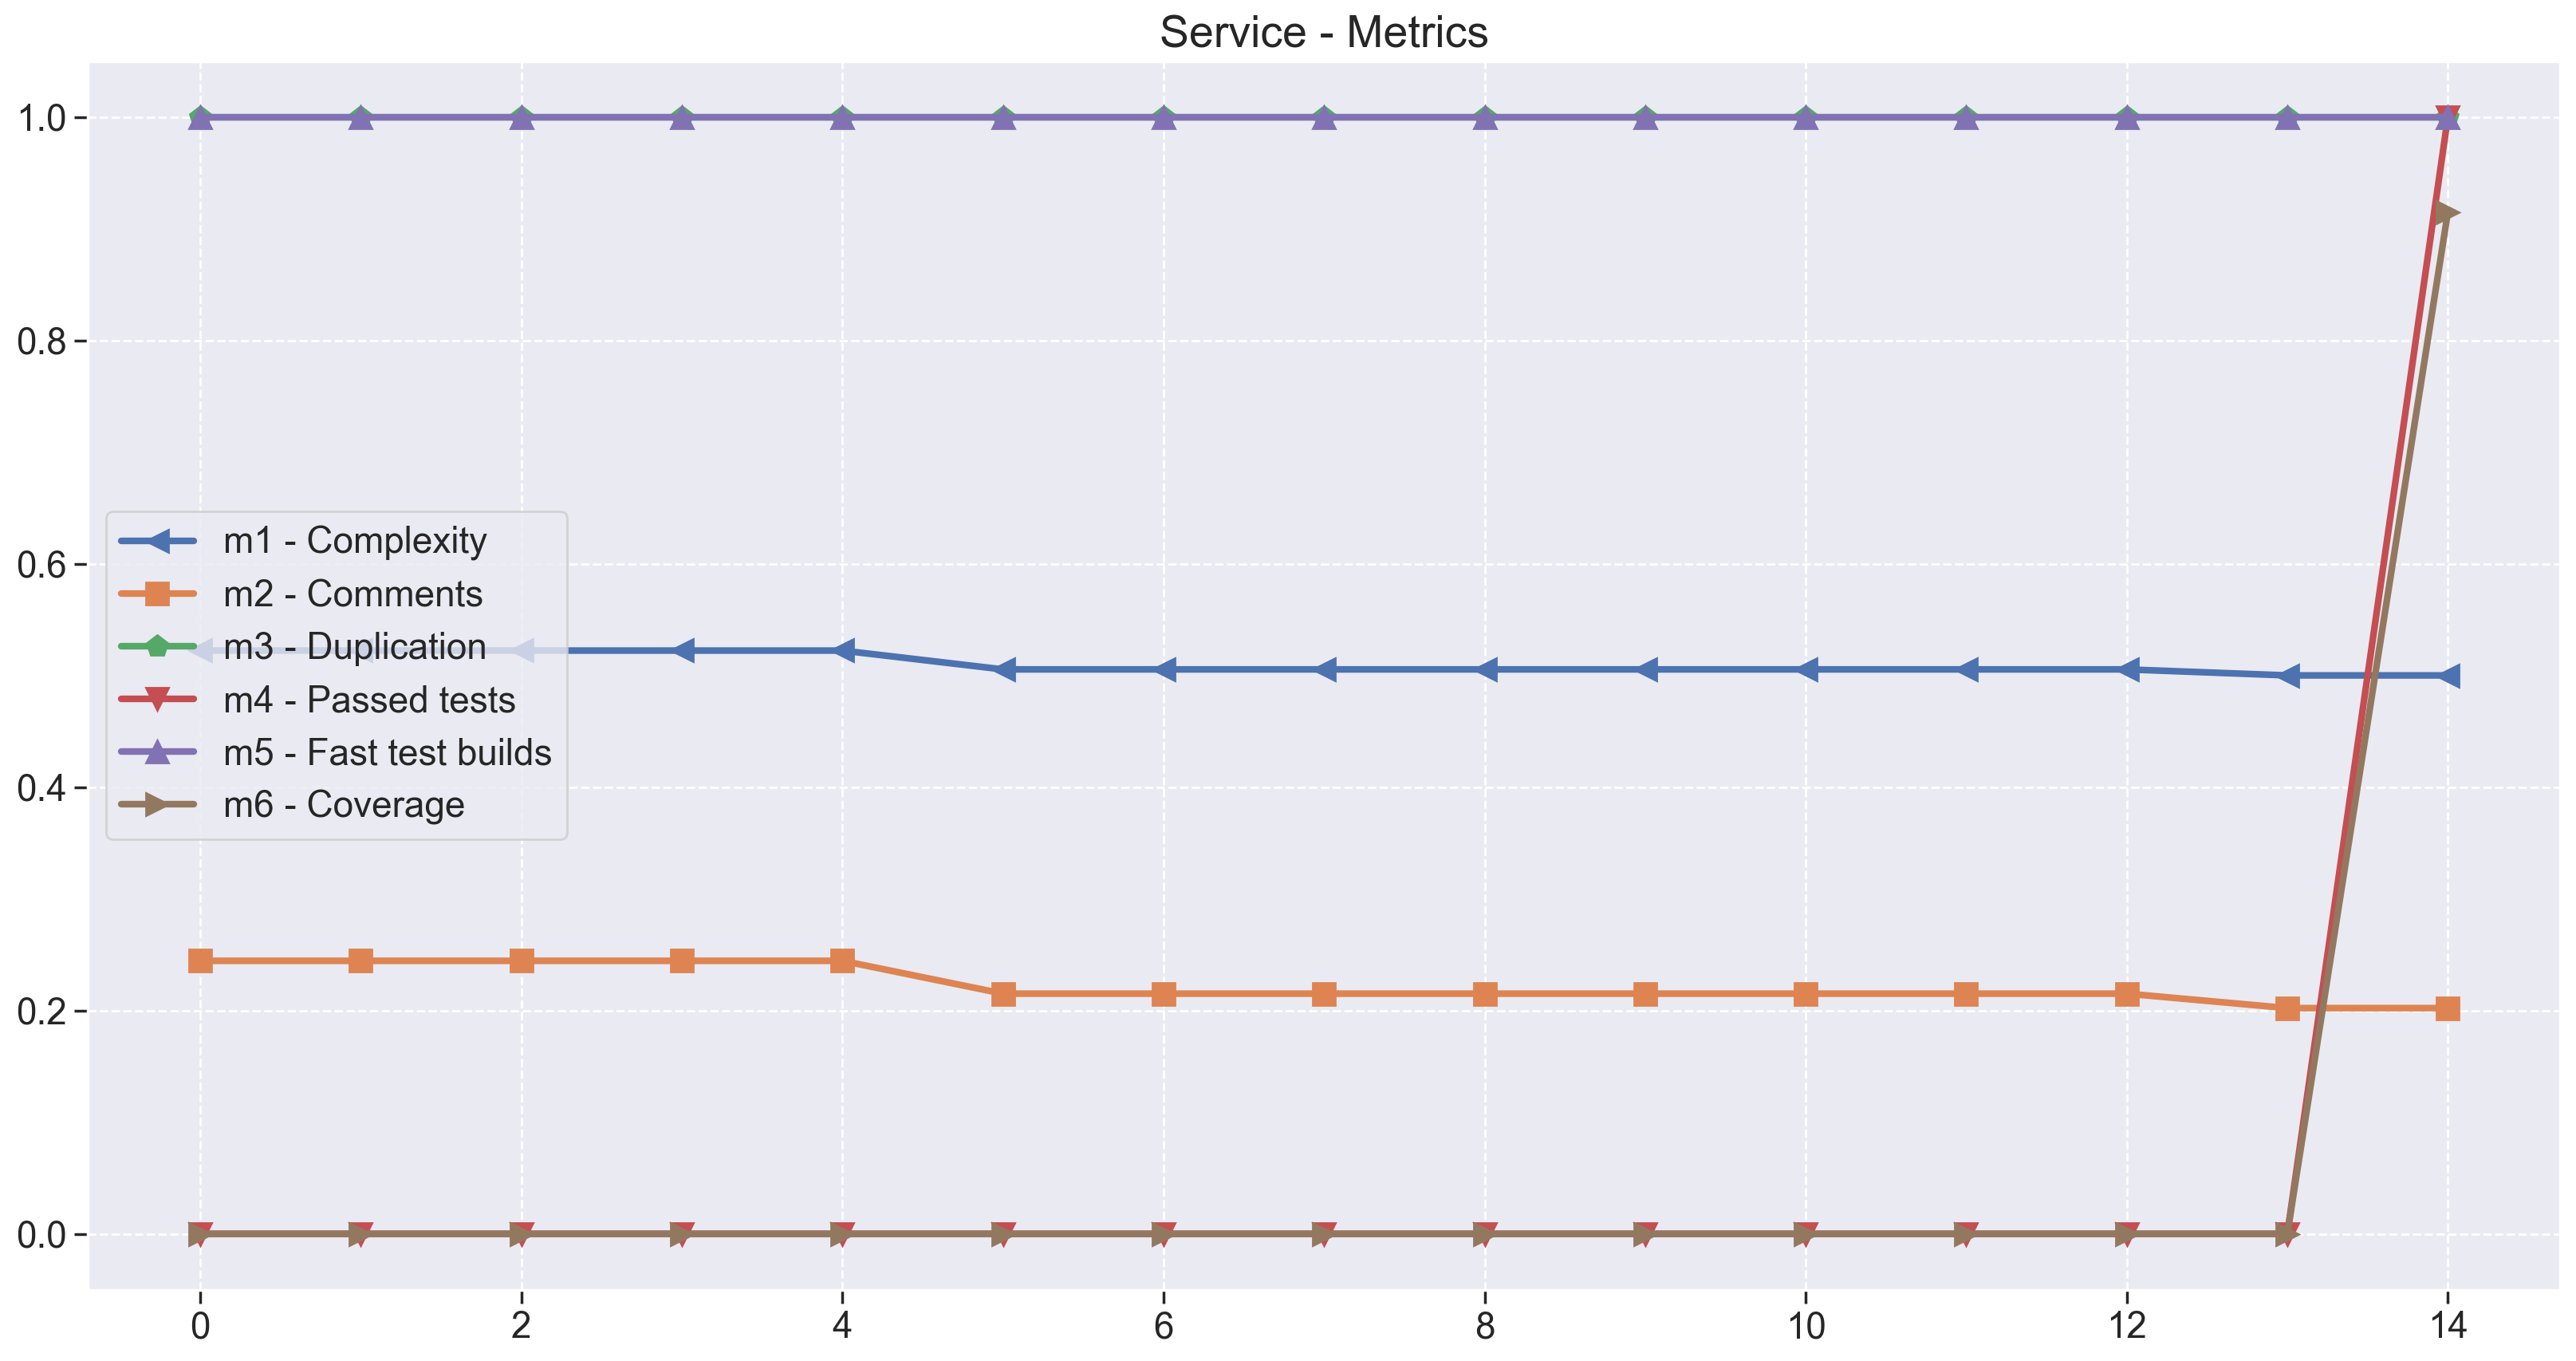

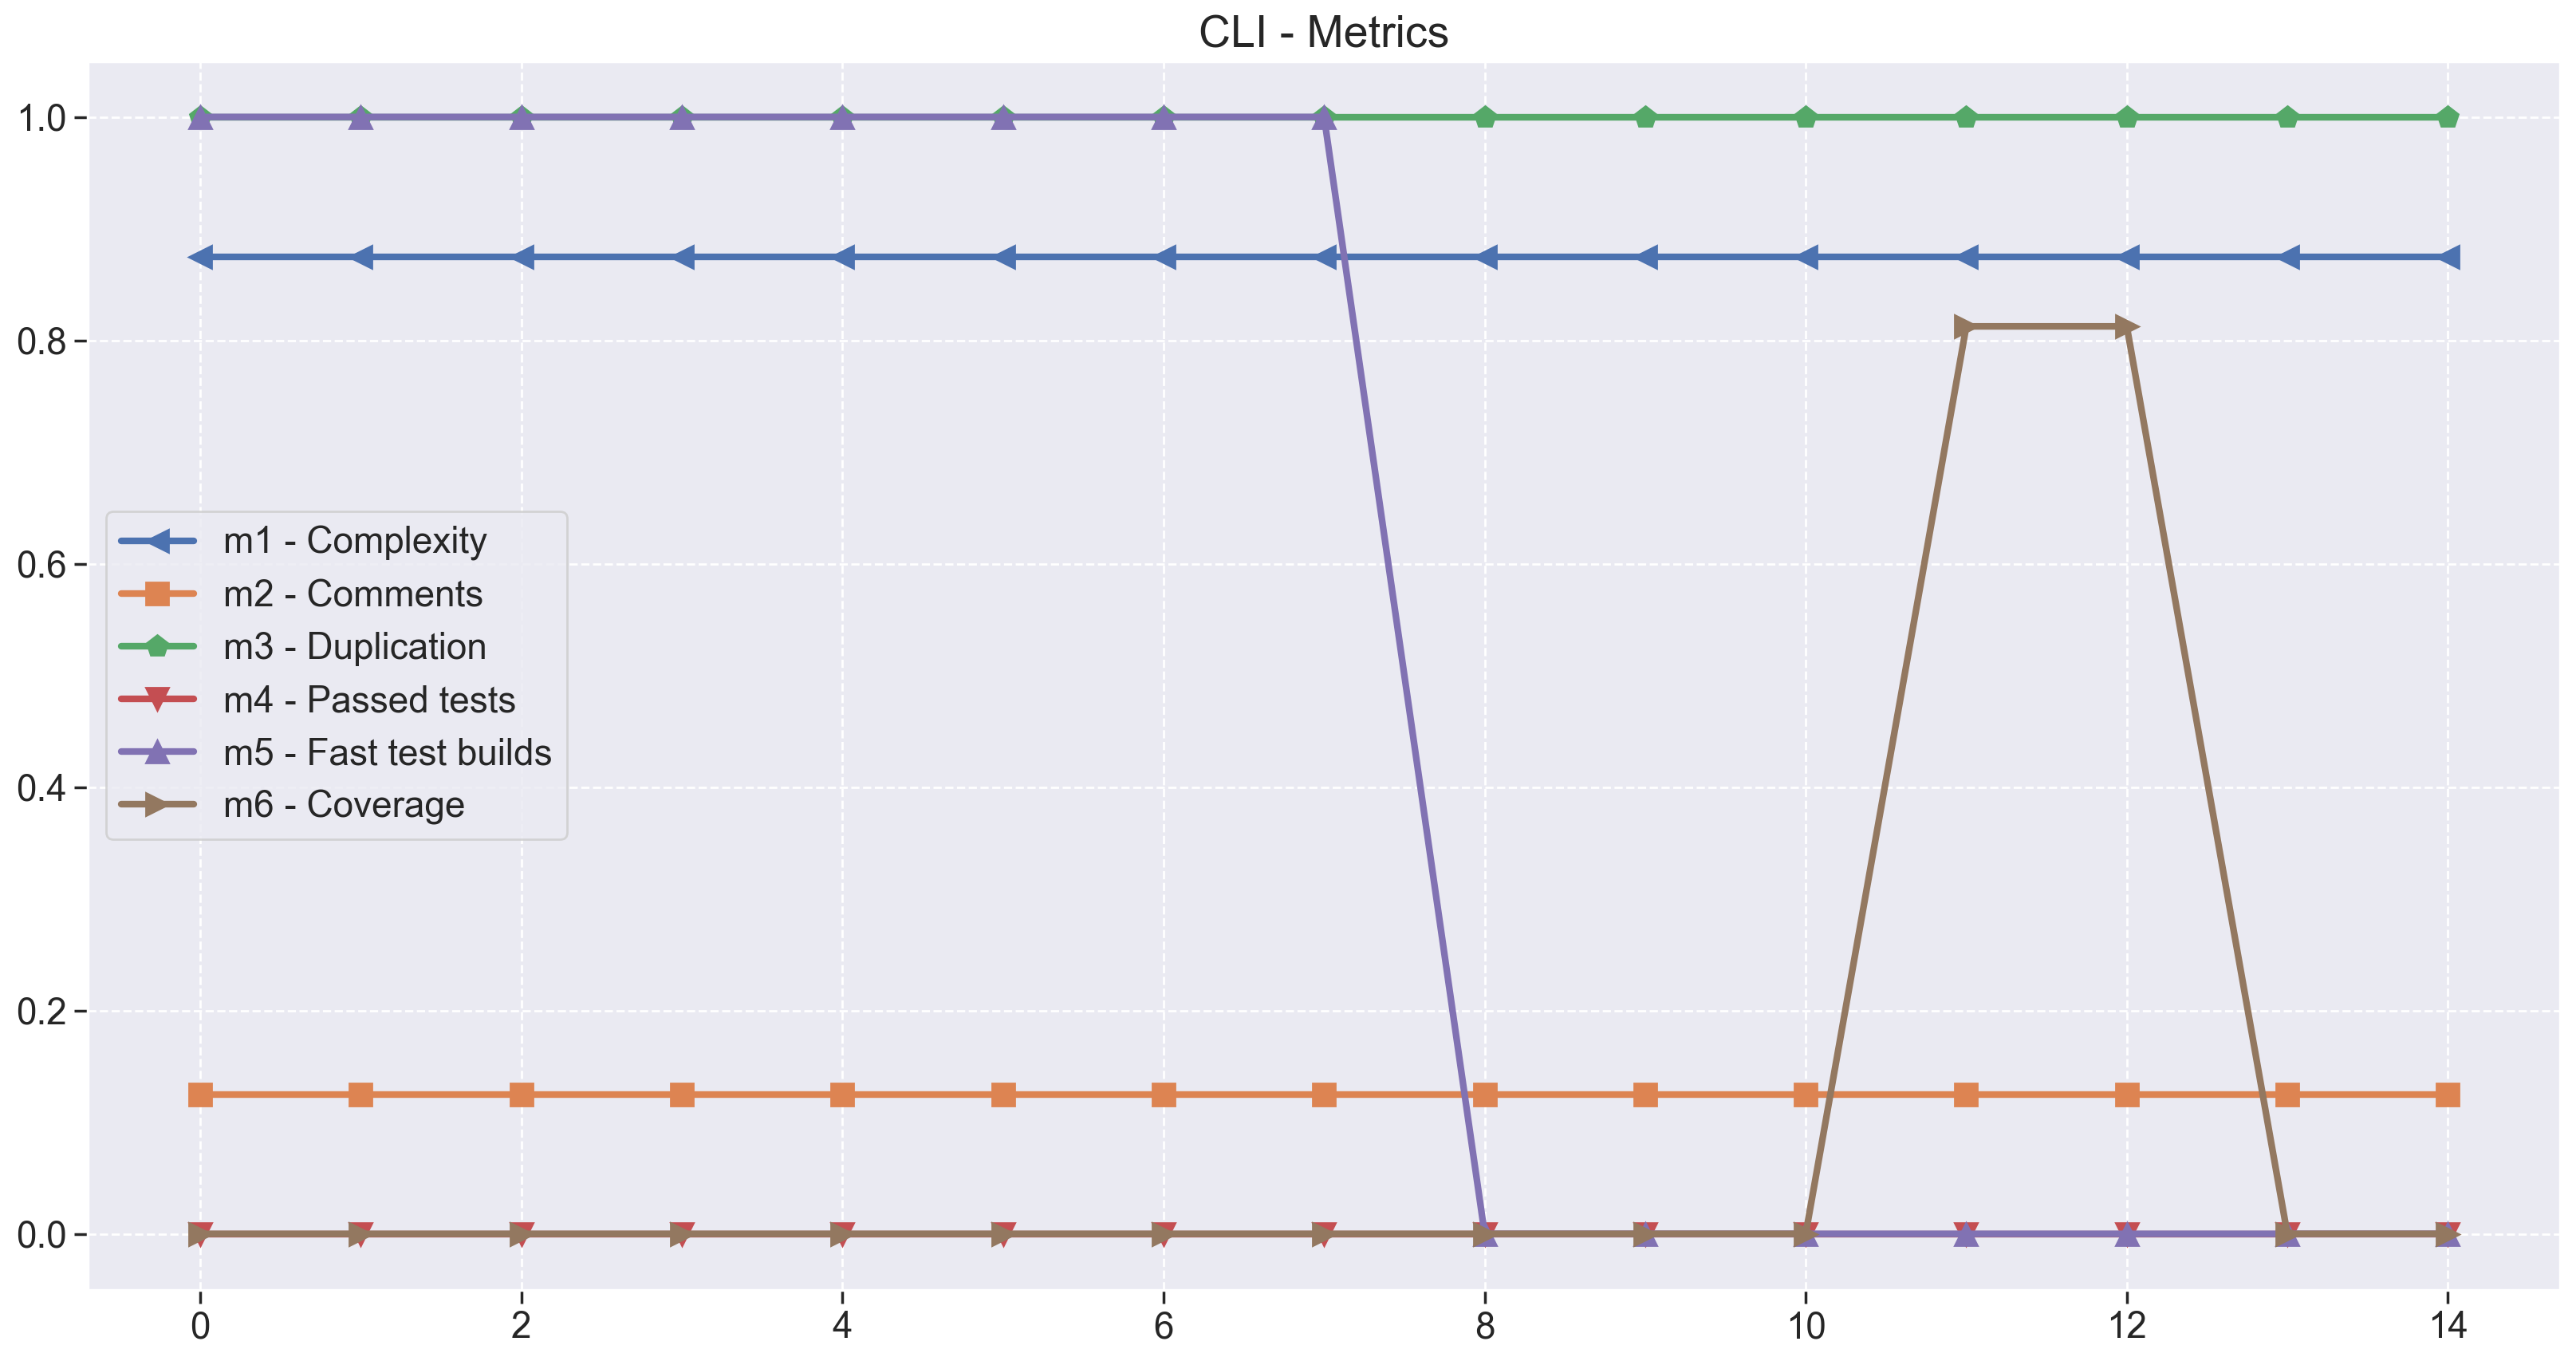

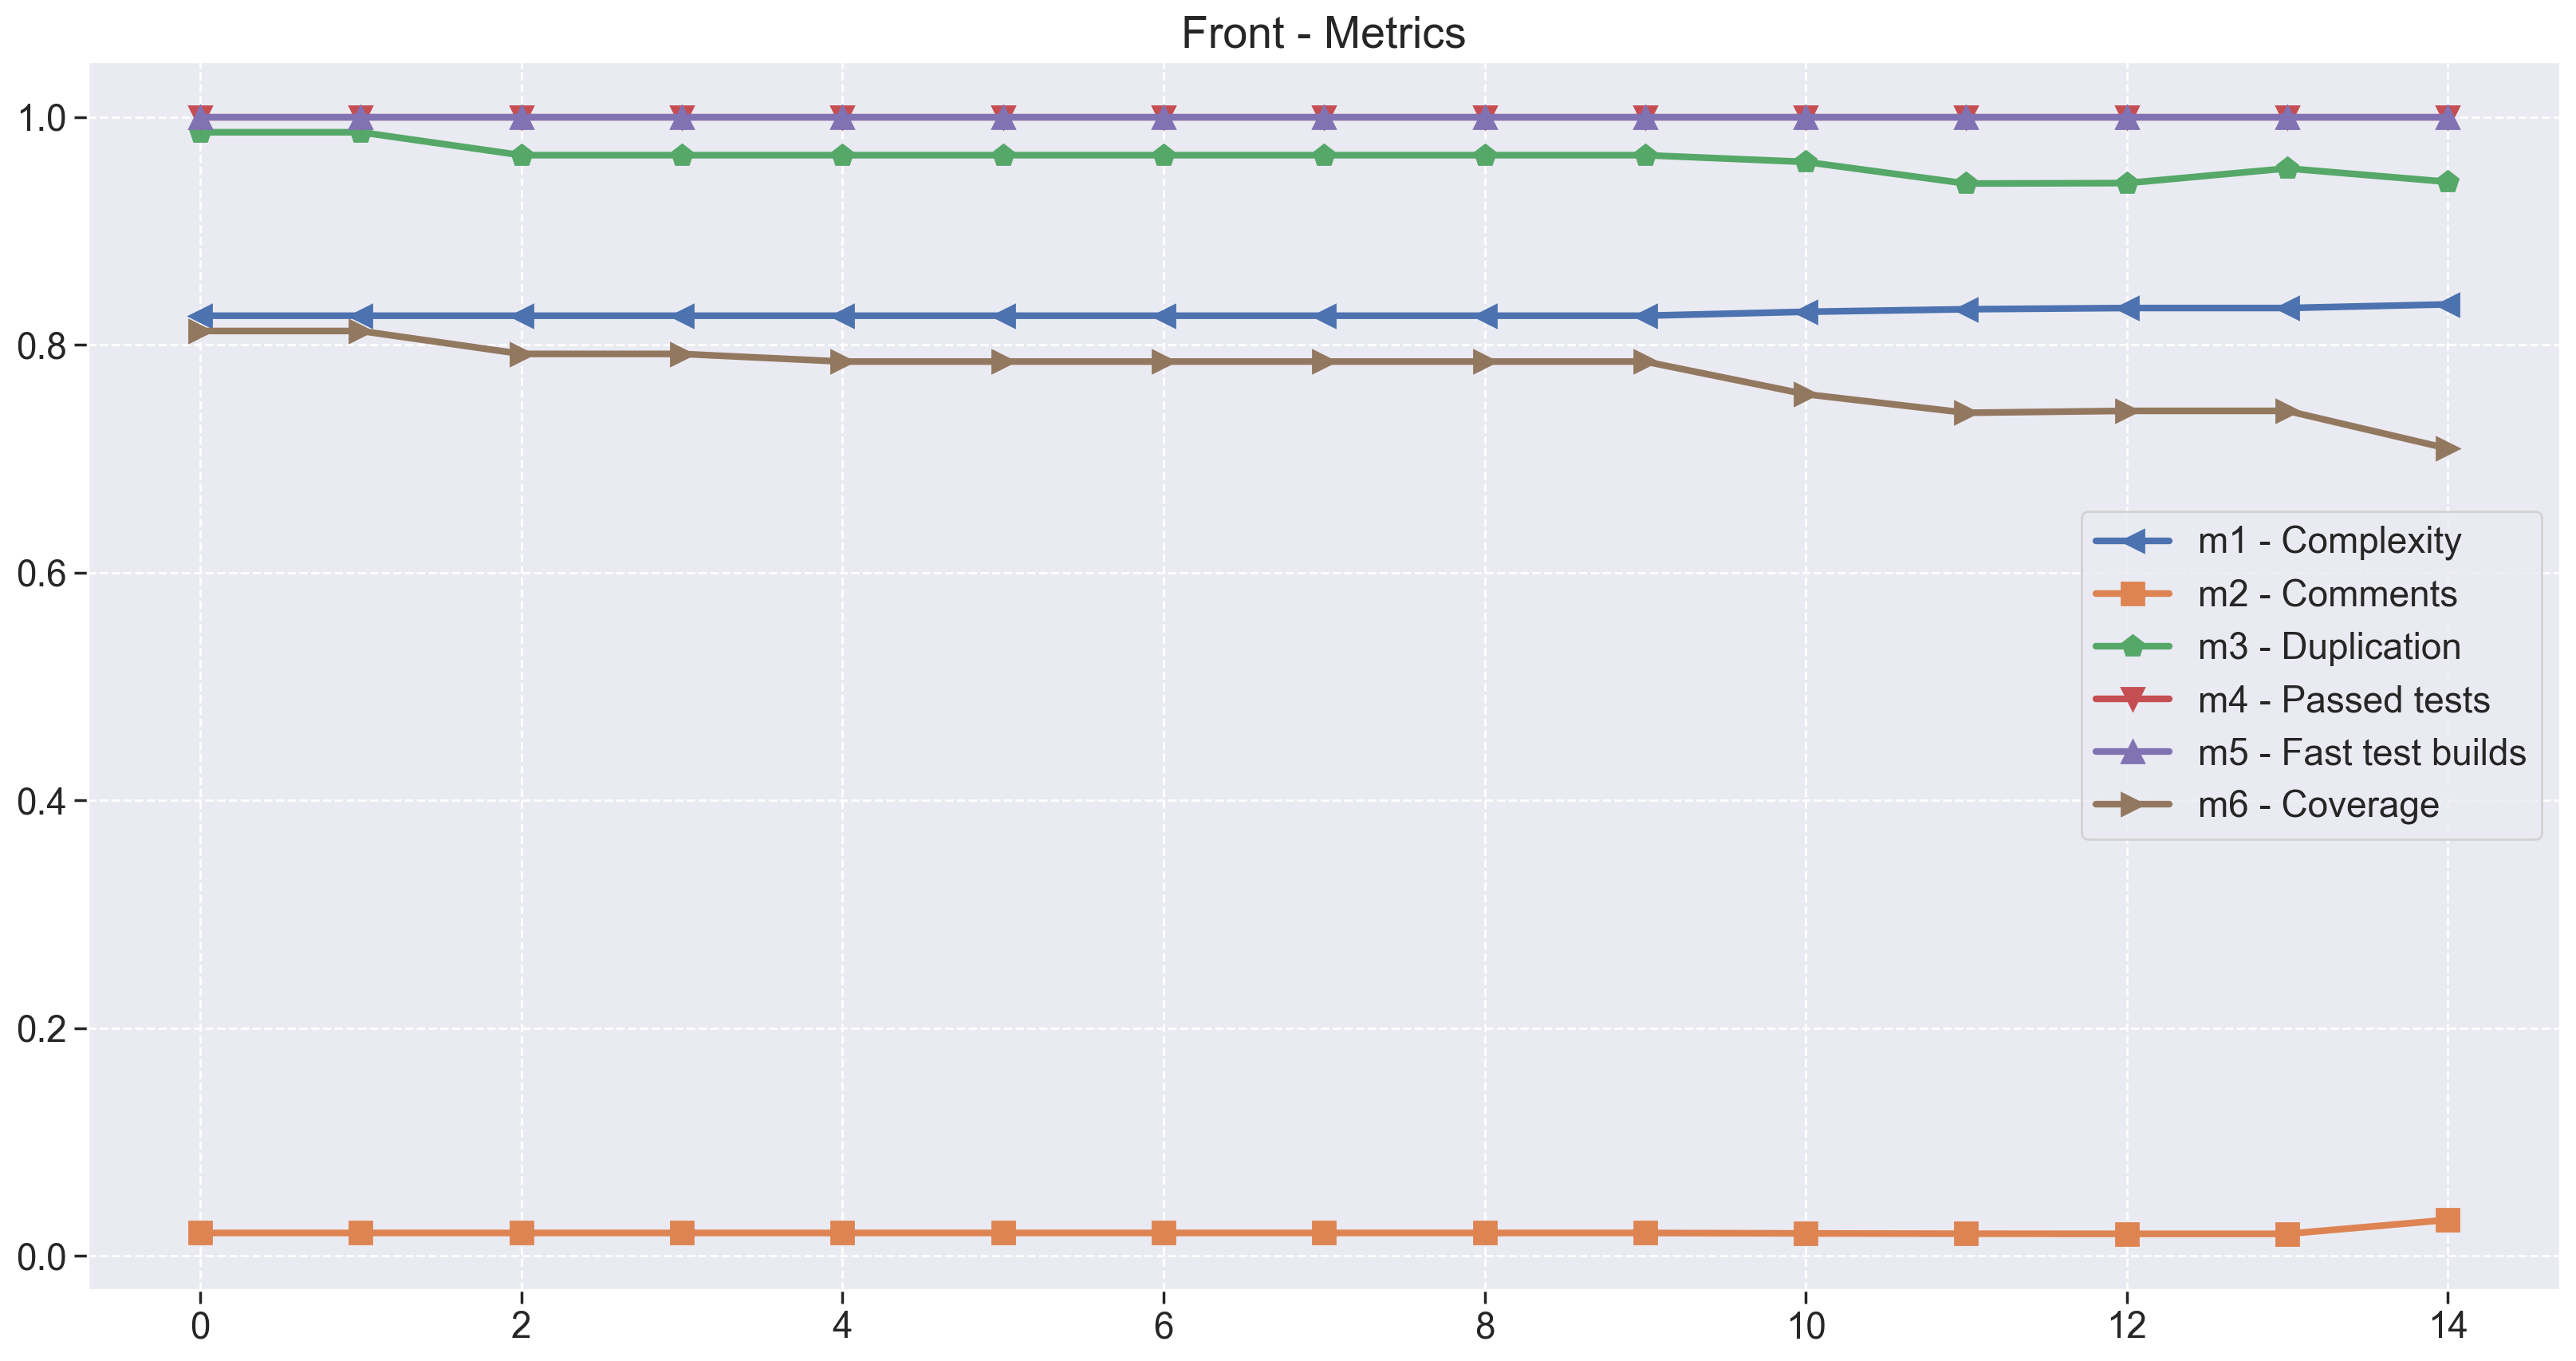

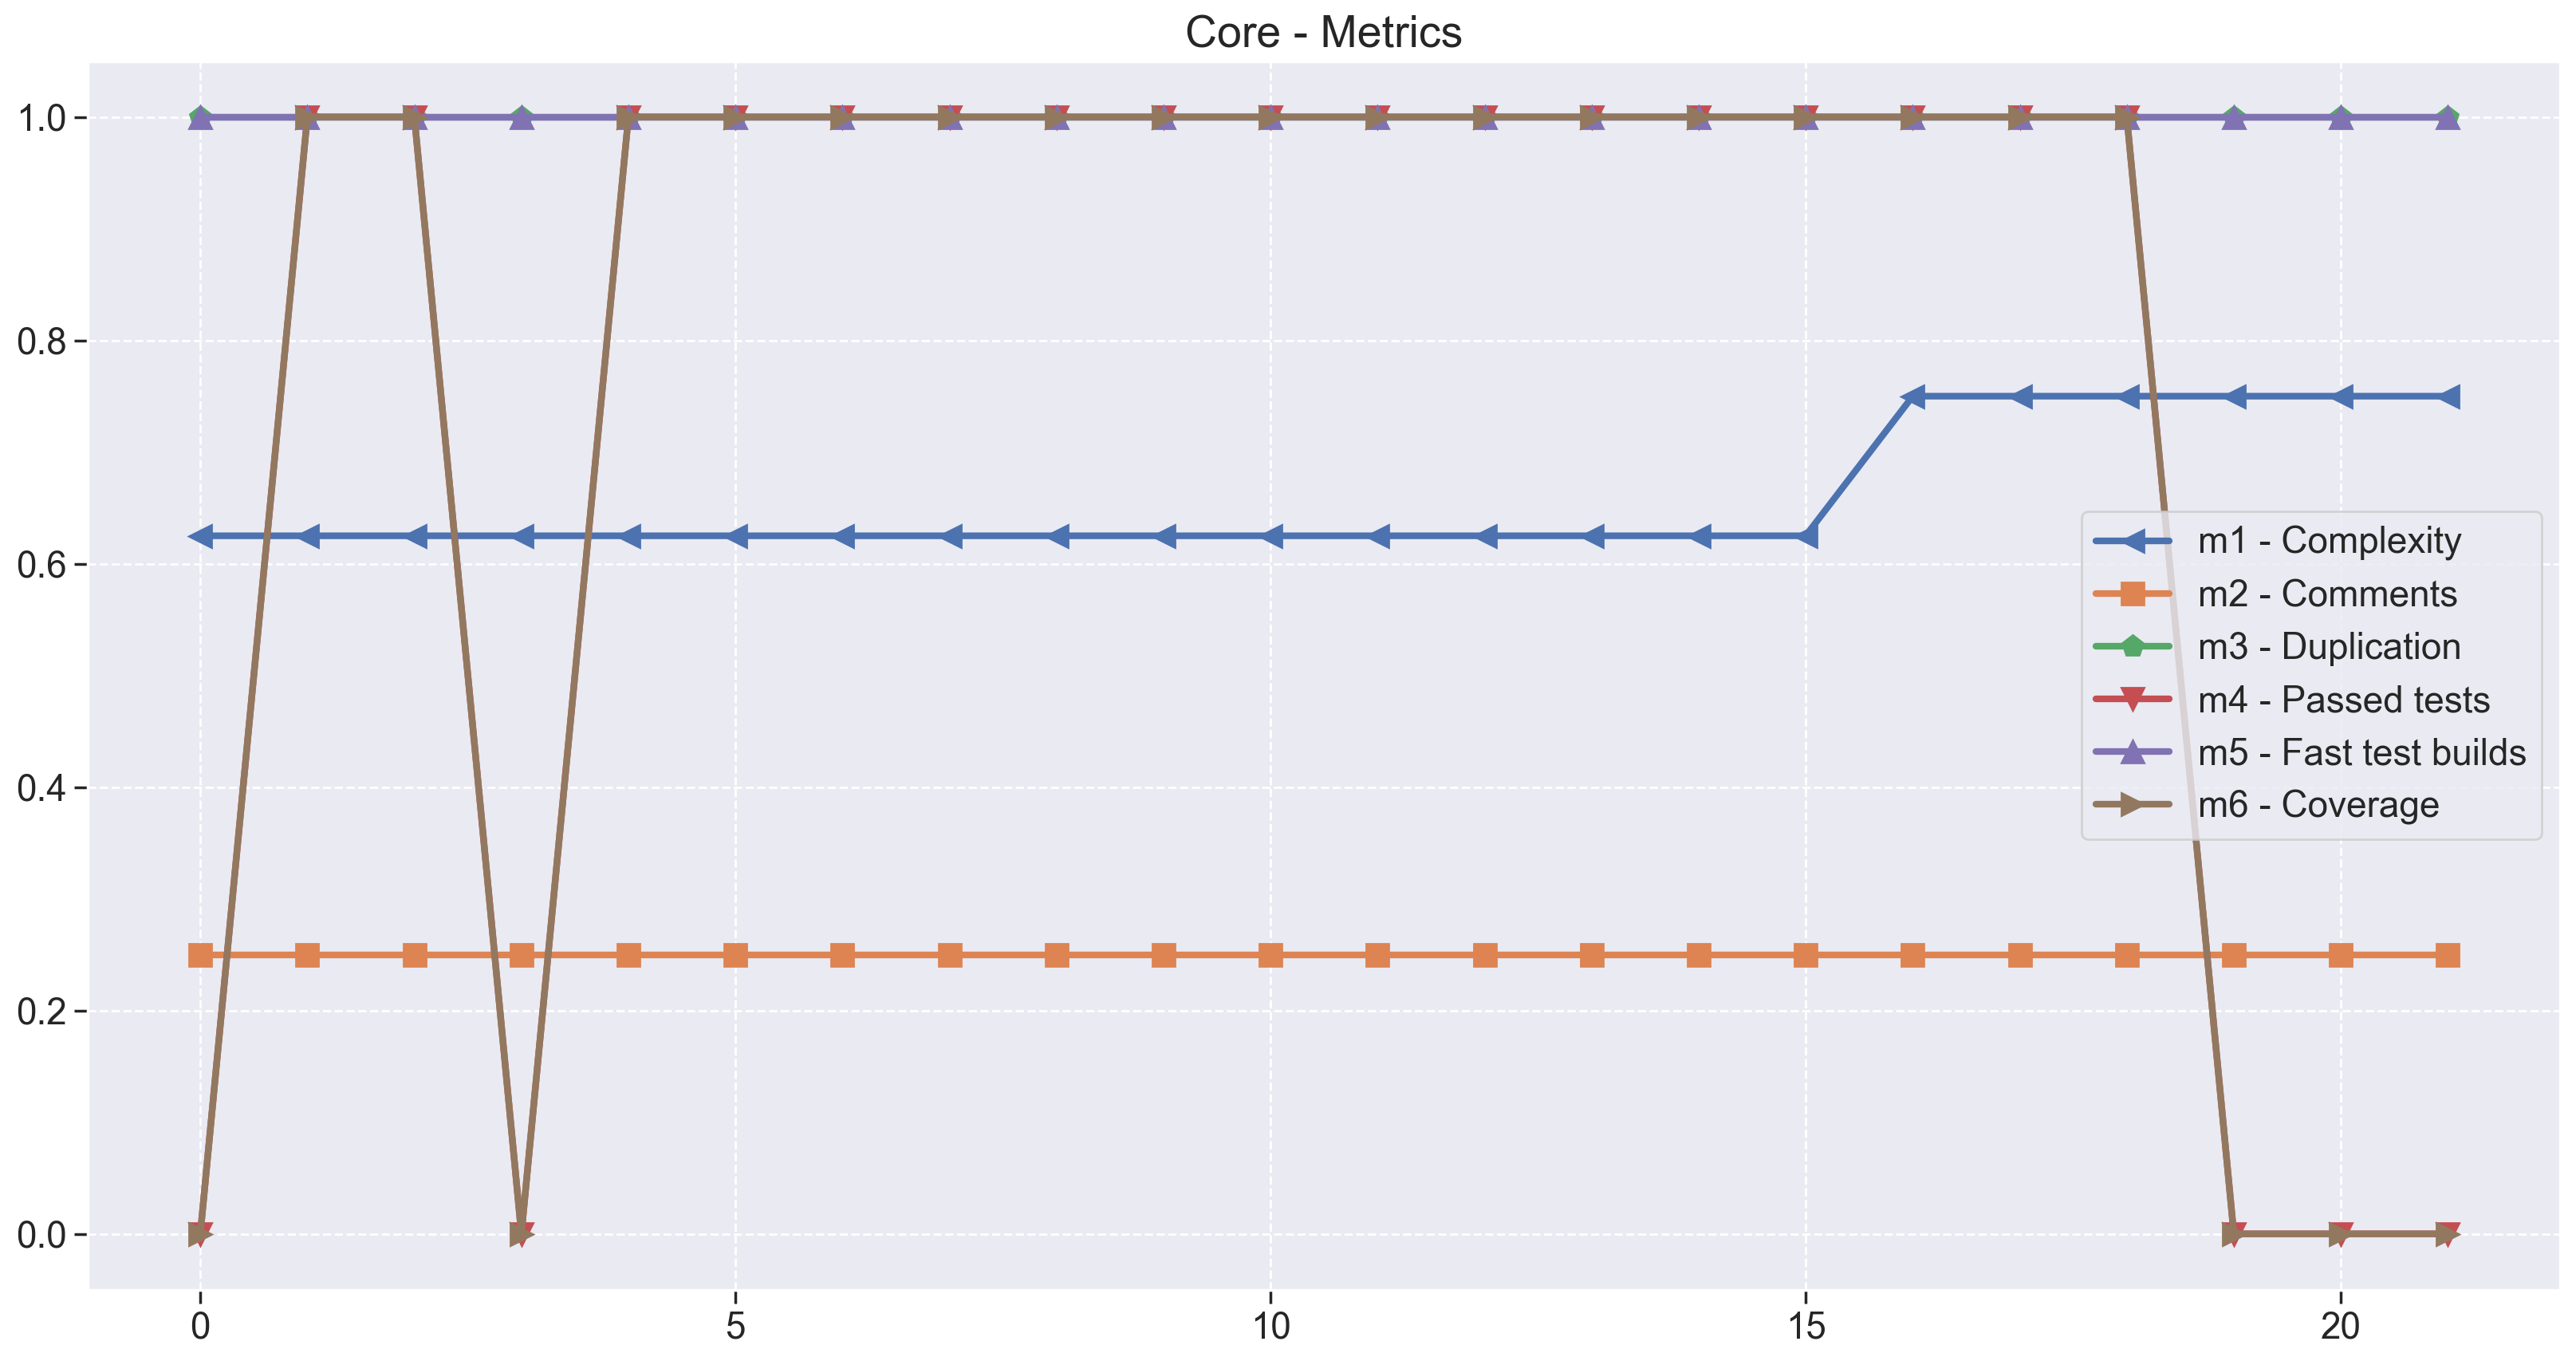

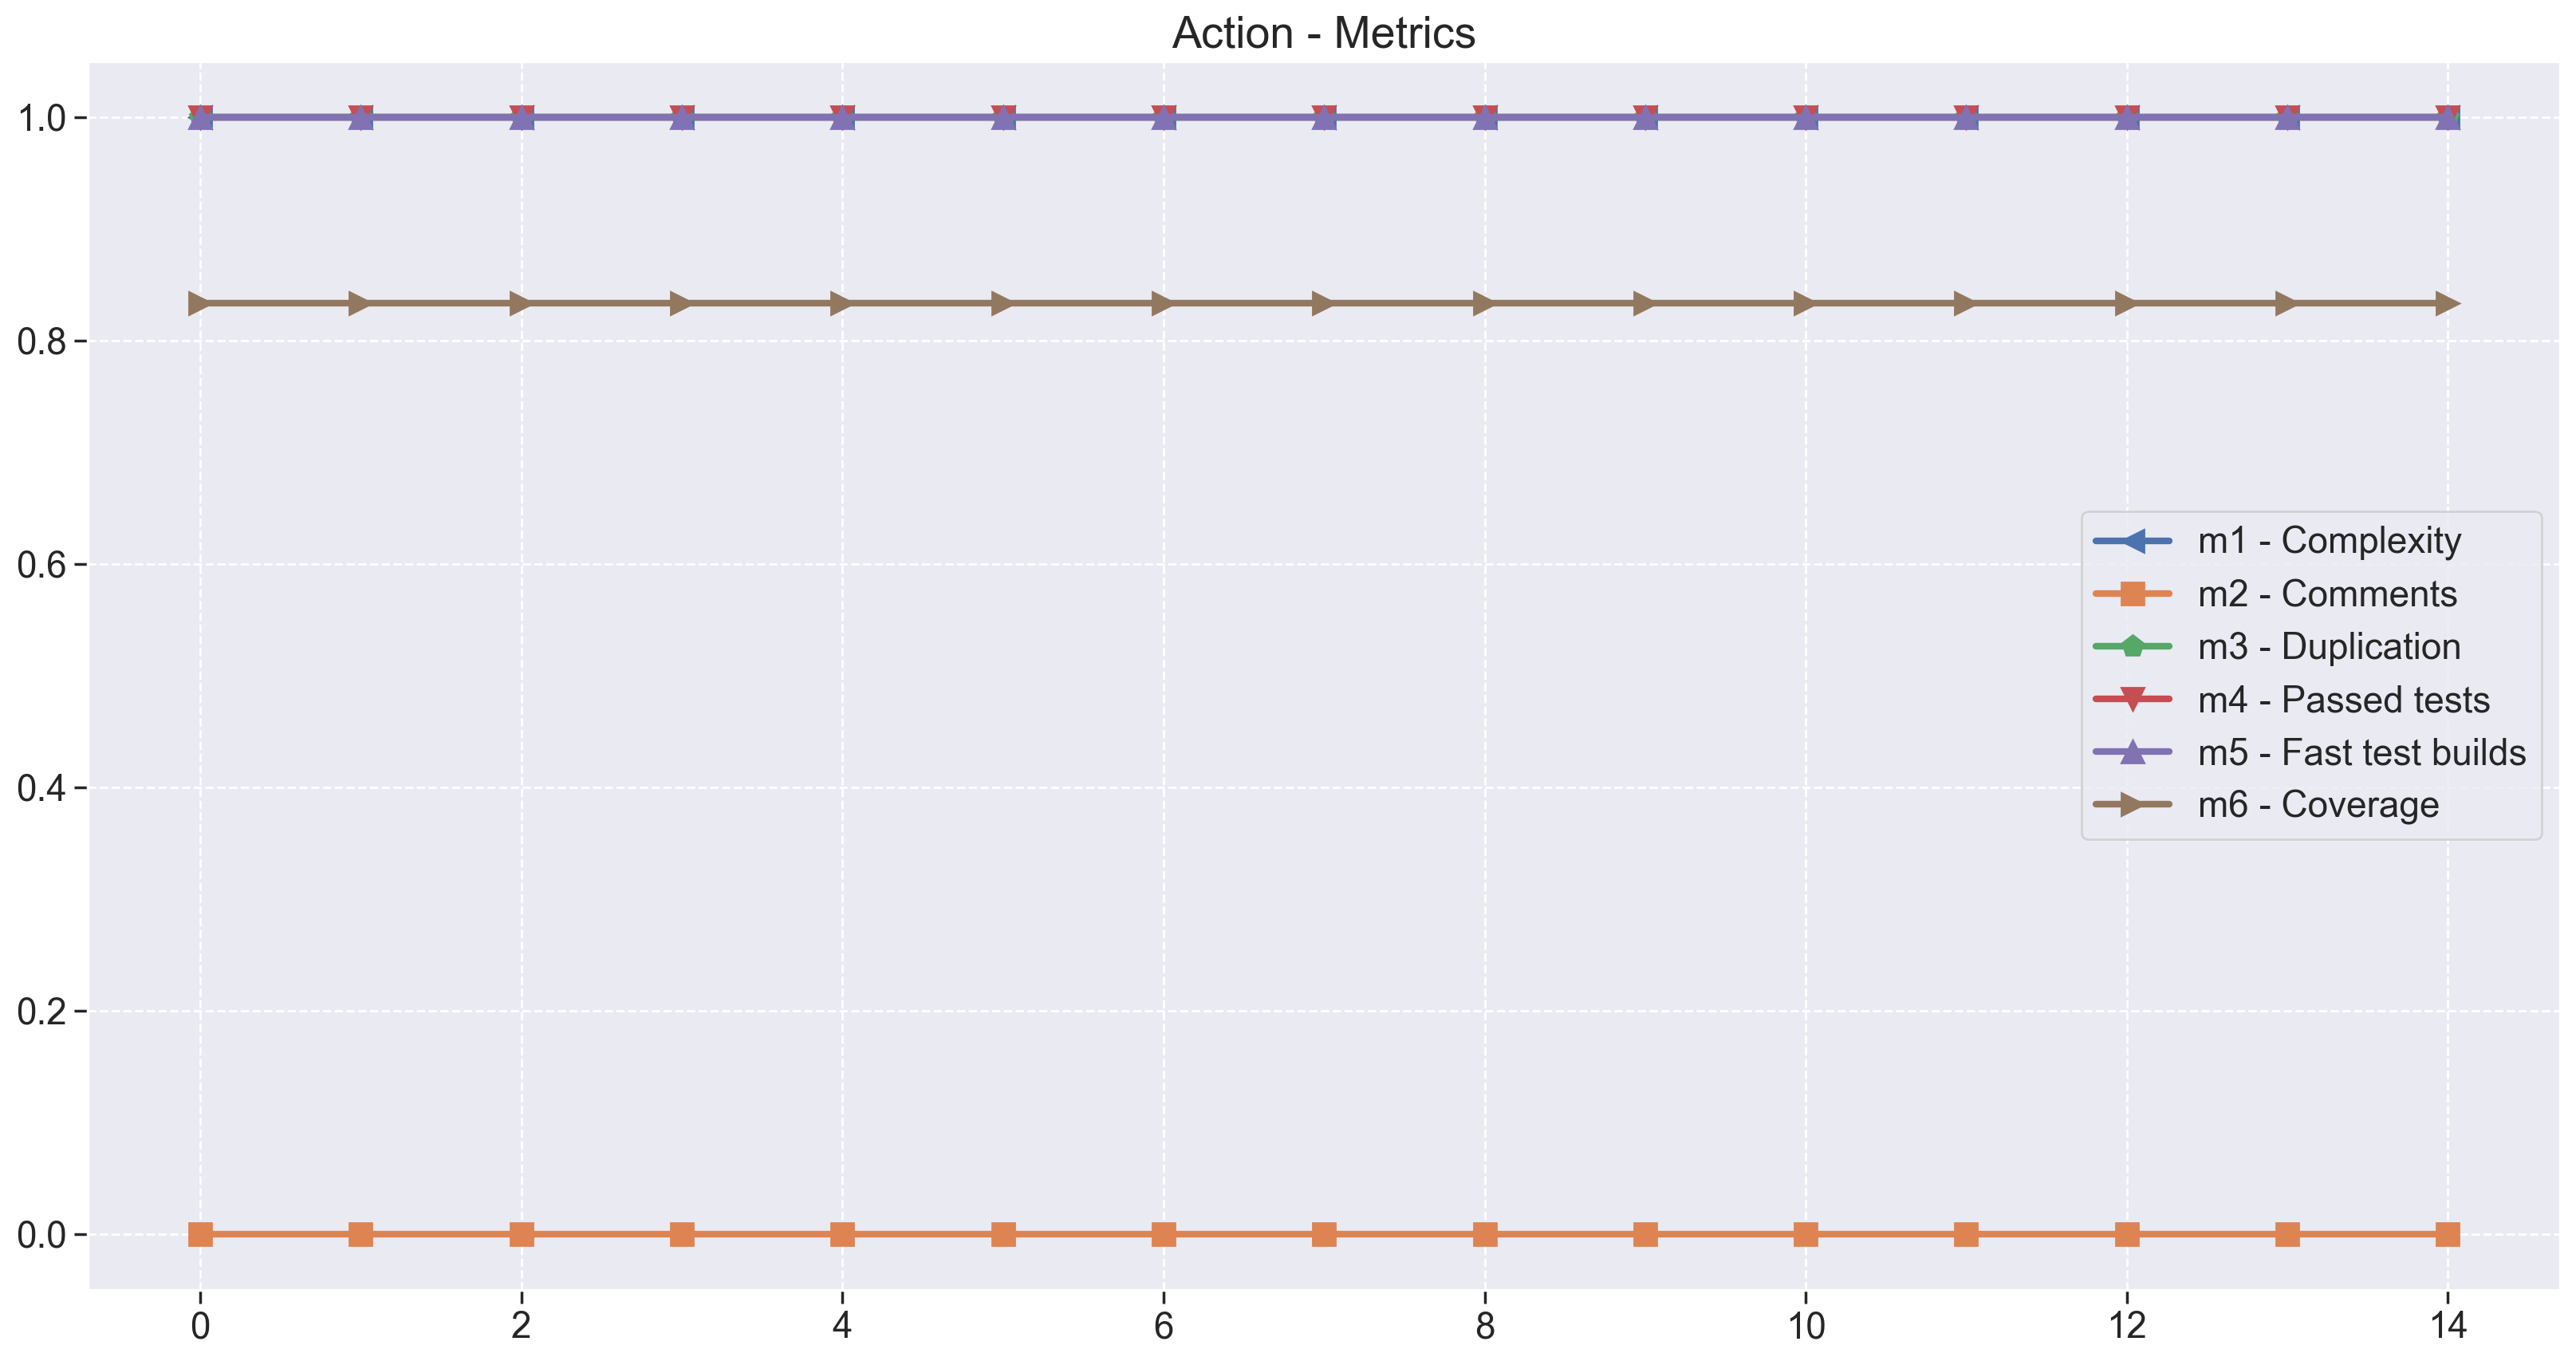

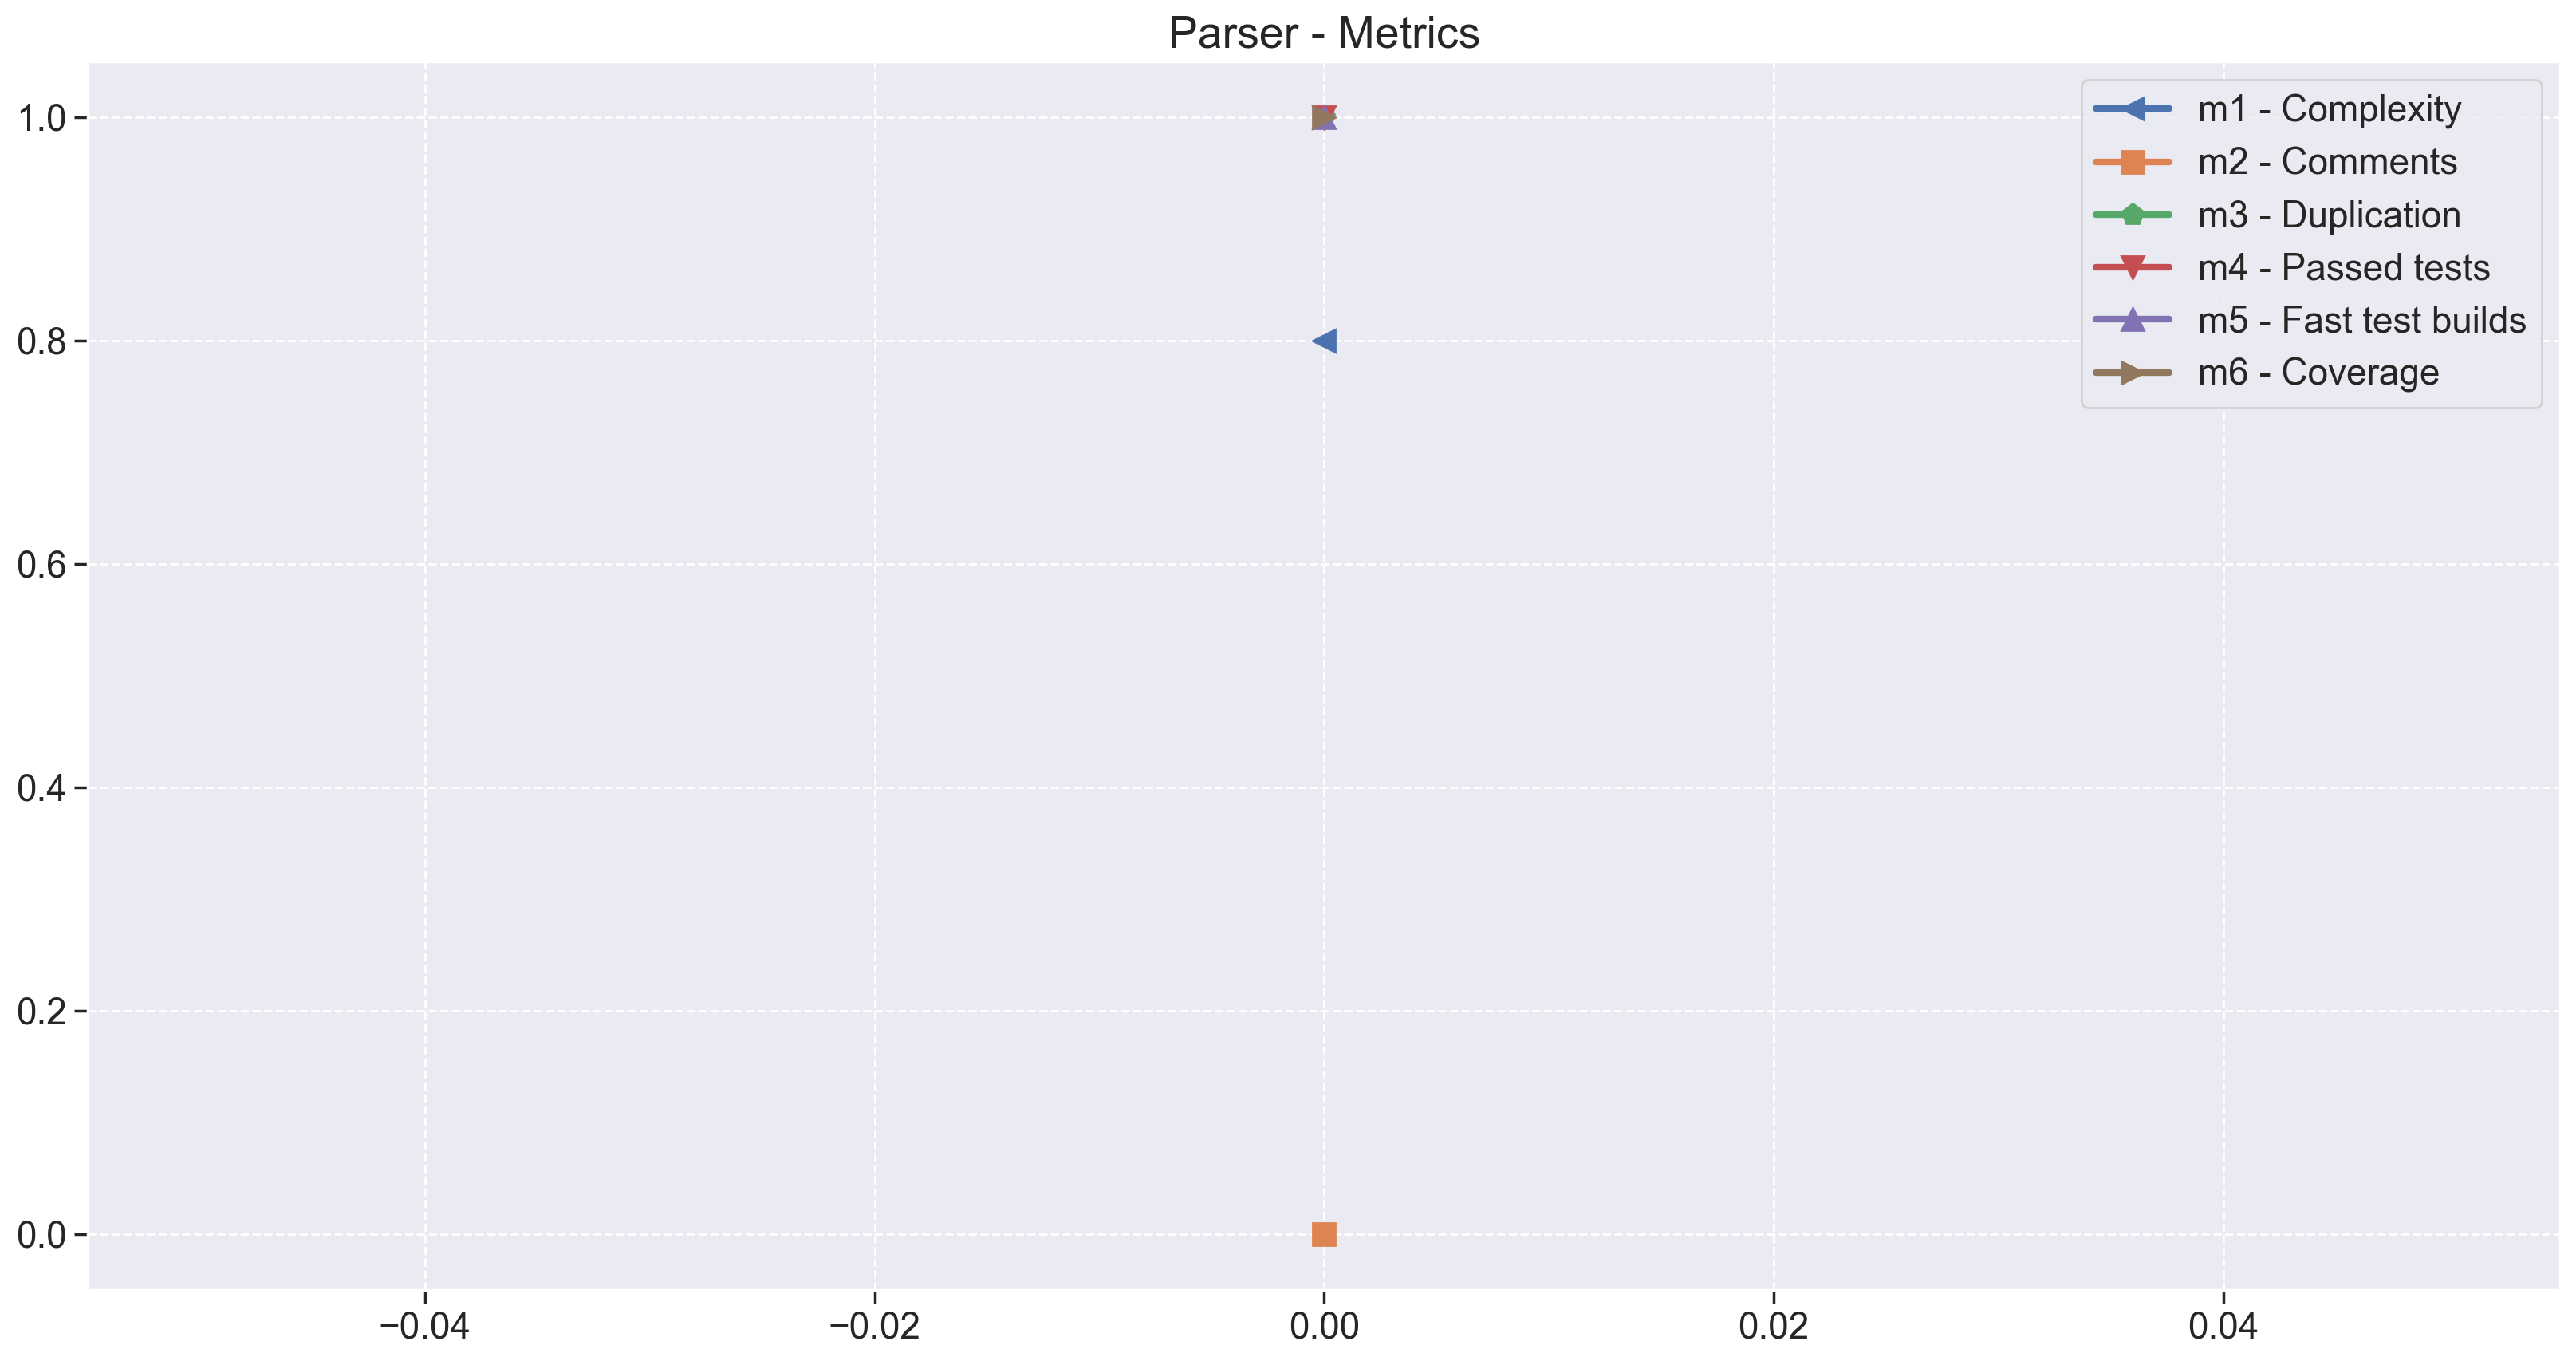

In [56]:
for name, data in metrics.items():
    fig = plt.figure(figsize=(20, 10))

    plt.plot(data['m1'], linewidth=3, marker='<', markersize=10, label="m1 - Complexity")
    plt.plot(data['m2'], linewidth=3, marker='s', markersize=10, label="m2 - Comments")
    plt.plot(data['m3'], linewidth=3, marker='p', markersize=10, label="m3 - Duplication")
    plt.plot(data['m4'], linewidth=3, marker='v', markersize=10, label="m4 - Passed tests")
    plt.plot(data['m5'], linewidth=3, marker='^', markersize=10, label="m5 - Fast test builds")
    plt.plot(data['m6'], linewidth=3, marker='>', markersize=10, label="m6 - Coverage")

    plt.title(f"{name} - Metrics", fontsize=20)
    plt.legend(loc='best')
    plt.show()

## Quality factor and aspect aggregation

In [57]:
psc1 = 1
psc2 = 1
pc1 = 0.5
pc2 = 0.5
pm1 = 0.33
pm2 = 0.33
pm3 = 0.33
pm4 = 0.25
pm5 = 0.25
pm6 = 0.5


# Here you will need to create the code_quality and testing_status metrics for each repository.

for name, data in metrics.items():
    data['code_quality'] = ((data['m1']*pm1) + (data['m2']*pm2) + (data['m3']*pm3)) * psc1
    data['testing_status'] = ((data['m4']*pm4) + (data['m5']*pm5) + (data['m6']*pm6)) * psc2

### Code Quality visualization

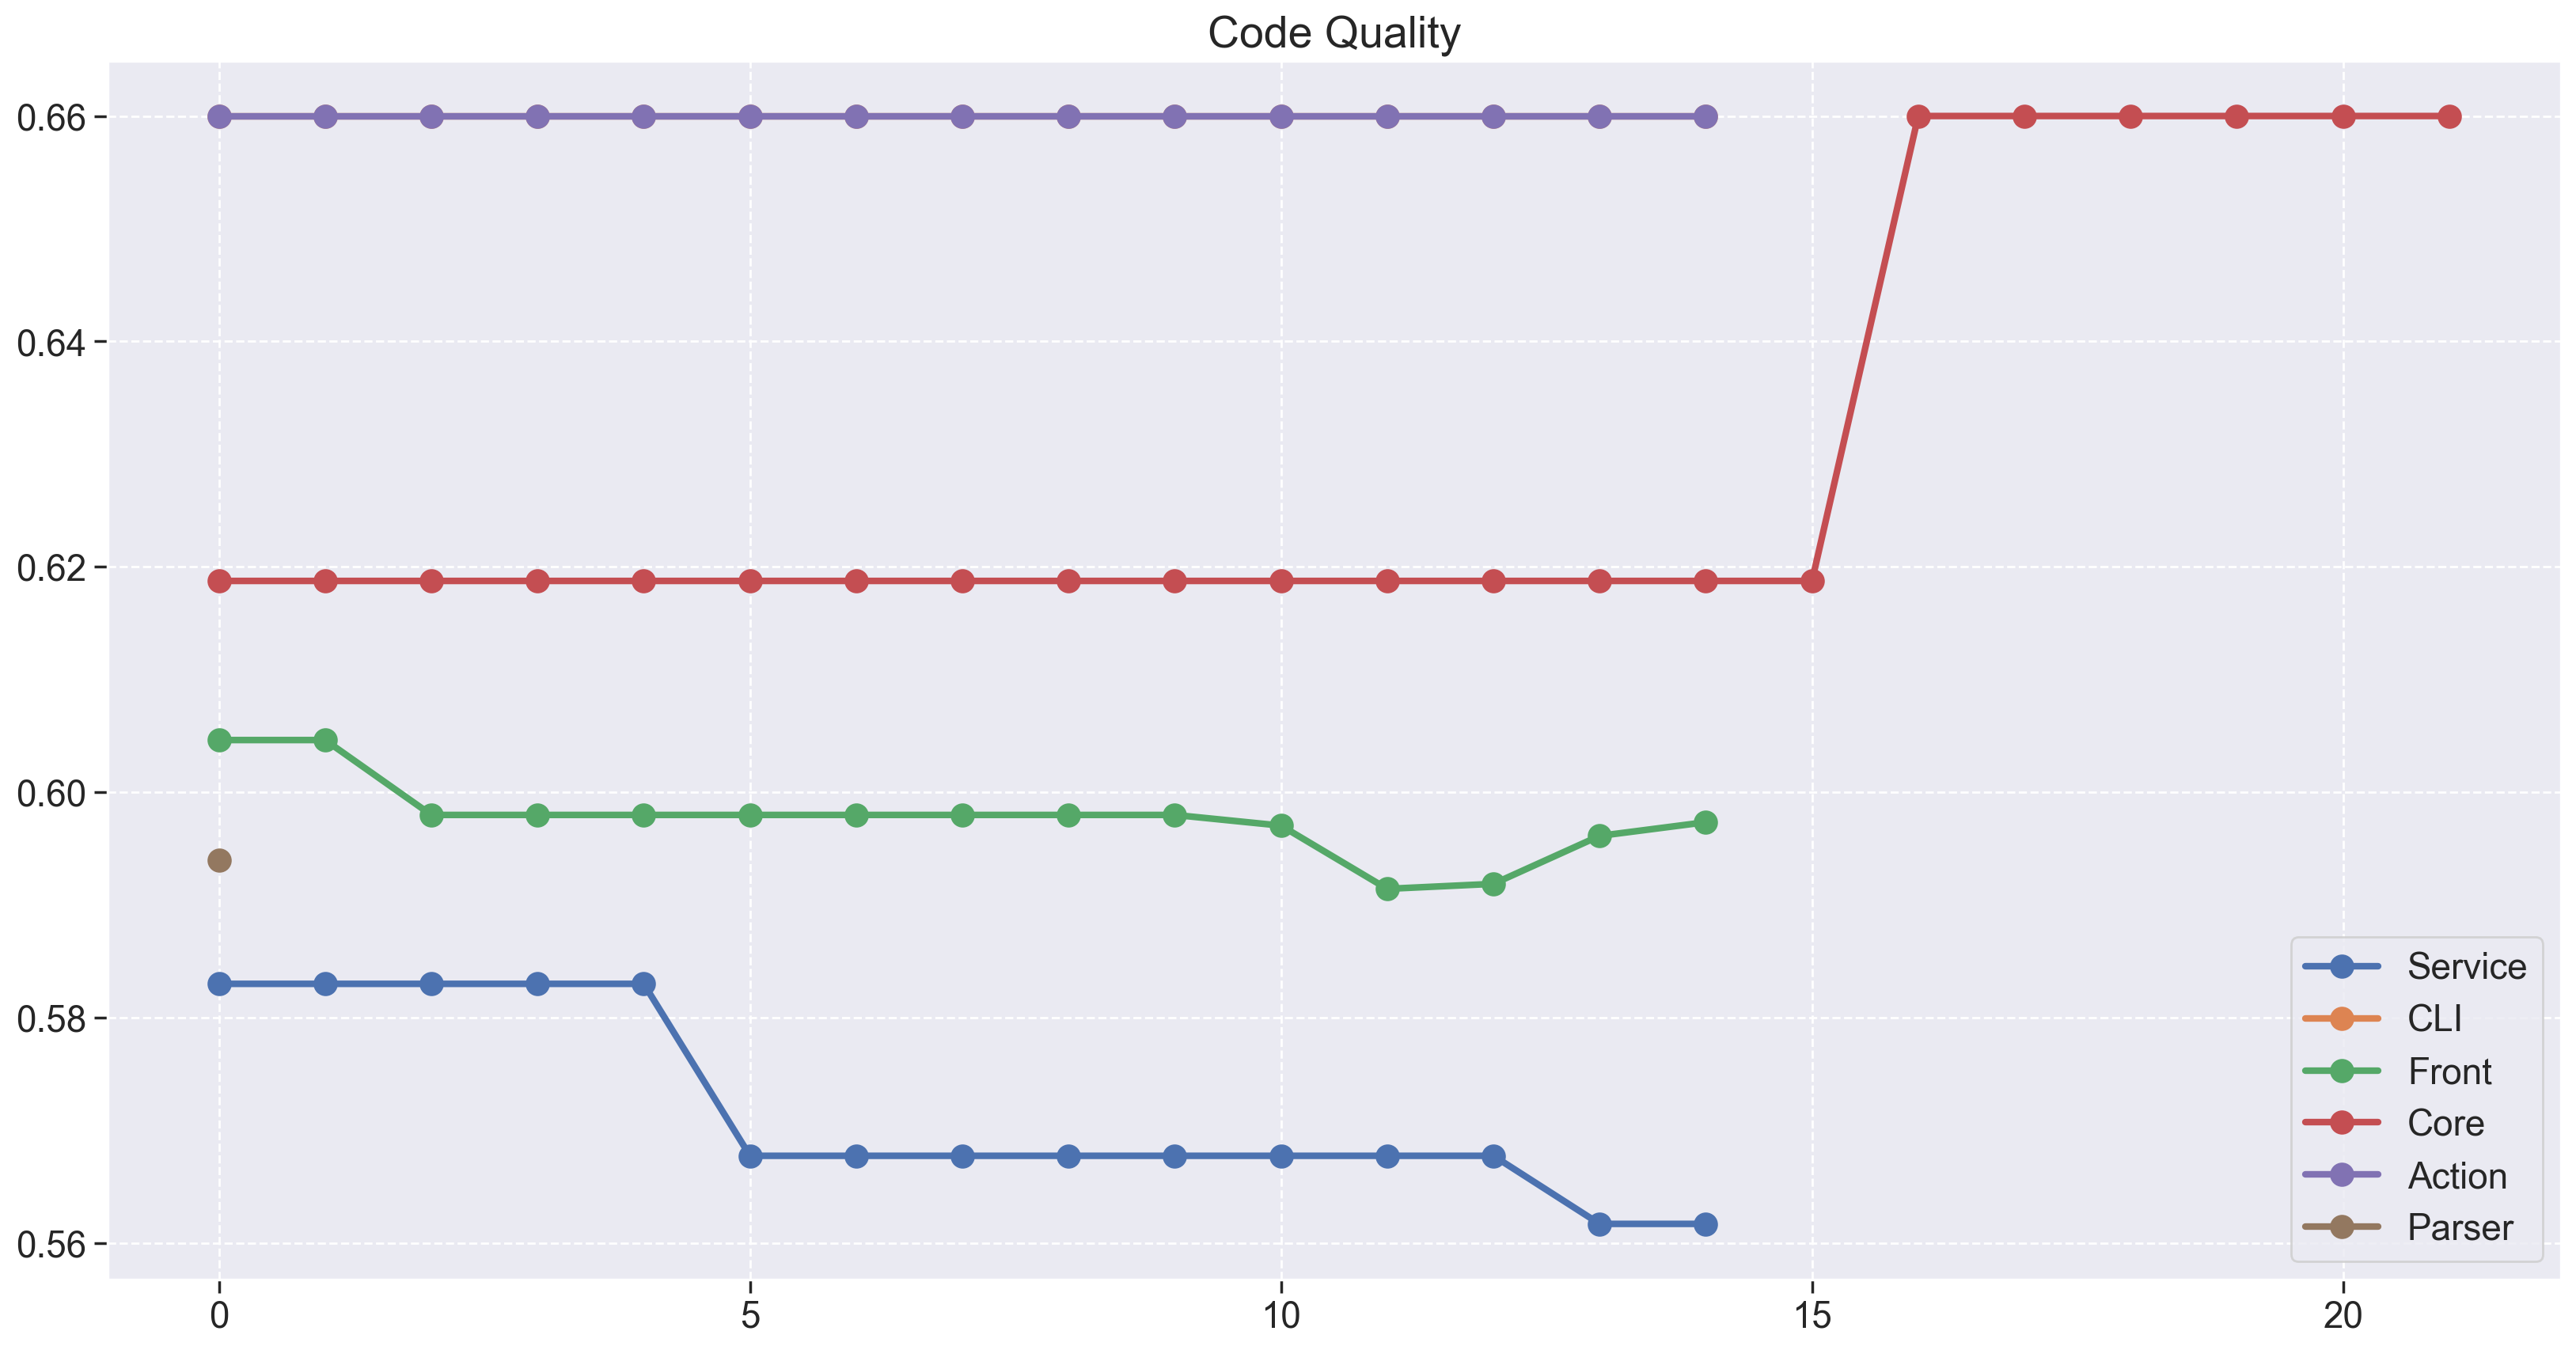

In [58]:
fig = plt.figure(figsize=(20, 10))

for name, data in metrics.items():
    plt.plot(data['code_quality'], linewidth=3, marker='o', markersize=10, label=name)

plt.title("Code Quality", fontsize=20)
plt.legend(loc='best')
plt.show()

### Testing Status visualization

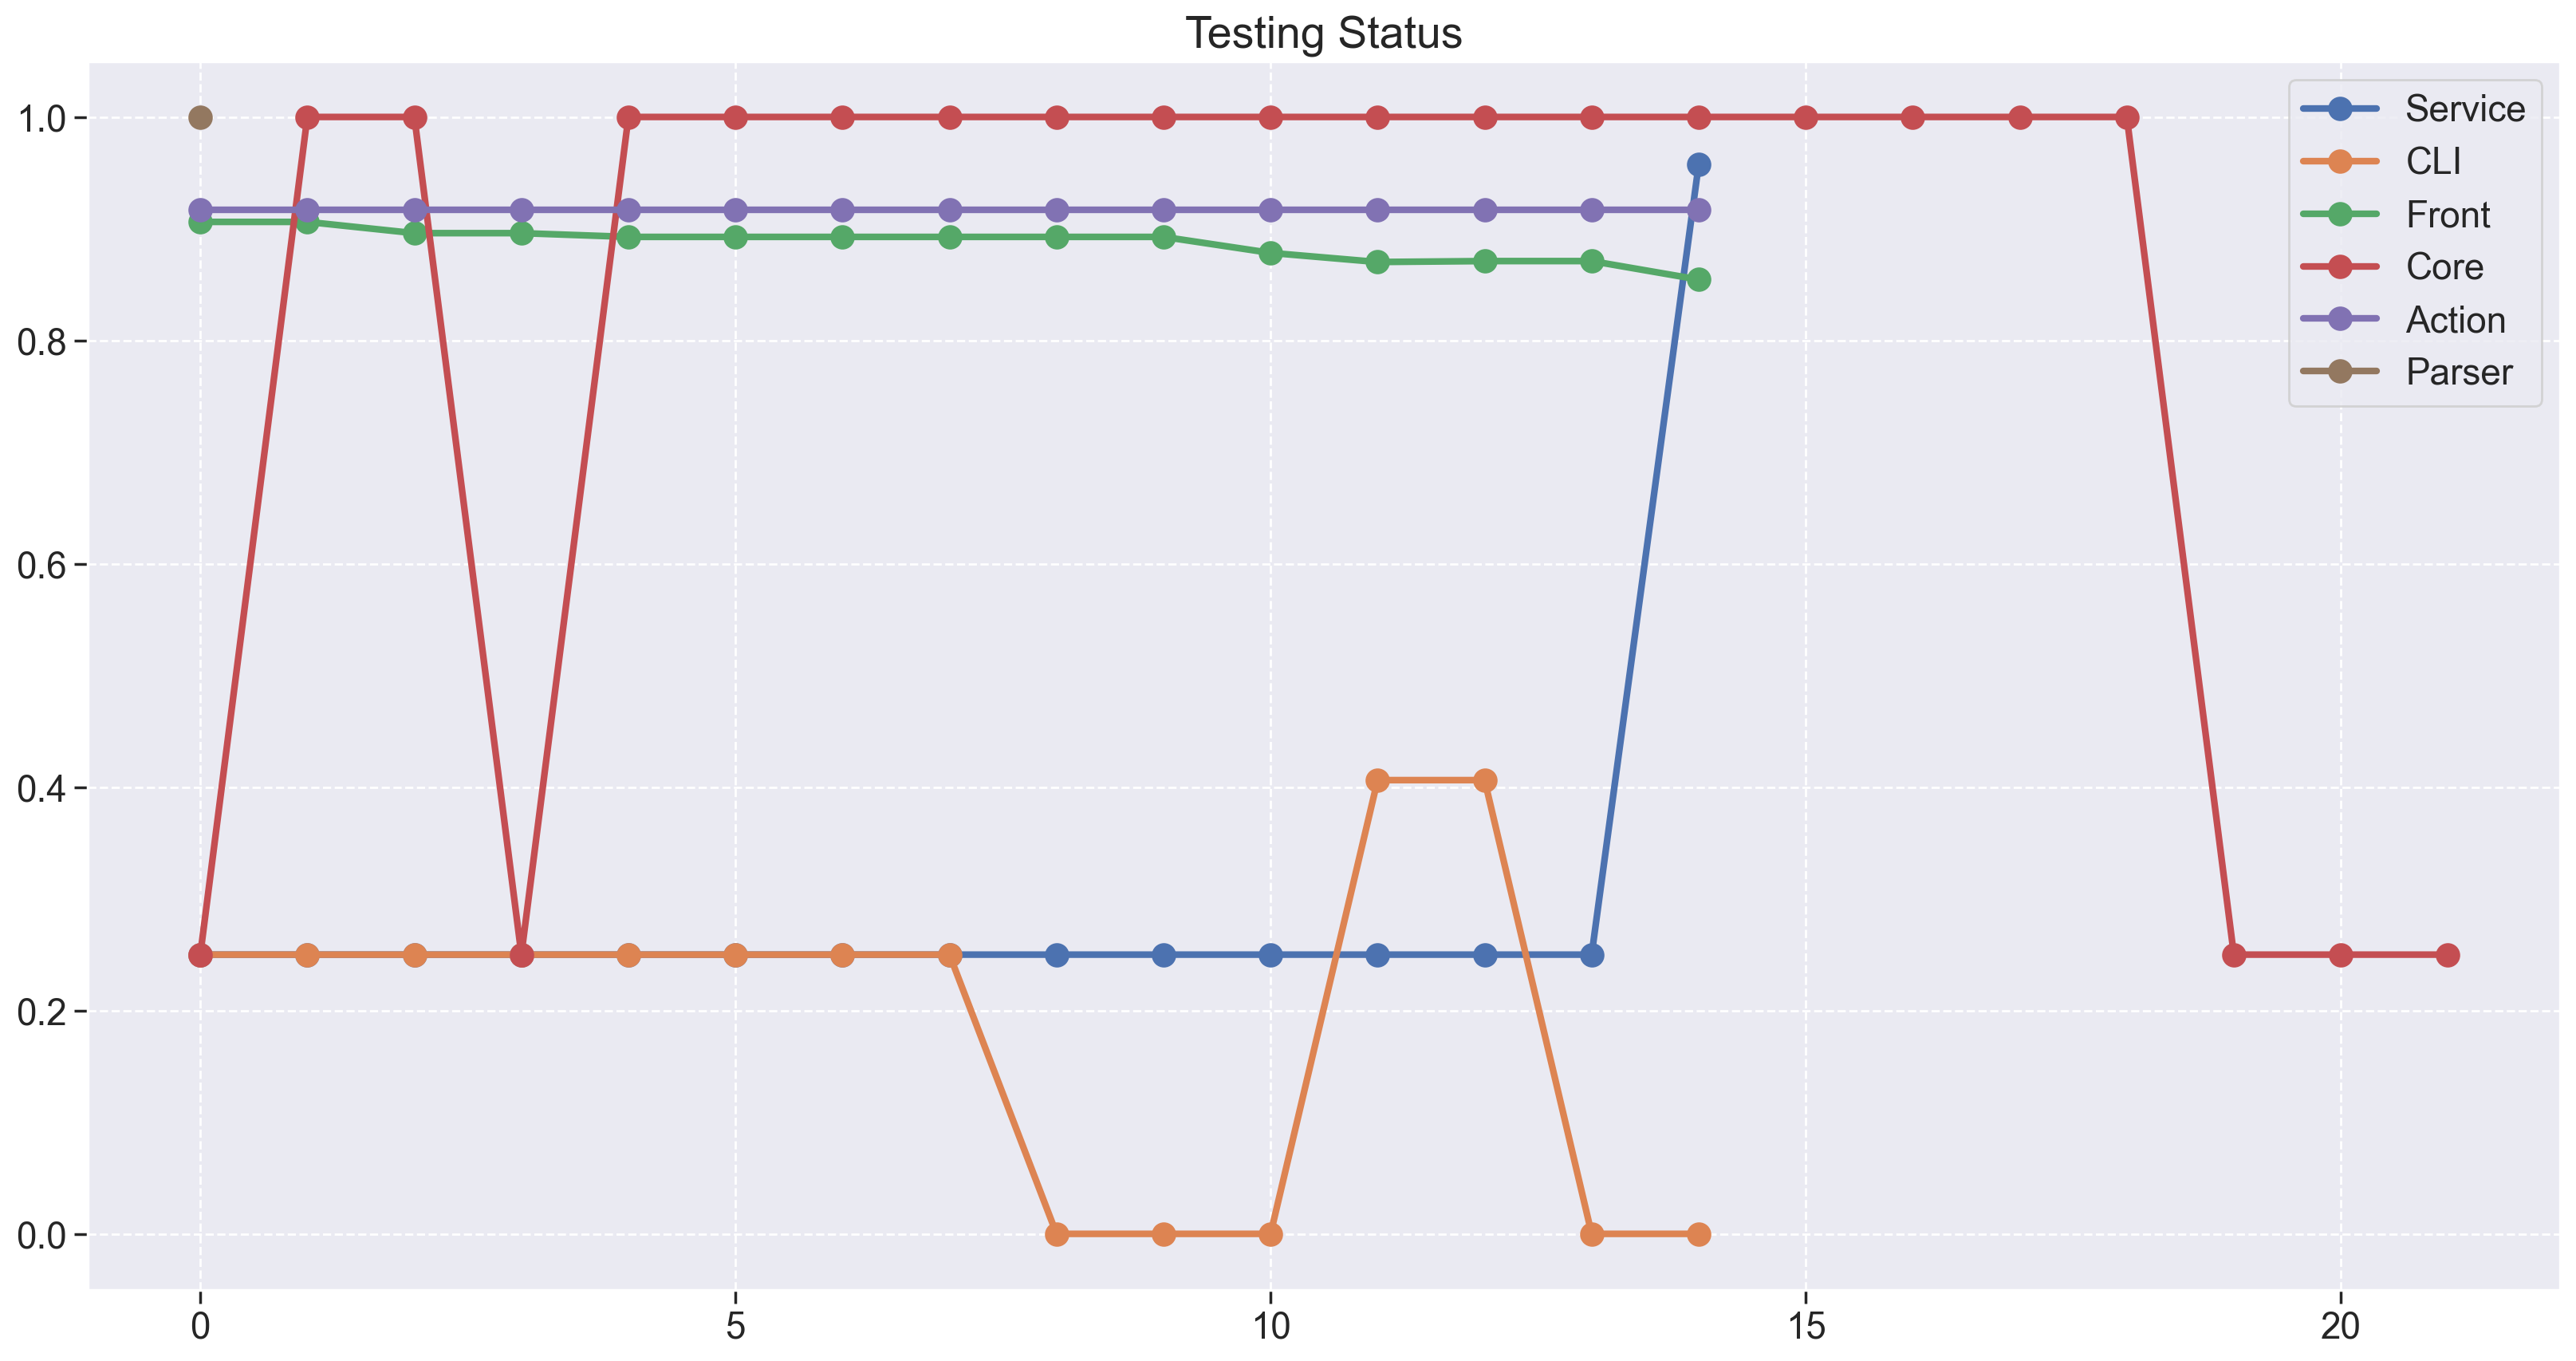

In [59]:
fig = plt.figure(figsize=(20, 10))

for name, data in metrics.items():
    plt.plot(data['testing_status'], linewidth=3, marker='o', markersize=10, label=name)

plt.title("Testing Status", fontsize=20)
plt.legend(loc='best')
plt.show()

### Aggregations

In [60]:
for name, data in metrics.items():
    data['Maintainability'] = data['code_quality'] * pc1
    data['Reliability'] = data['testing_status'] * pc2
    data['total'] = data['Maintainability'] + data['Reliability']

## Repositories analysis

In [61]:
def get_characteristc_stats(repo_series):
    return {
        'mean': repo_series.mean(),
        'mode': repo_series.mode(),
        'median': repo_series.median(),
        'std': repo_series.std(),
        'var': repo_series.var(),
        'min': repo_series.min(),
        'max': repo_series.max()
    }

In [62]:
def analysis(metrics, name):
    maintainability_stats = pd.DataFrame(get_characteristc_stats(metrics["Maintainability"]),
                                     columns=['mean', 'mode', 'median', 'std', 'var', 'min', 'max'])

    reliability_stats = pd.DataFrame(get_characteristc_stats(metrics["Reliability"]),
                                 columns=['mean', 'mode', 'median', 'std', 'var', 'min', 'max'])


    print("Maintainability Stats")
    print(maintainability_stats.to_string(index=False))

    print("Reliability Stats")
    print(reliability_stats.to_string(index=False))

    fig = plt.figure(figsize=(20, 10))

    plt.plot(metrics['Maintainability'], linewidth=3, marker='o', markersize=10, label="Maintainability")
    plt.plot(metrics['Reliability'], linewidth=3, marker='*', markersize=10, label="Reliability")

    plt.ylim(0.1,1.1)
    plt.title(f'{name} - Maintainability and Reliability', fontsize=20)
    plt.legend(loc='best')
    plt.show()

    fig = plt.figure(figsize=(20, 10))

    plt.plot(metrics['total'], linewidth=3, marker='X', markersize=5)

    plt.ylim(0.1,1.1)
    plt.title(f'{name} - Total', fontsize=20)
    plt.show()

### Analysis loop in each repo

Service
Maintainability Stats
    mean     mode   median      std      var      min    max
0.286011 0.283871 0.283871 0.004145 0.000017 0.280851 0.2915
Reliability Stats
    mean  mode  median      std      var   min      max
0.148582 0.125   0.125 0.091331 0.008341 0.125 0.478723


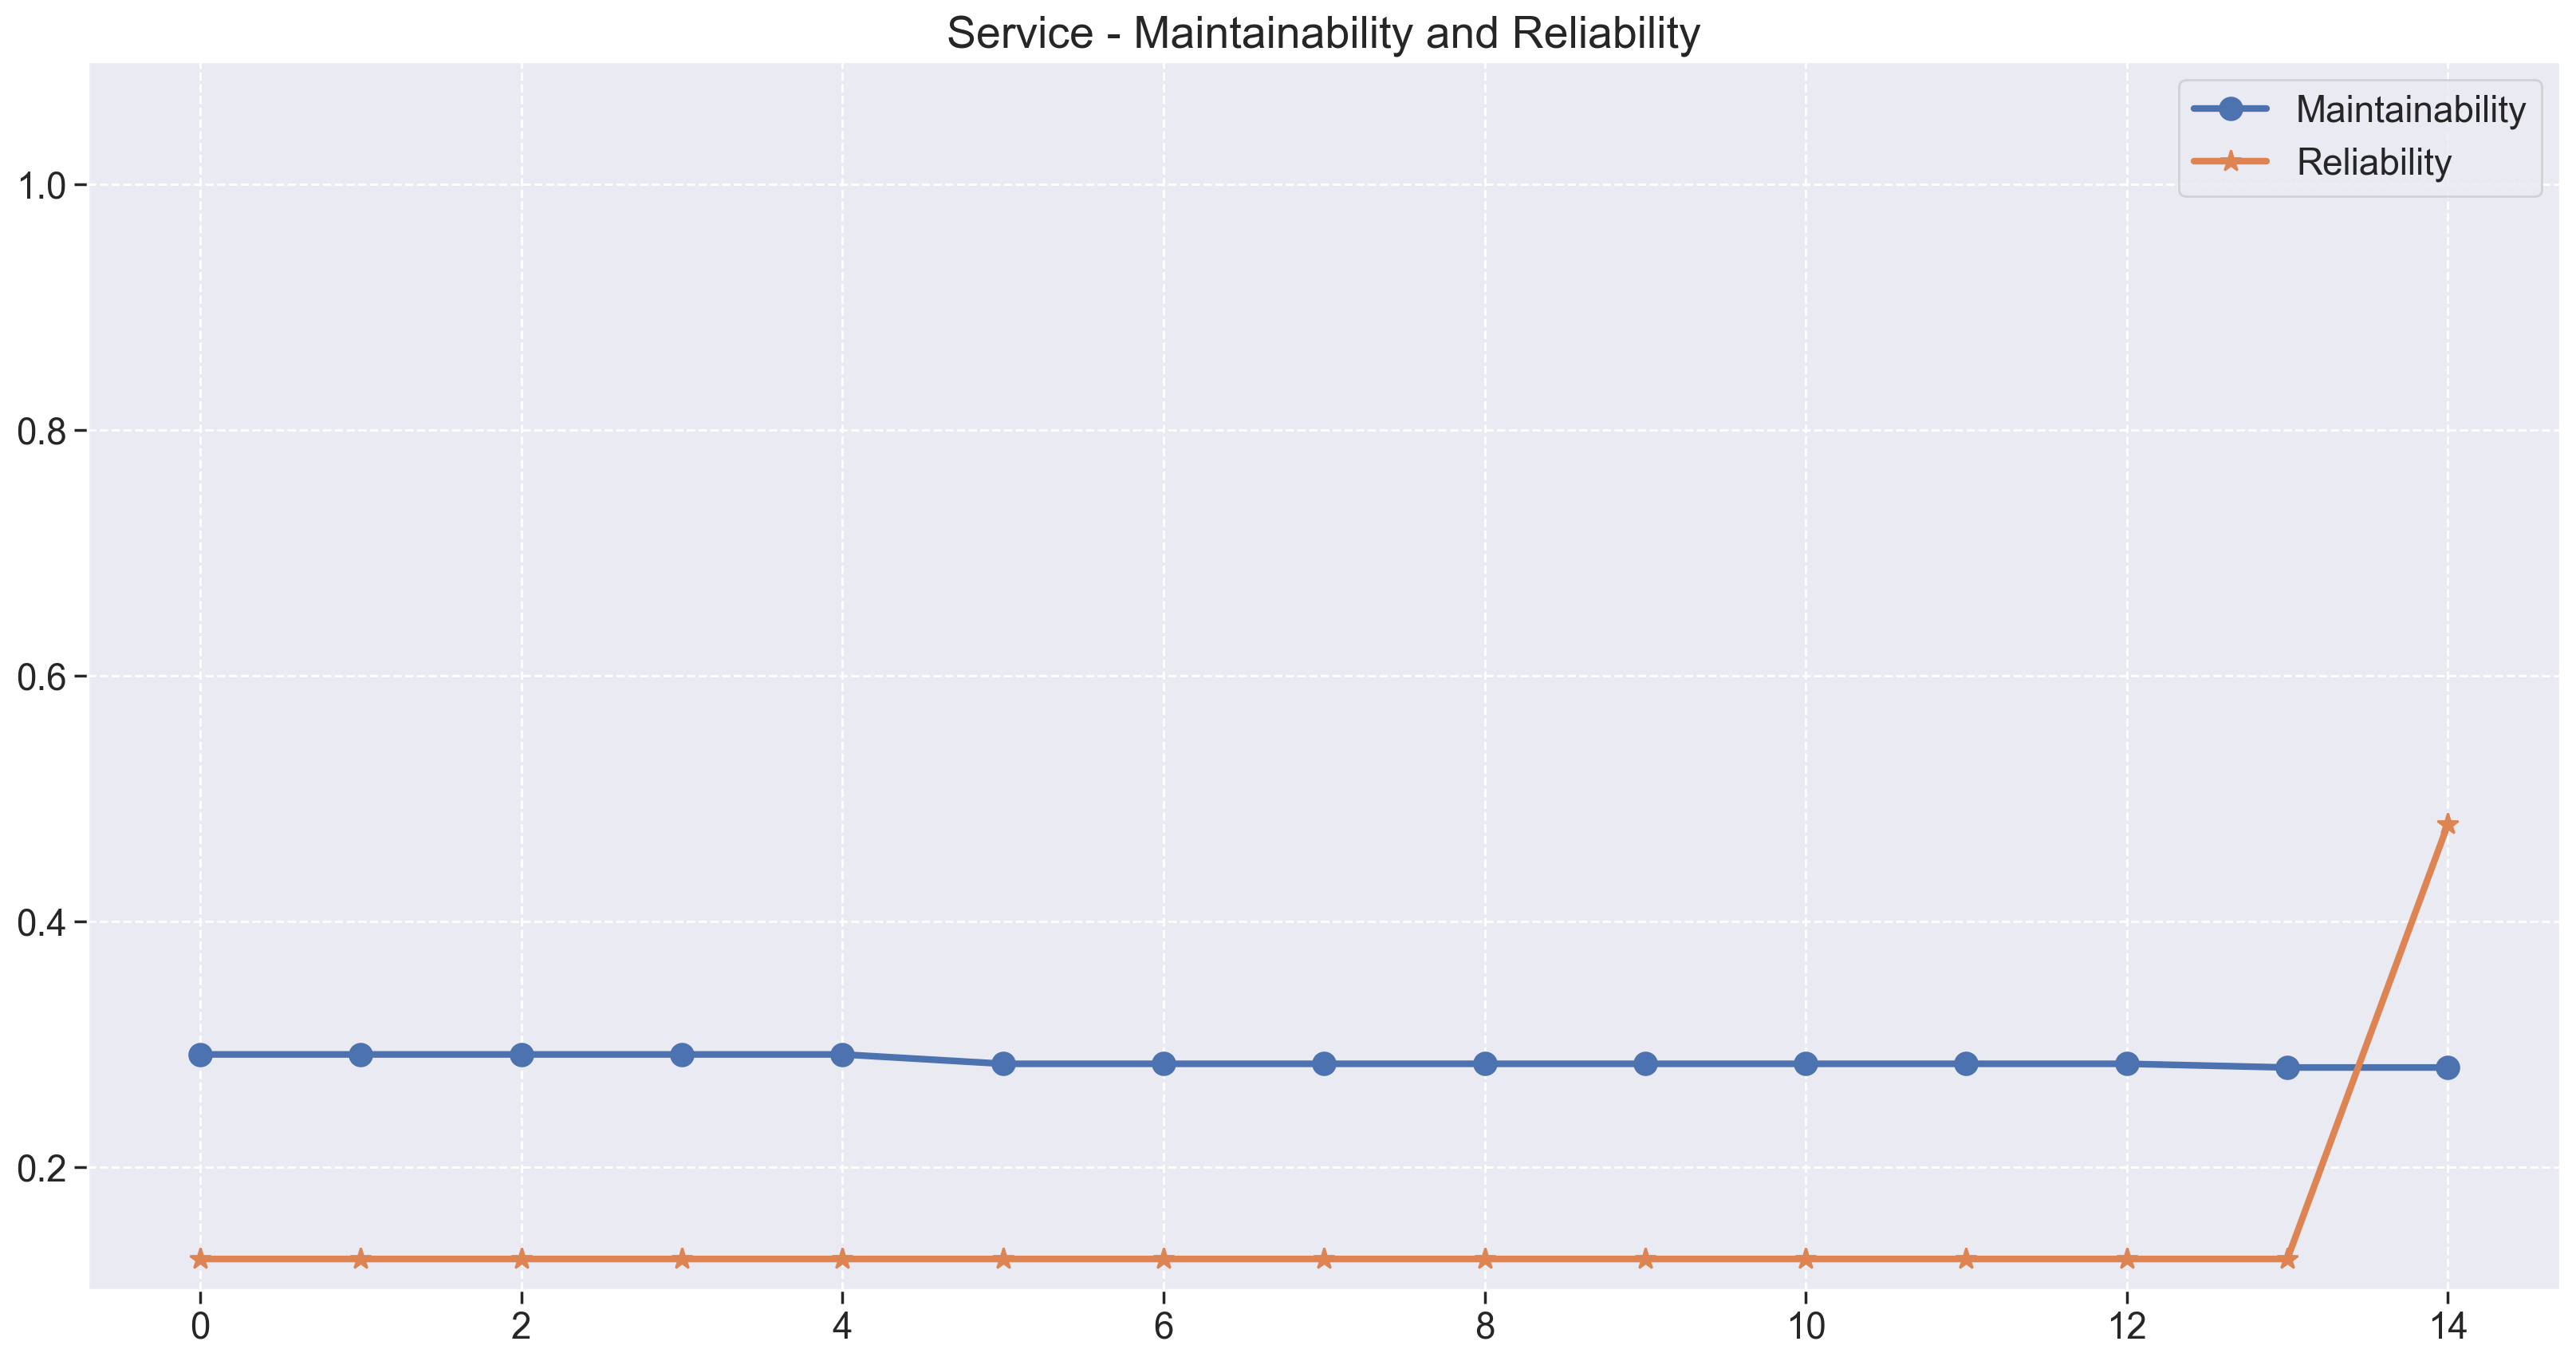

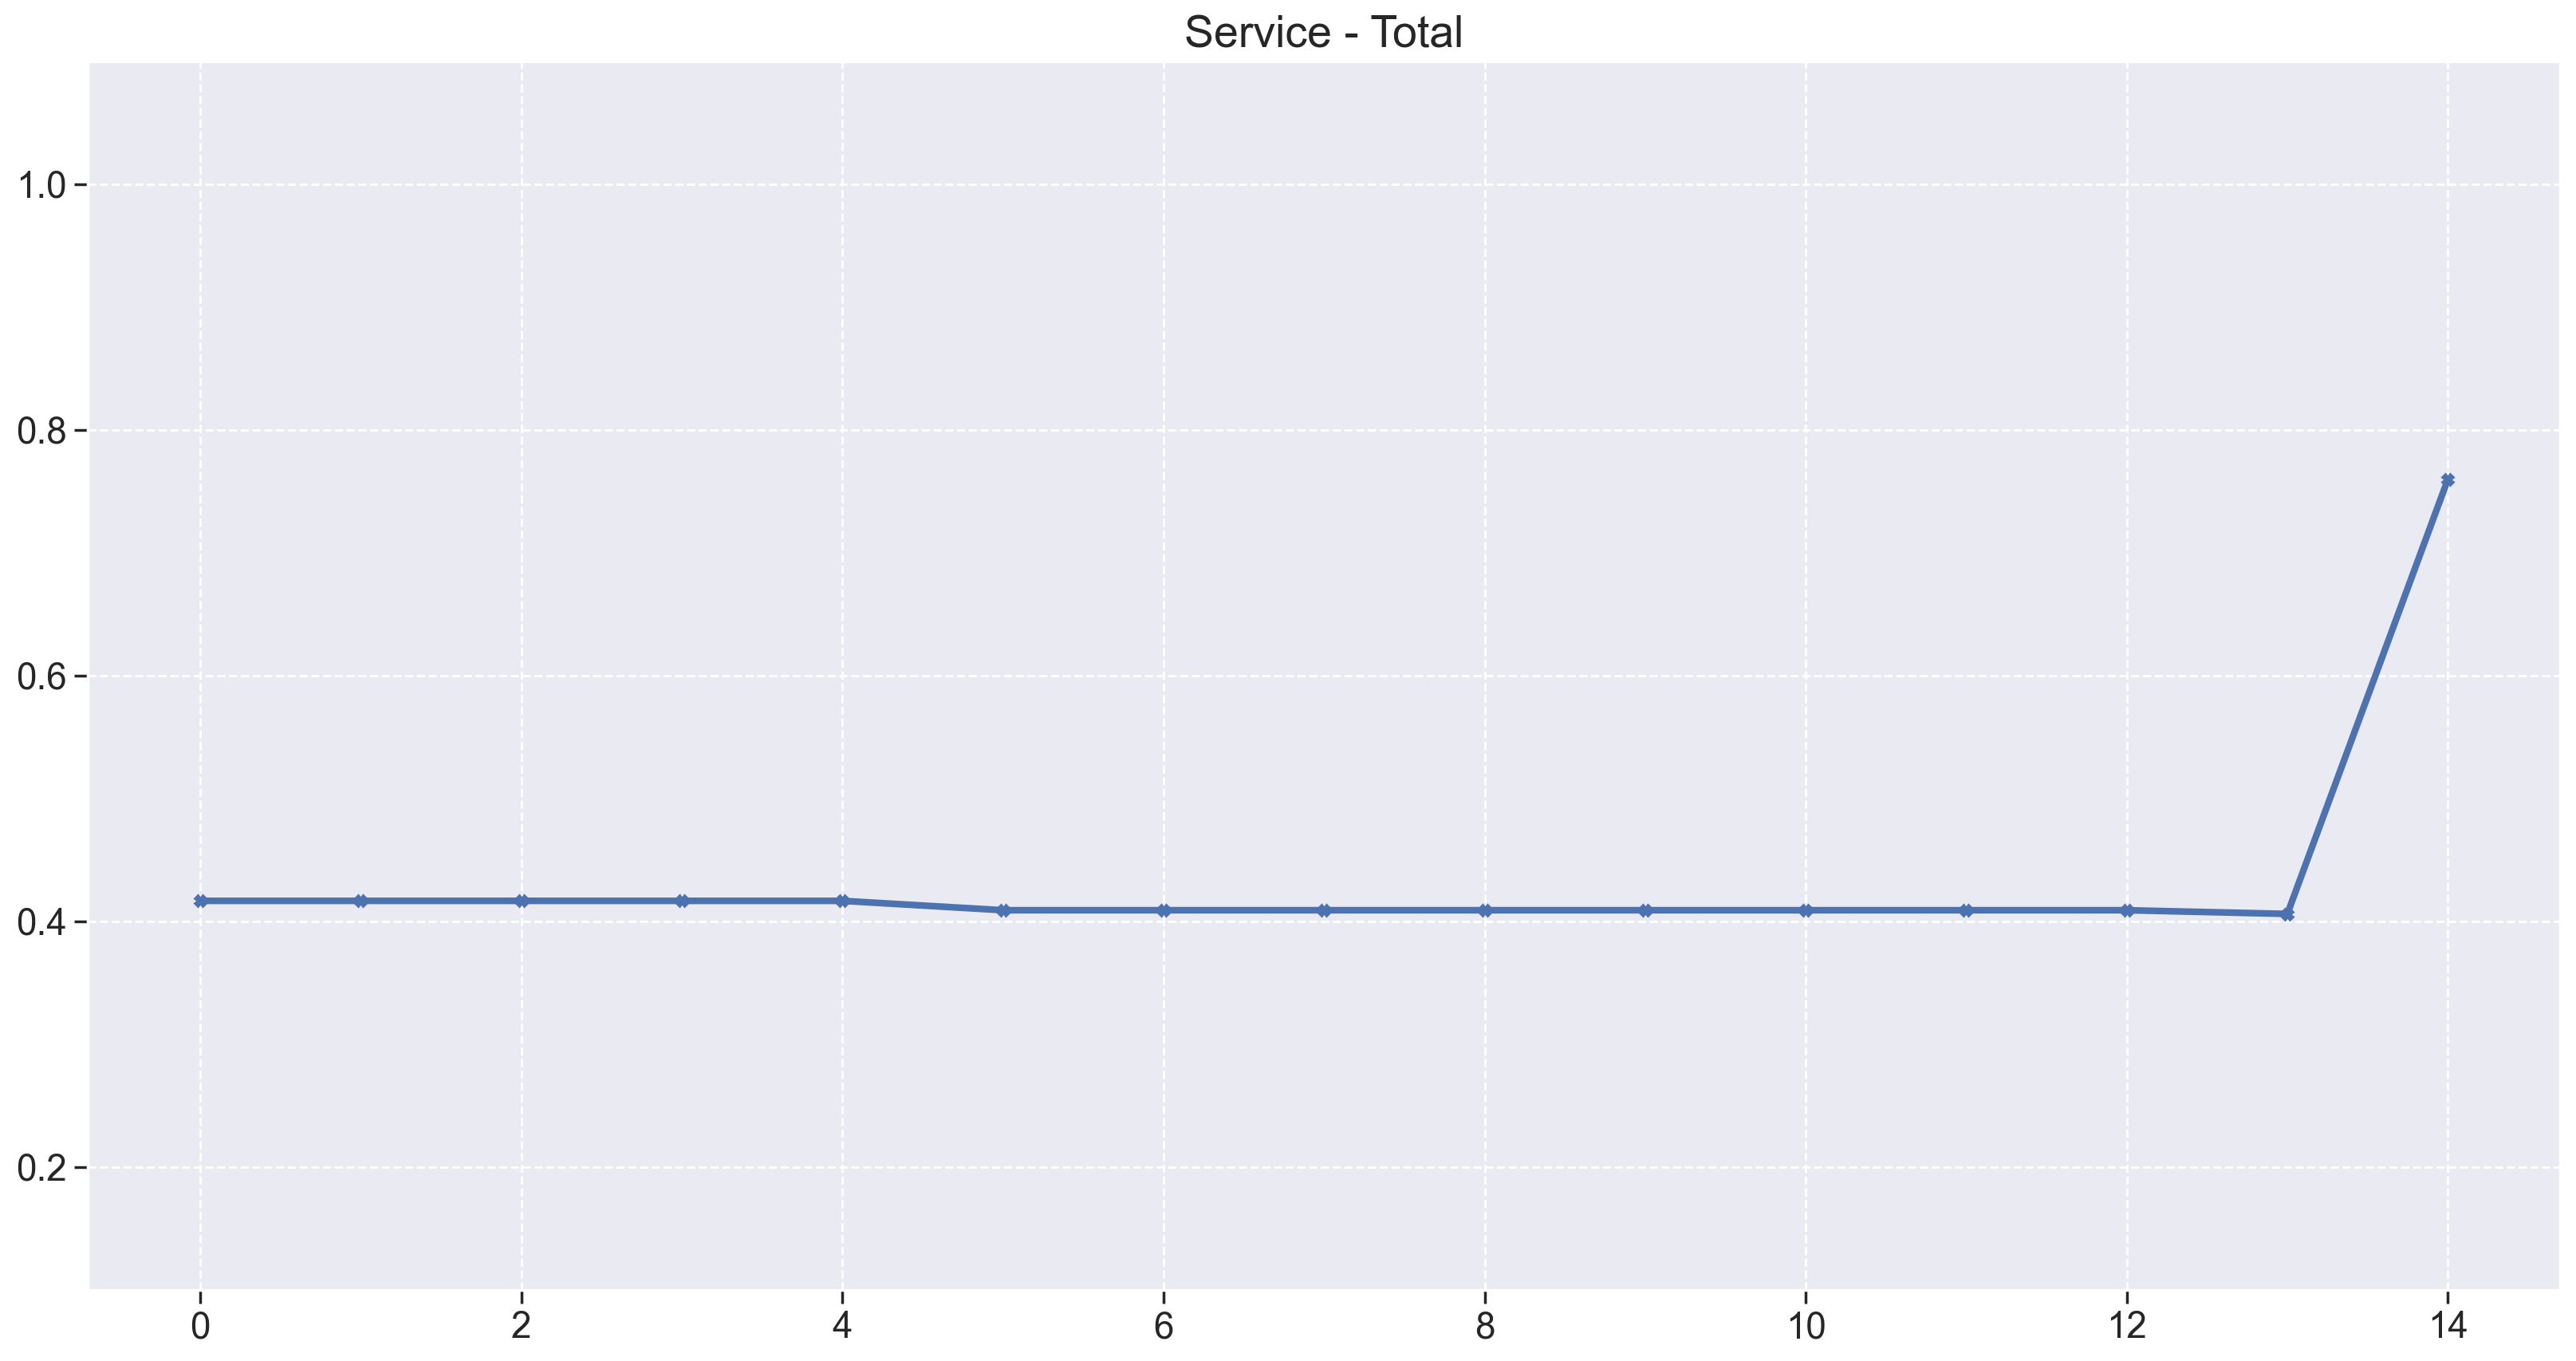

CLI
Maintainability Stats
 mean  mode  median  std  var  min  max
 0.33  0.33    0.33  0.0  0.0 0.33 0.33
Reliability Stats
   mean  mode  median      std      var  min      max
0.09375 0.125   0.125 0.073525 0.005406  0.0 0.203125


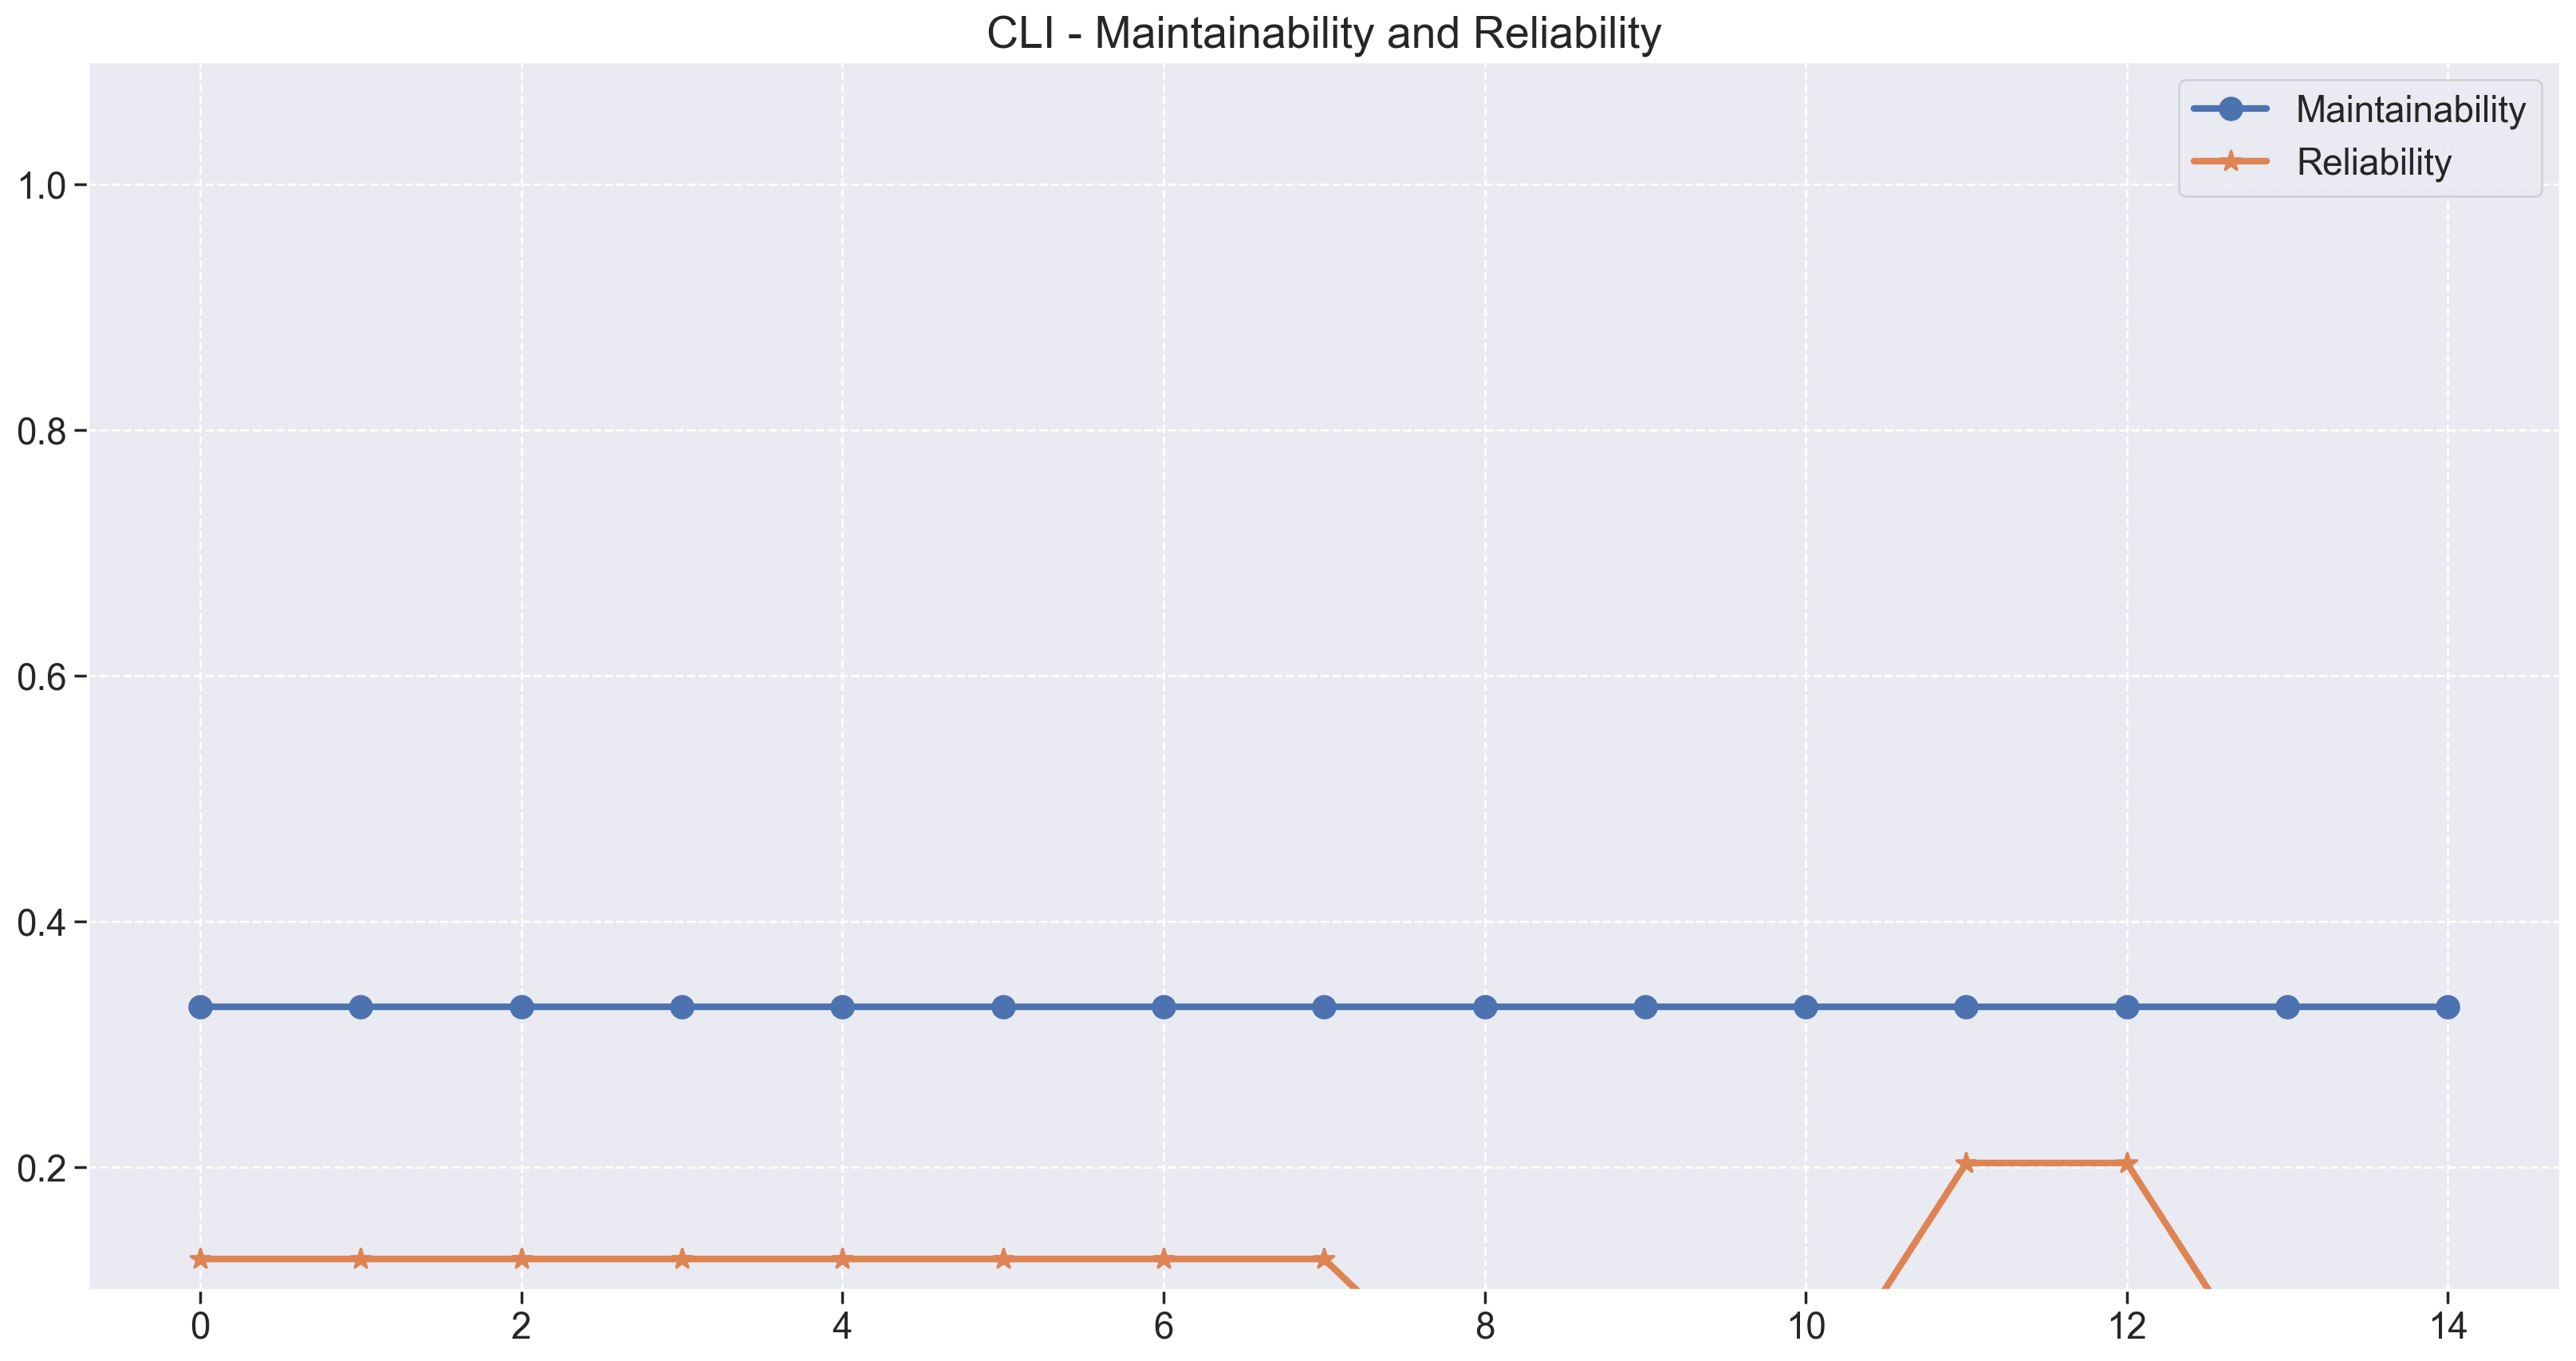

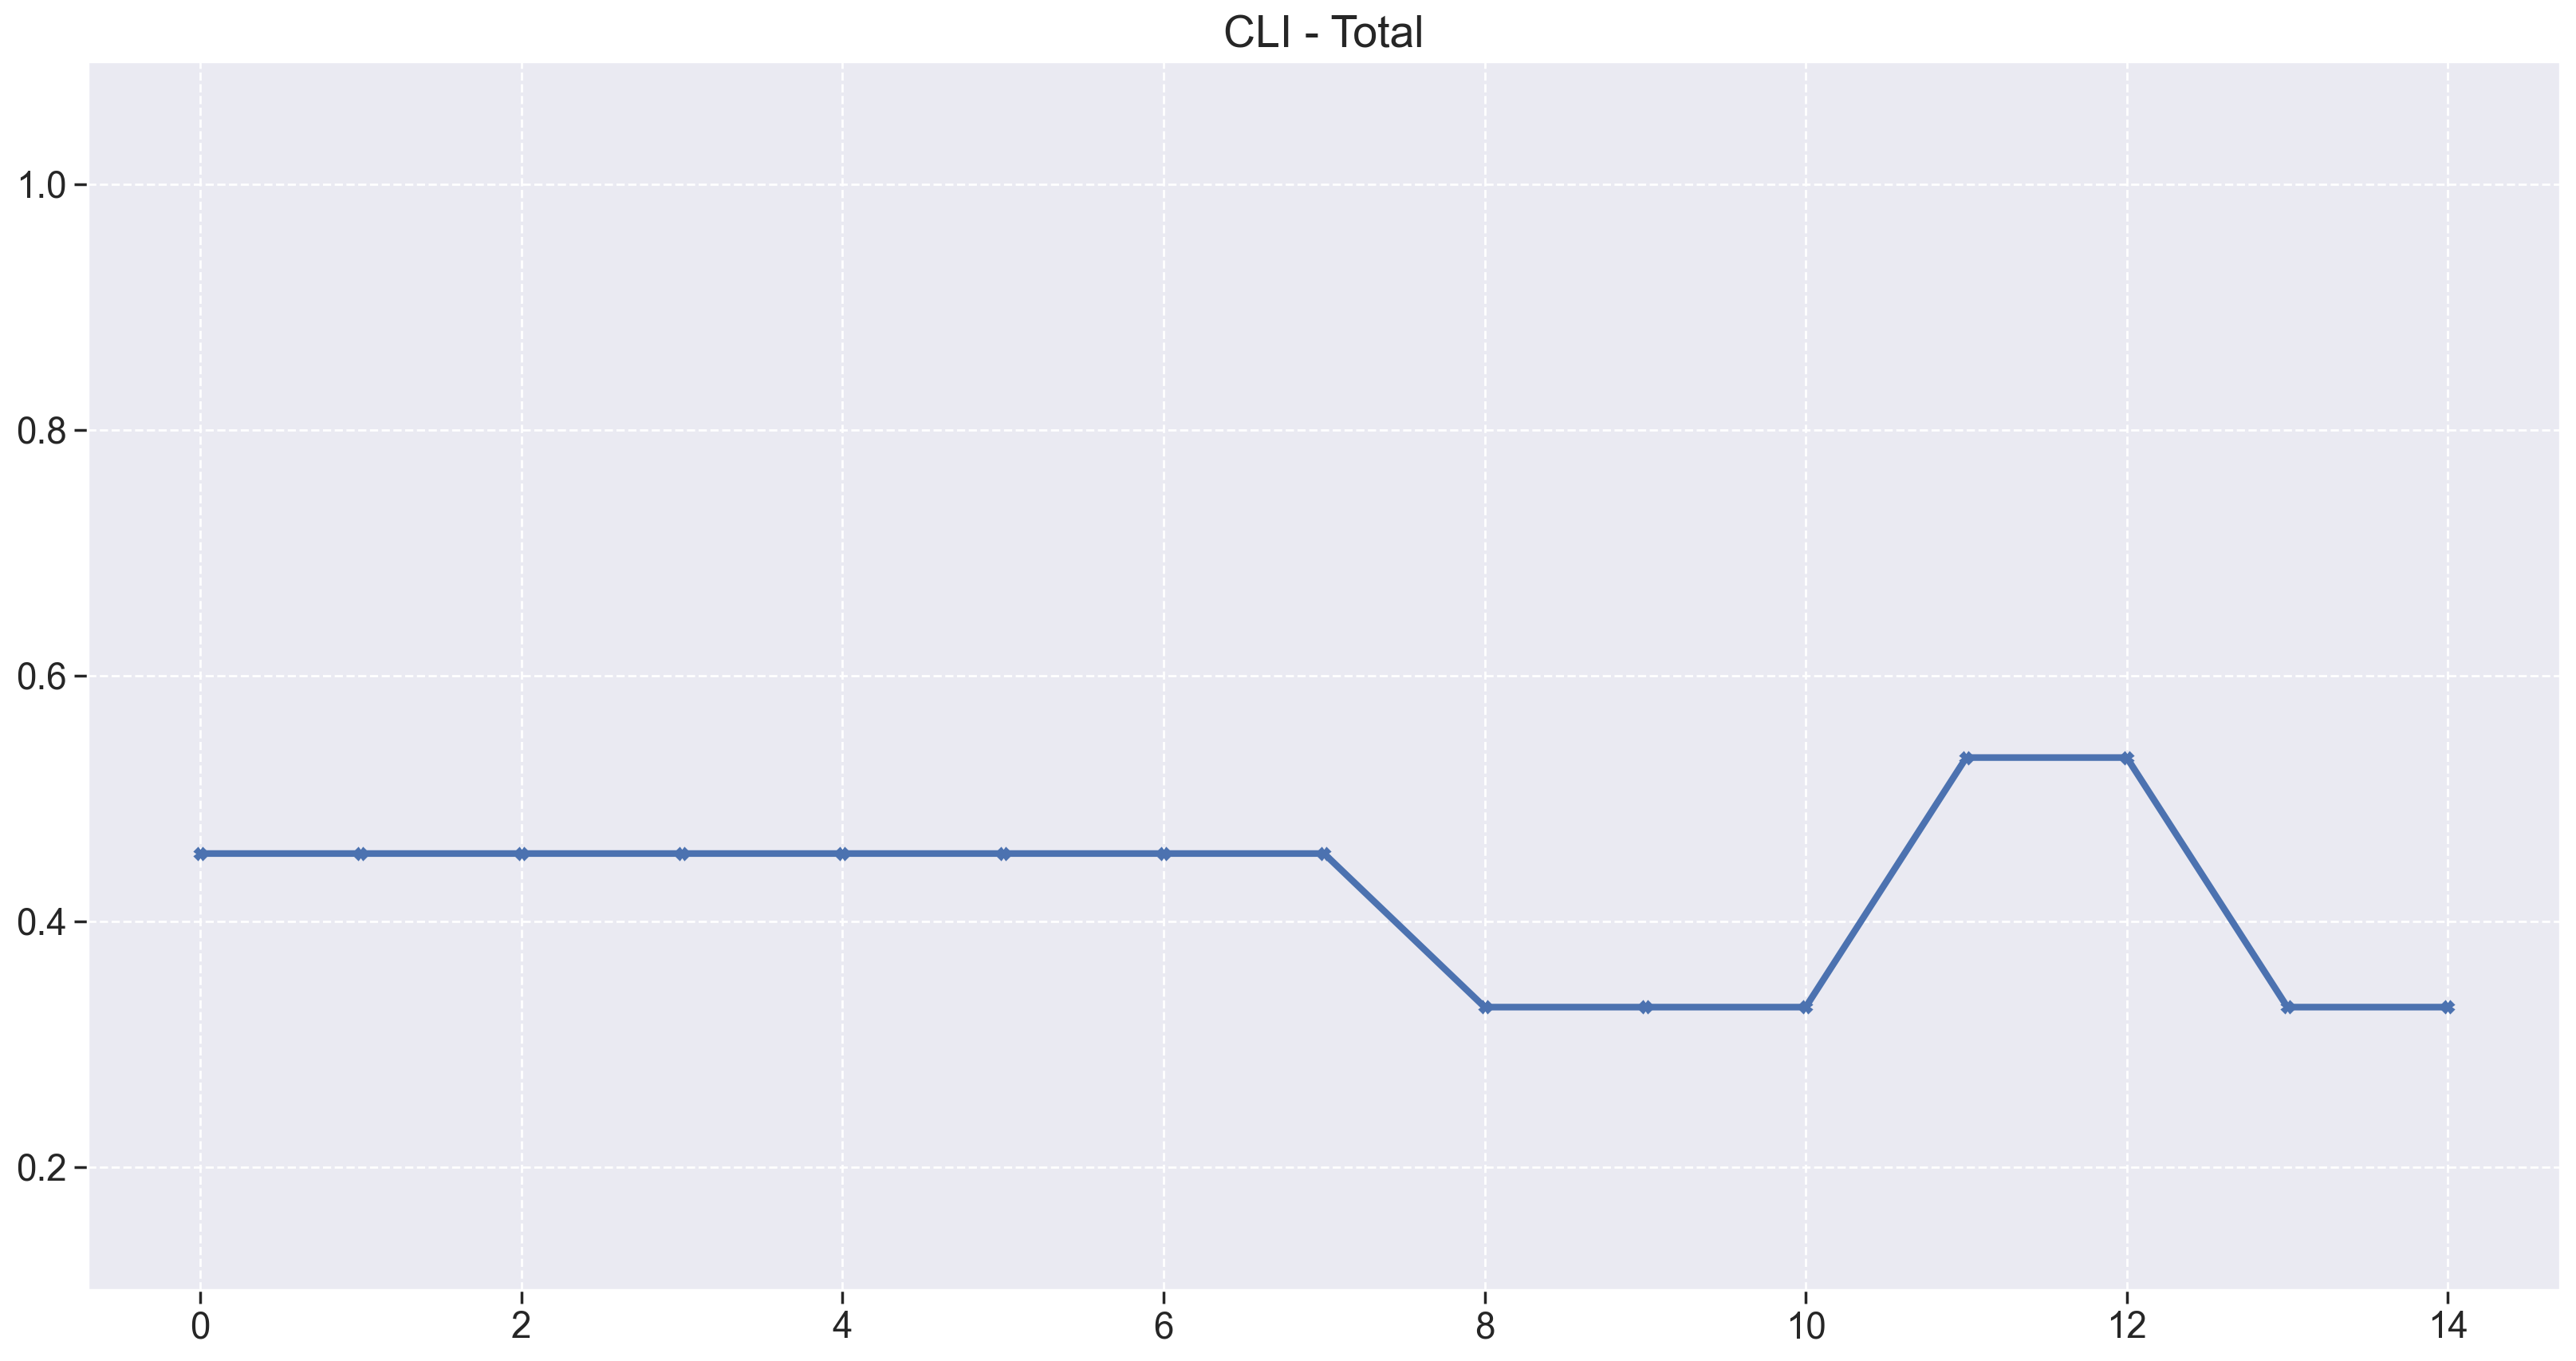

Front
Maintainability Stats
    mean     mode   median      std      var      min      max
0.298899 0.298993 0.298993 0.001757 0.000003 0.295714 0.302315
Reliability Stats
    mean     mode   median      std      var      min     max
0.443484 0.446309 0.446309 0.007332 0.000054 0.427215 0.45302


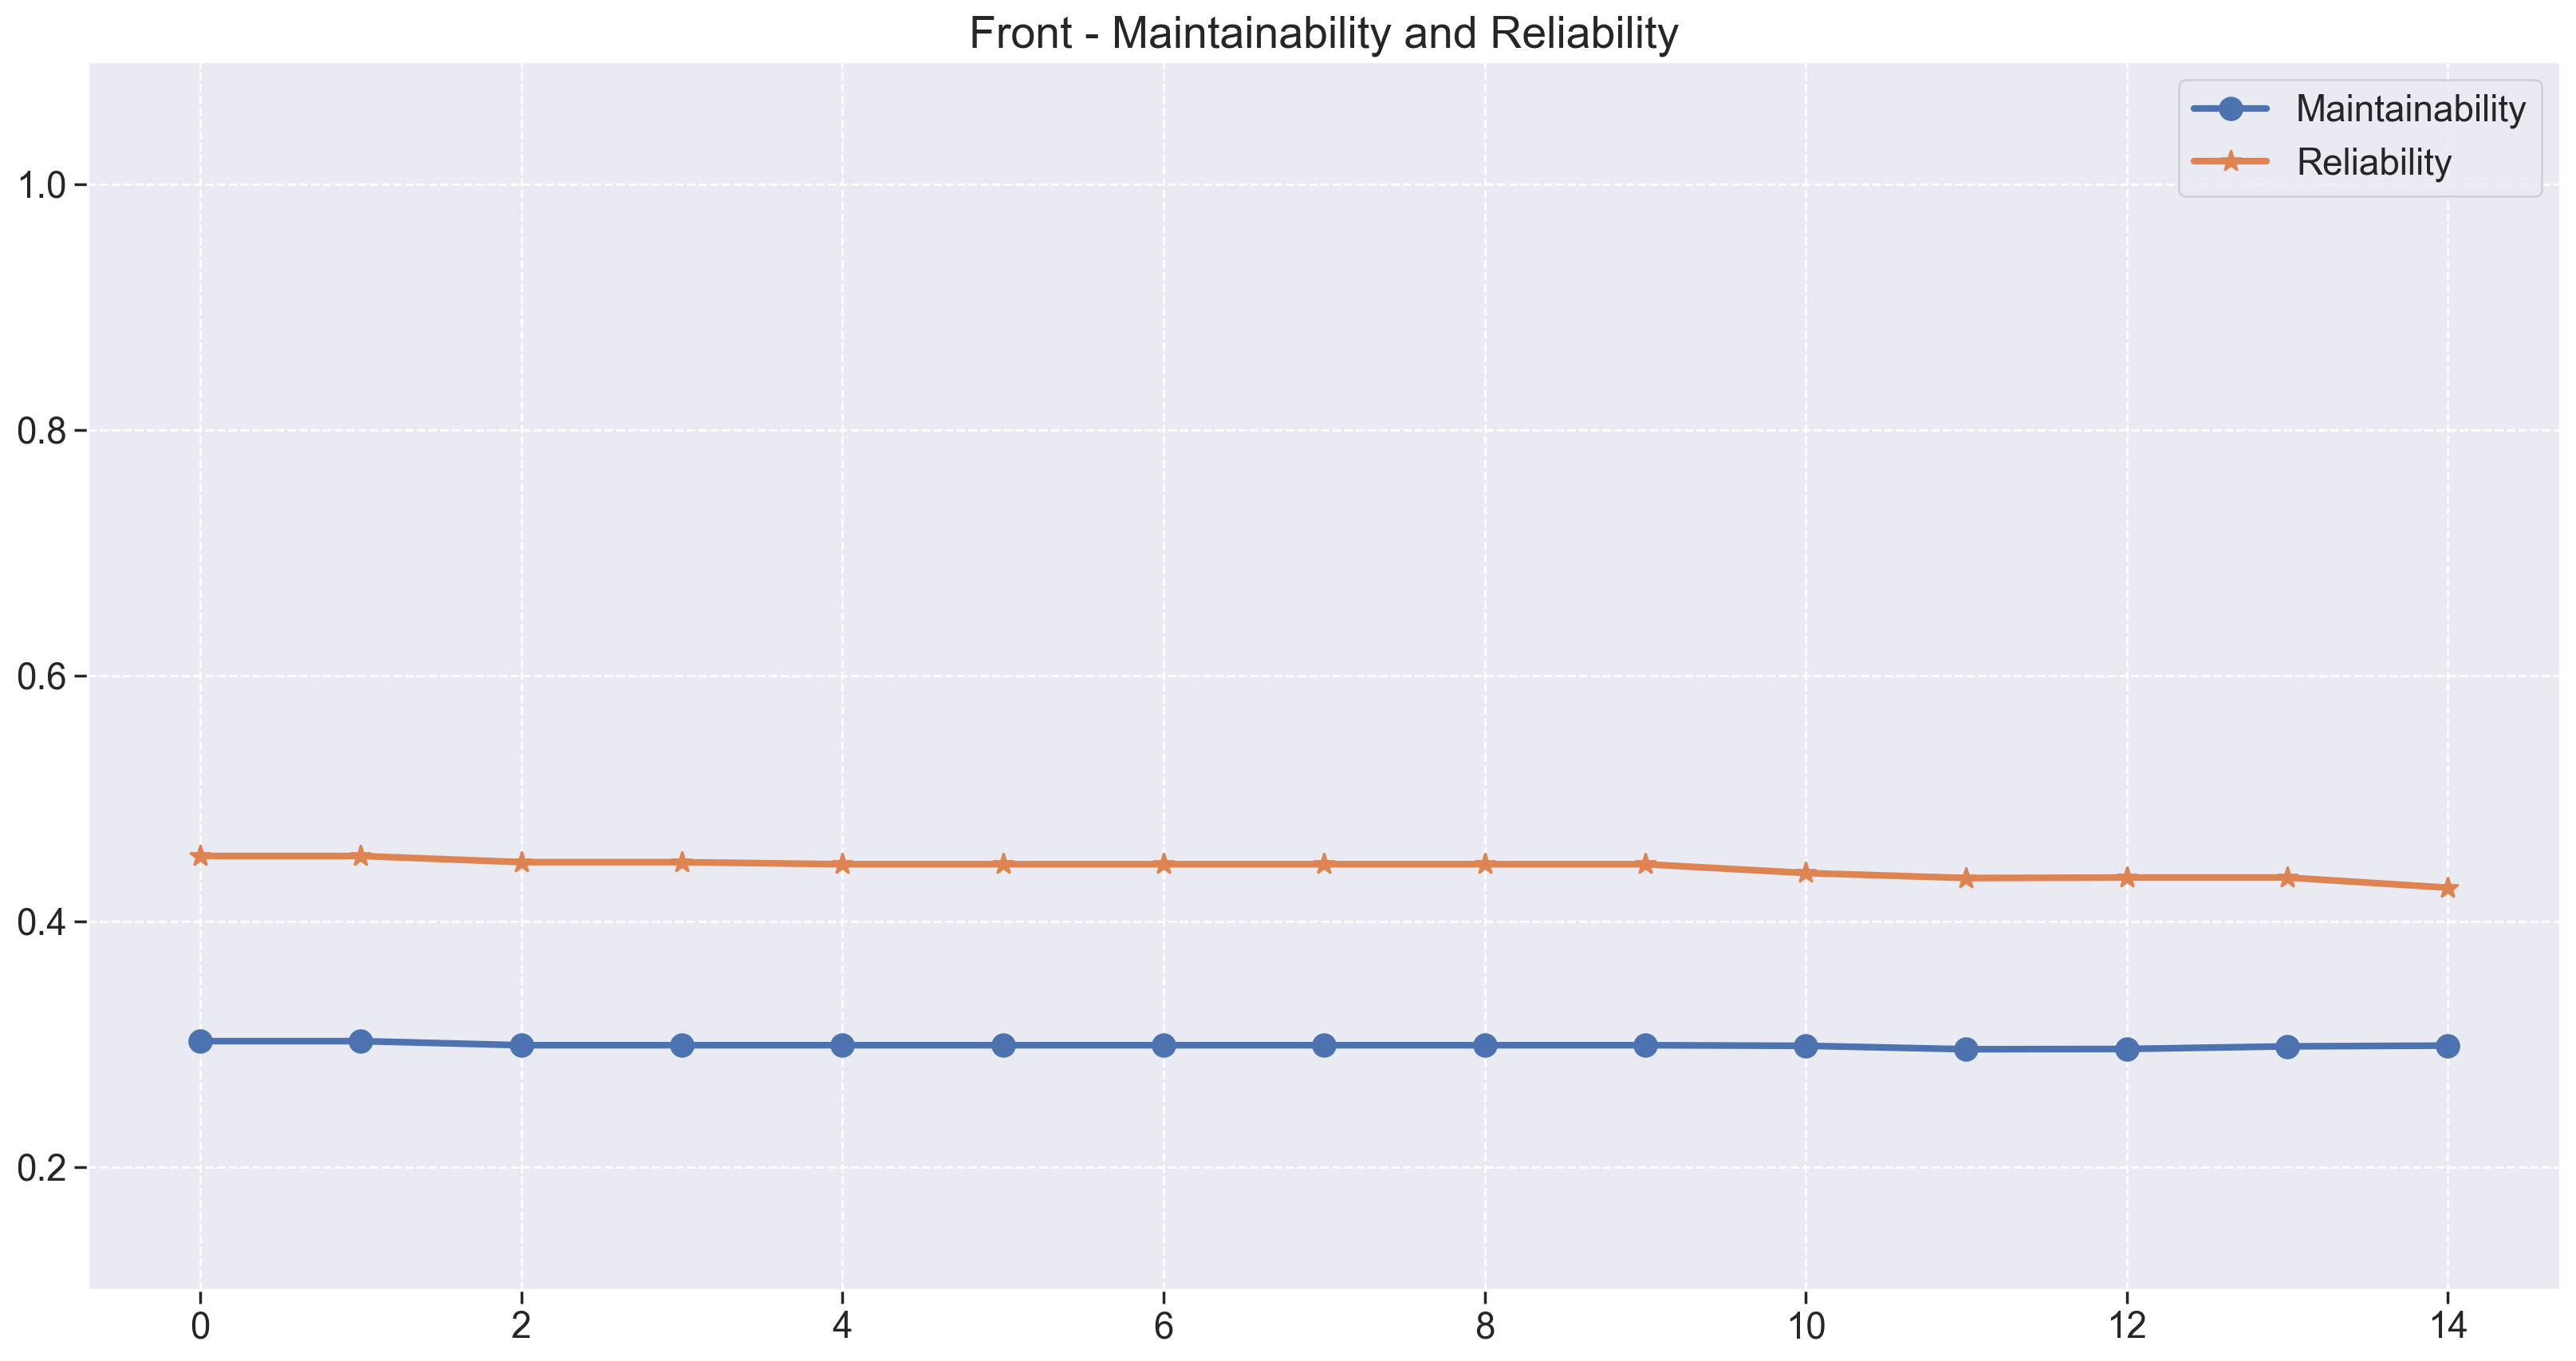

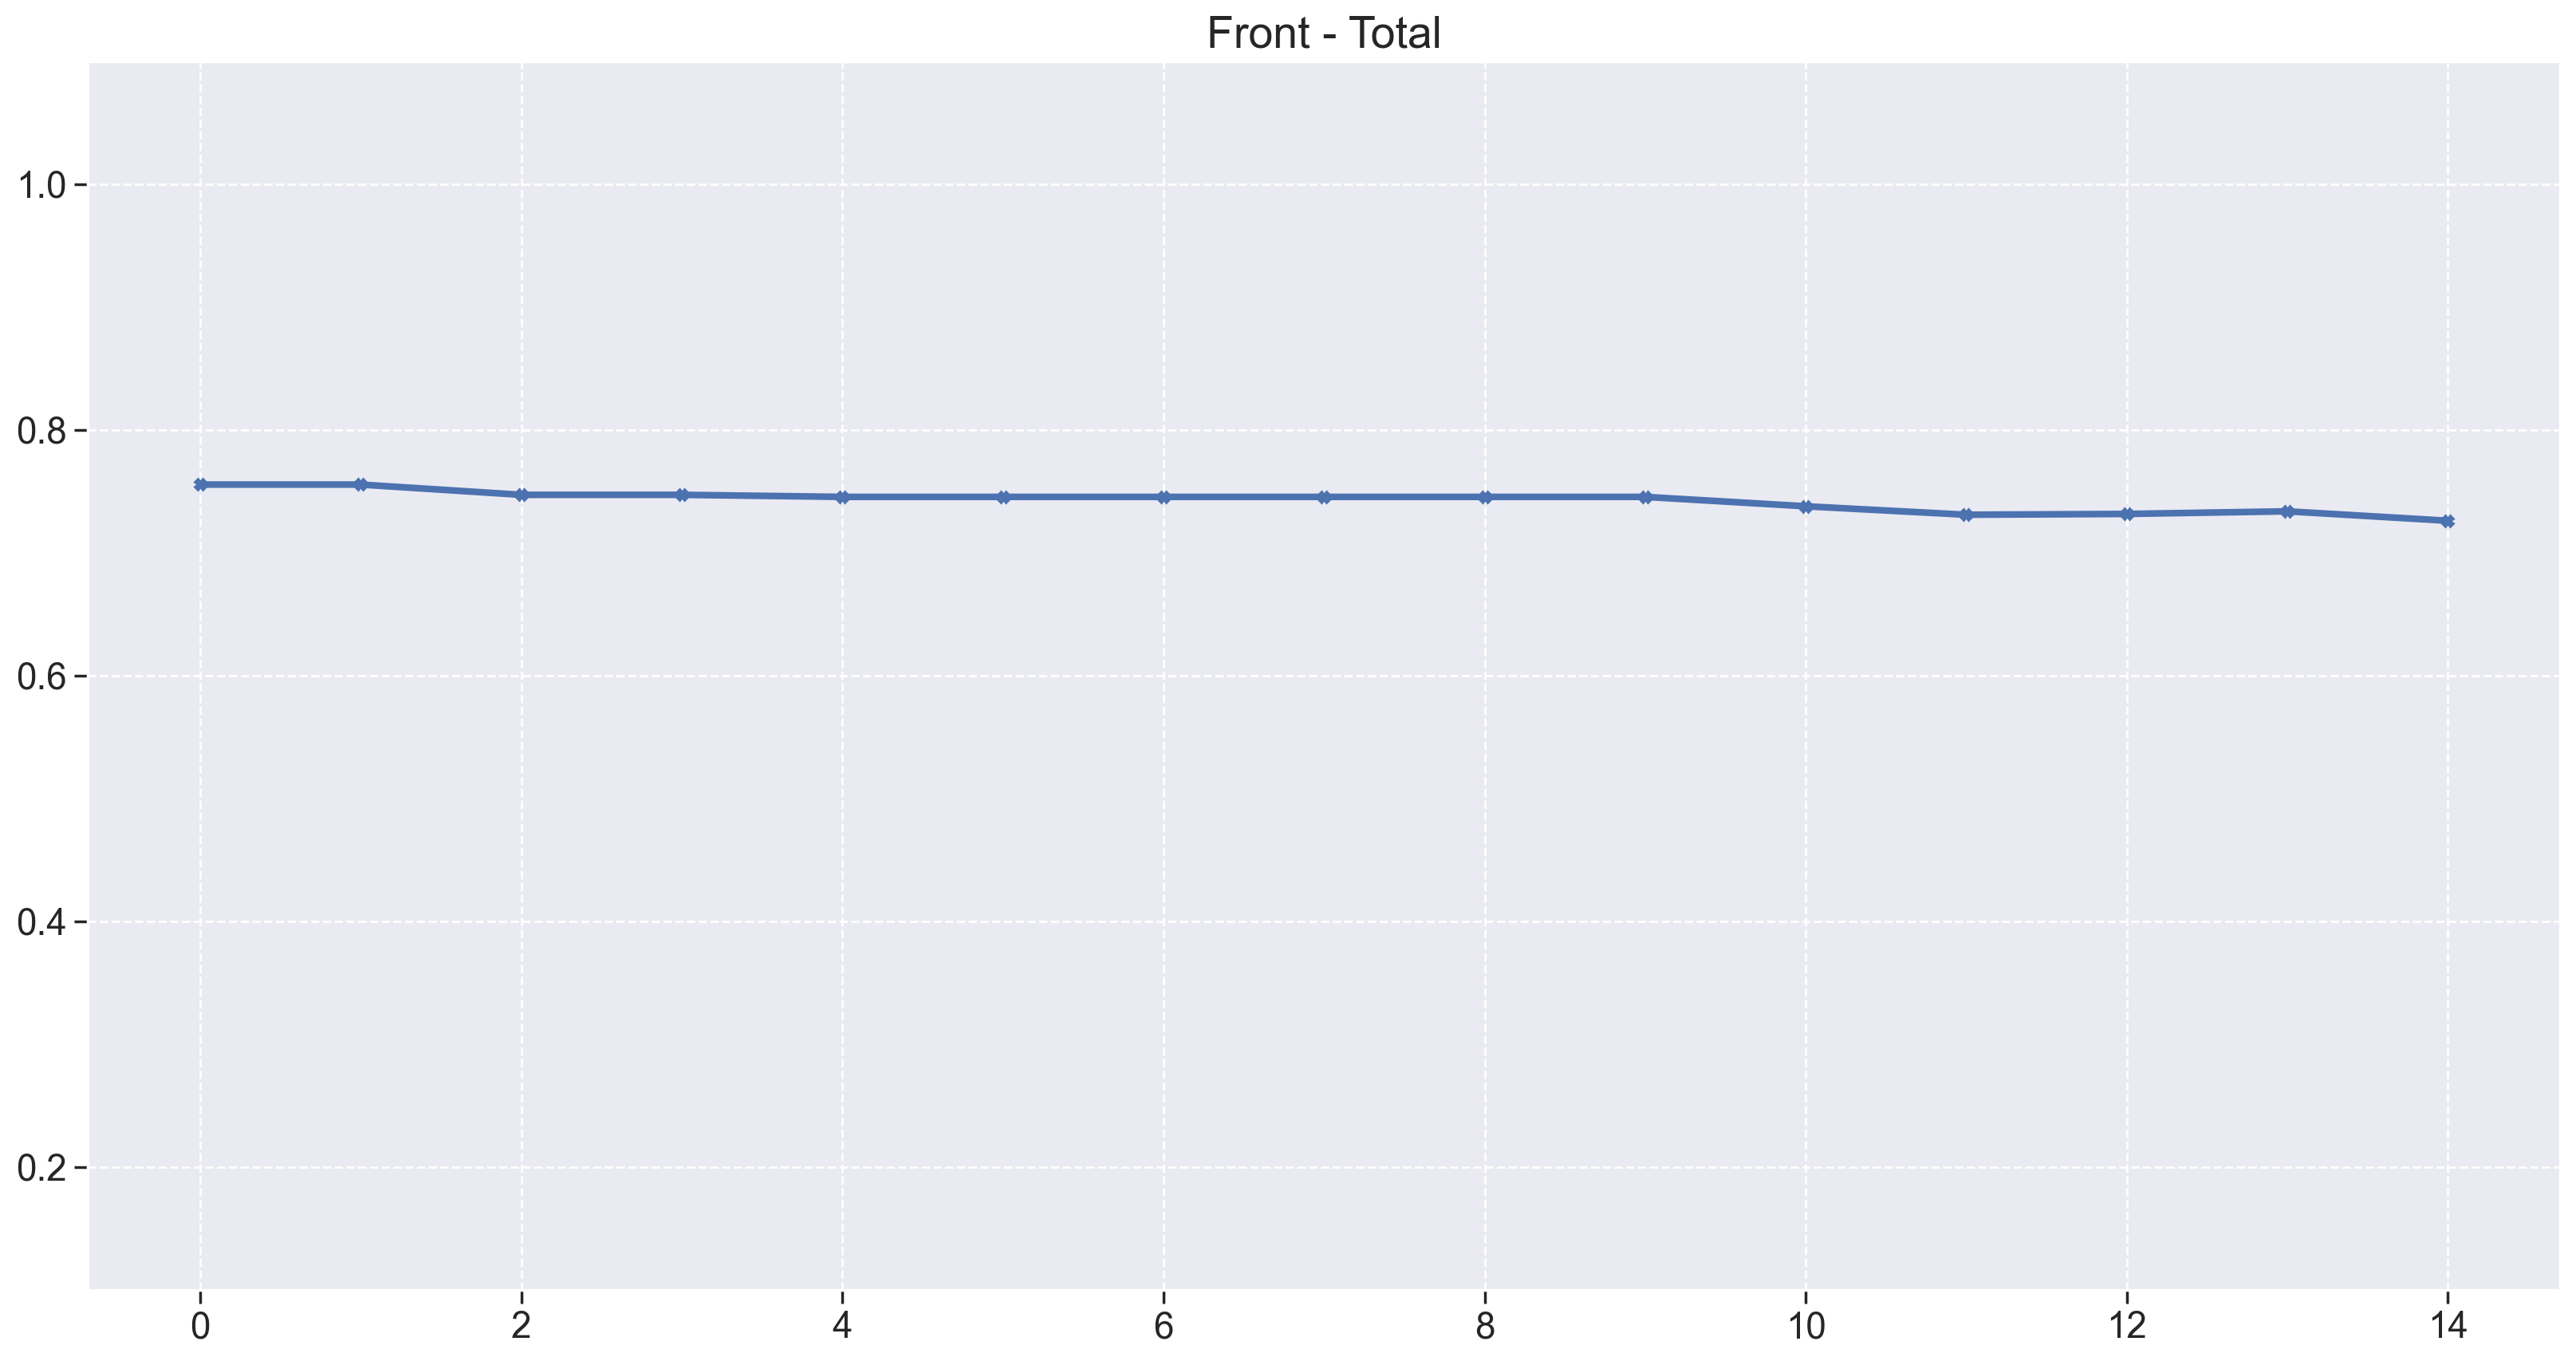

Core
Maintainability Stats
 mean     mode   median      std      var      min  max
0.315 0.309375 0.309375 0.009402 0.000088 0.309375 0.33
Reliability Stats
    mean  mode  median     std      var   min  max
0.414773   0.5     0.5 0.16085 0.025873 0.125  0.5


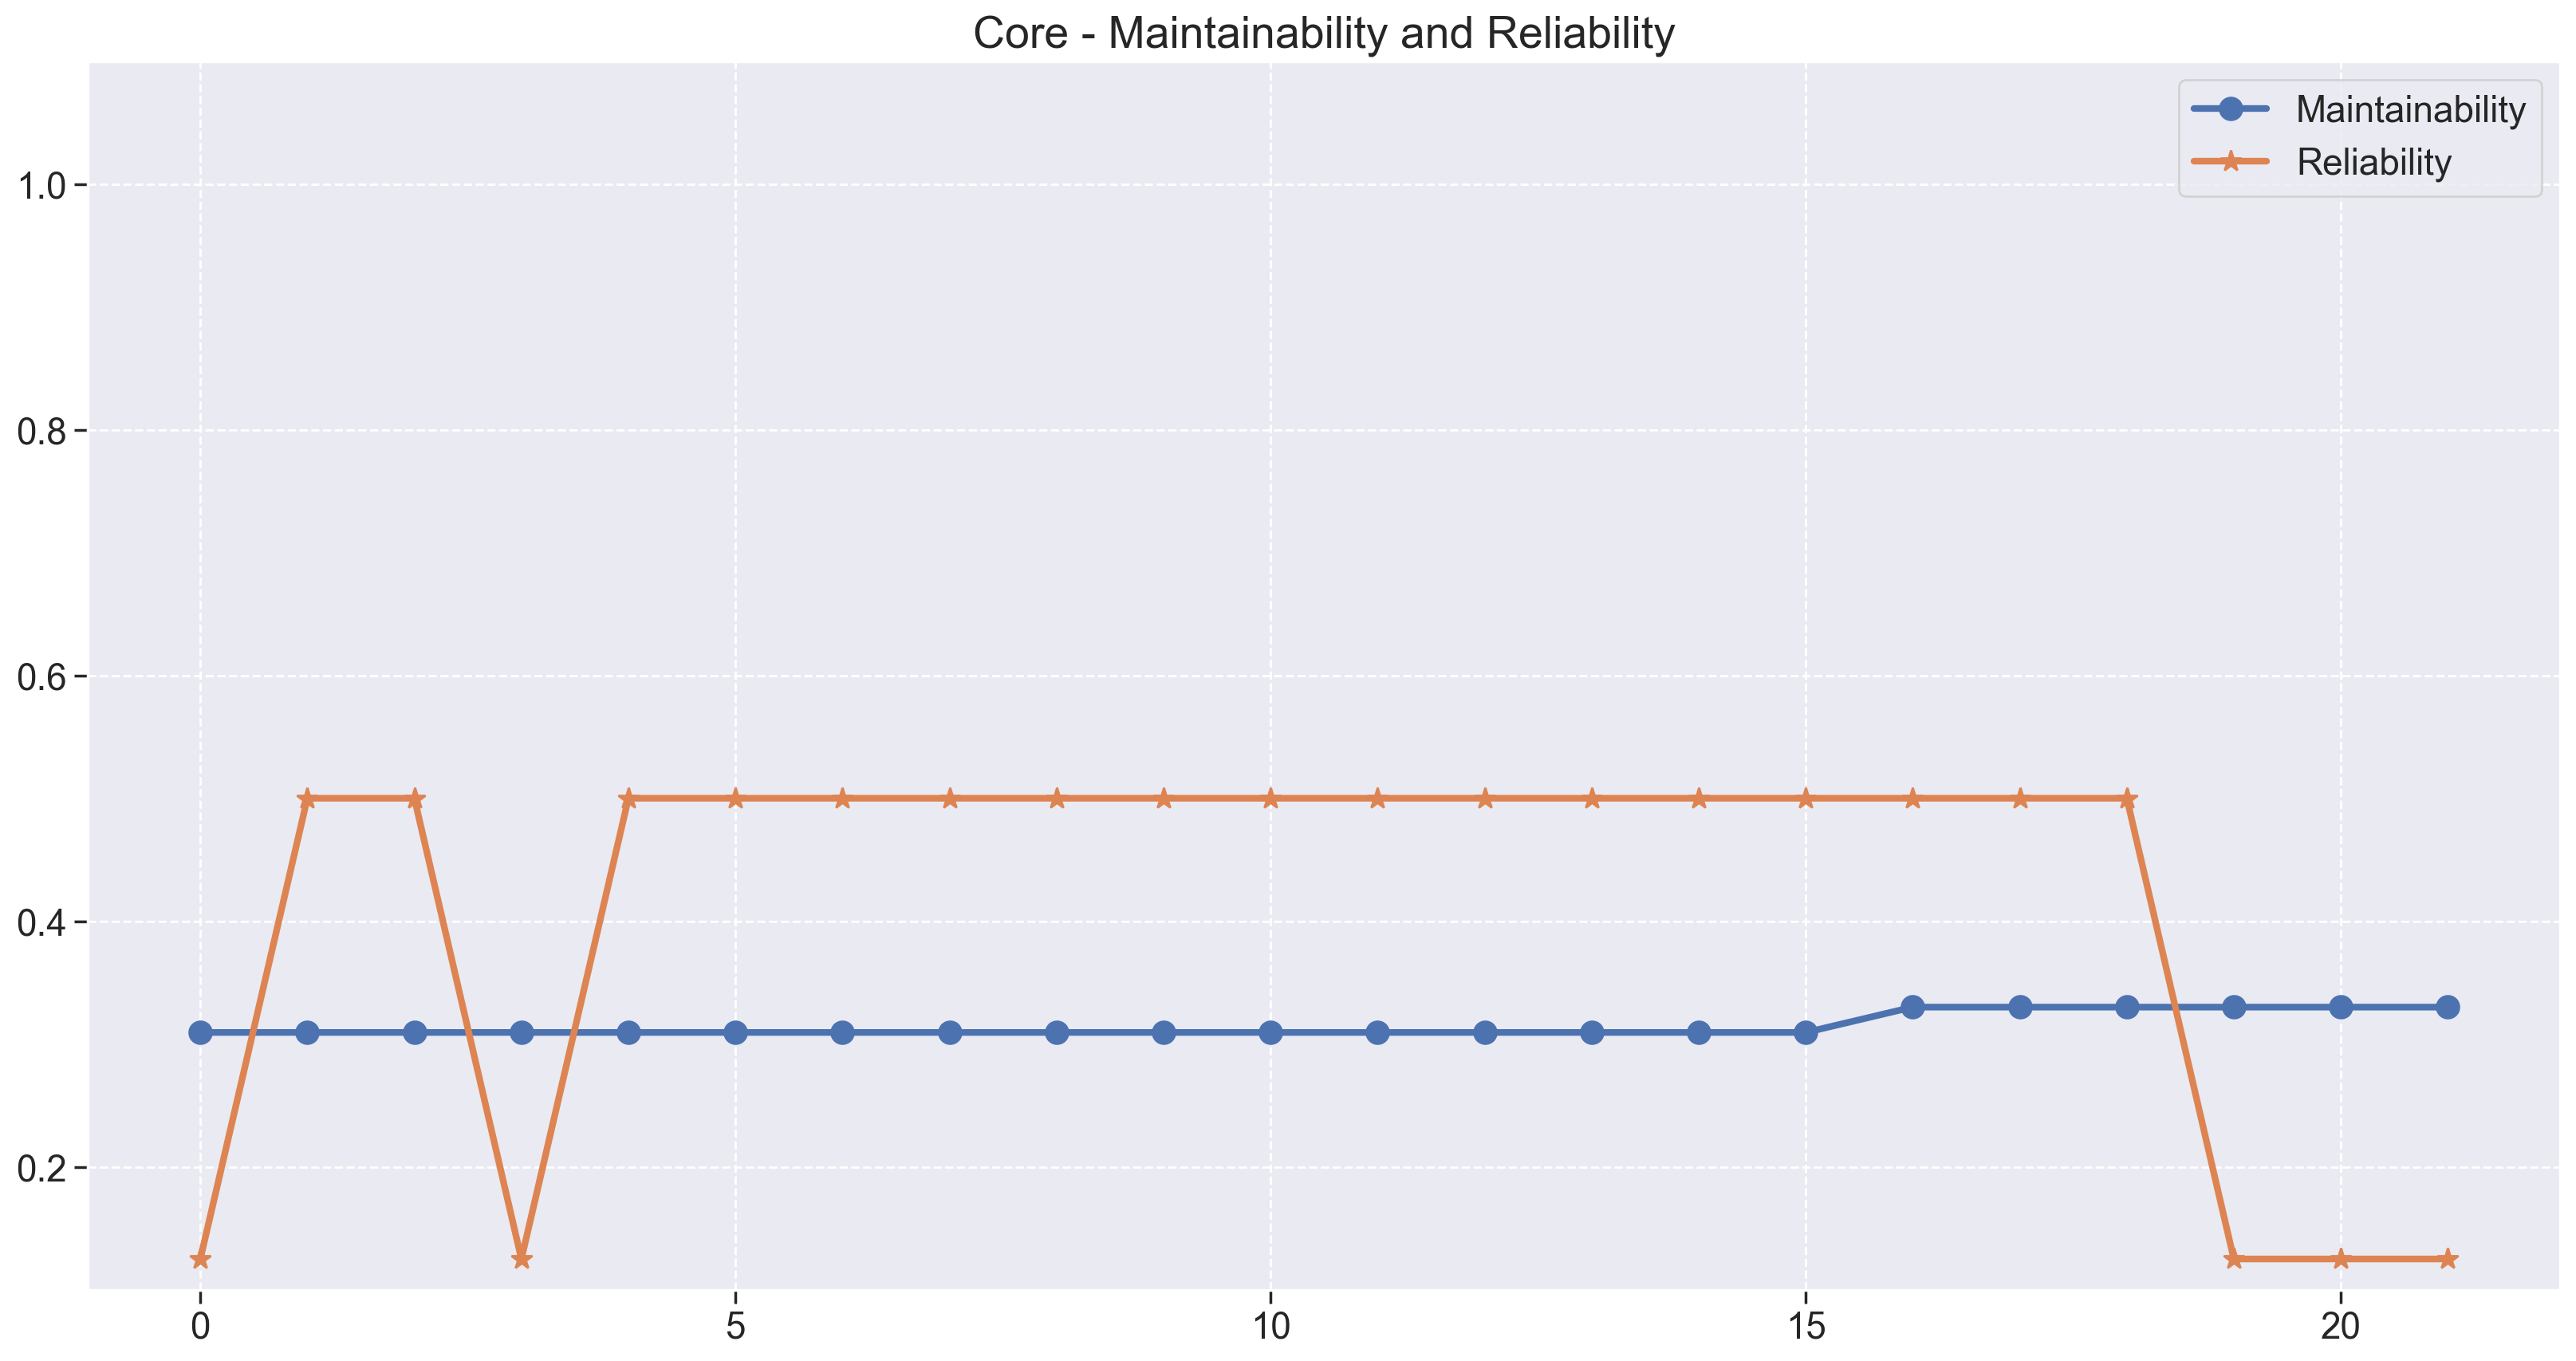

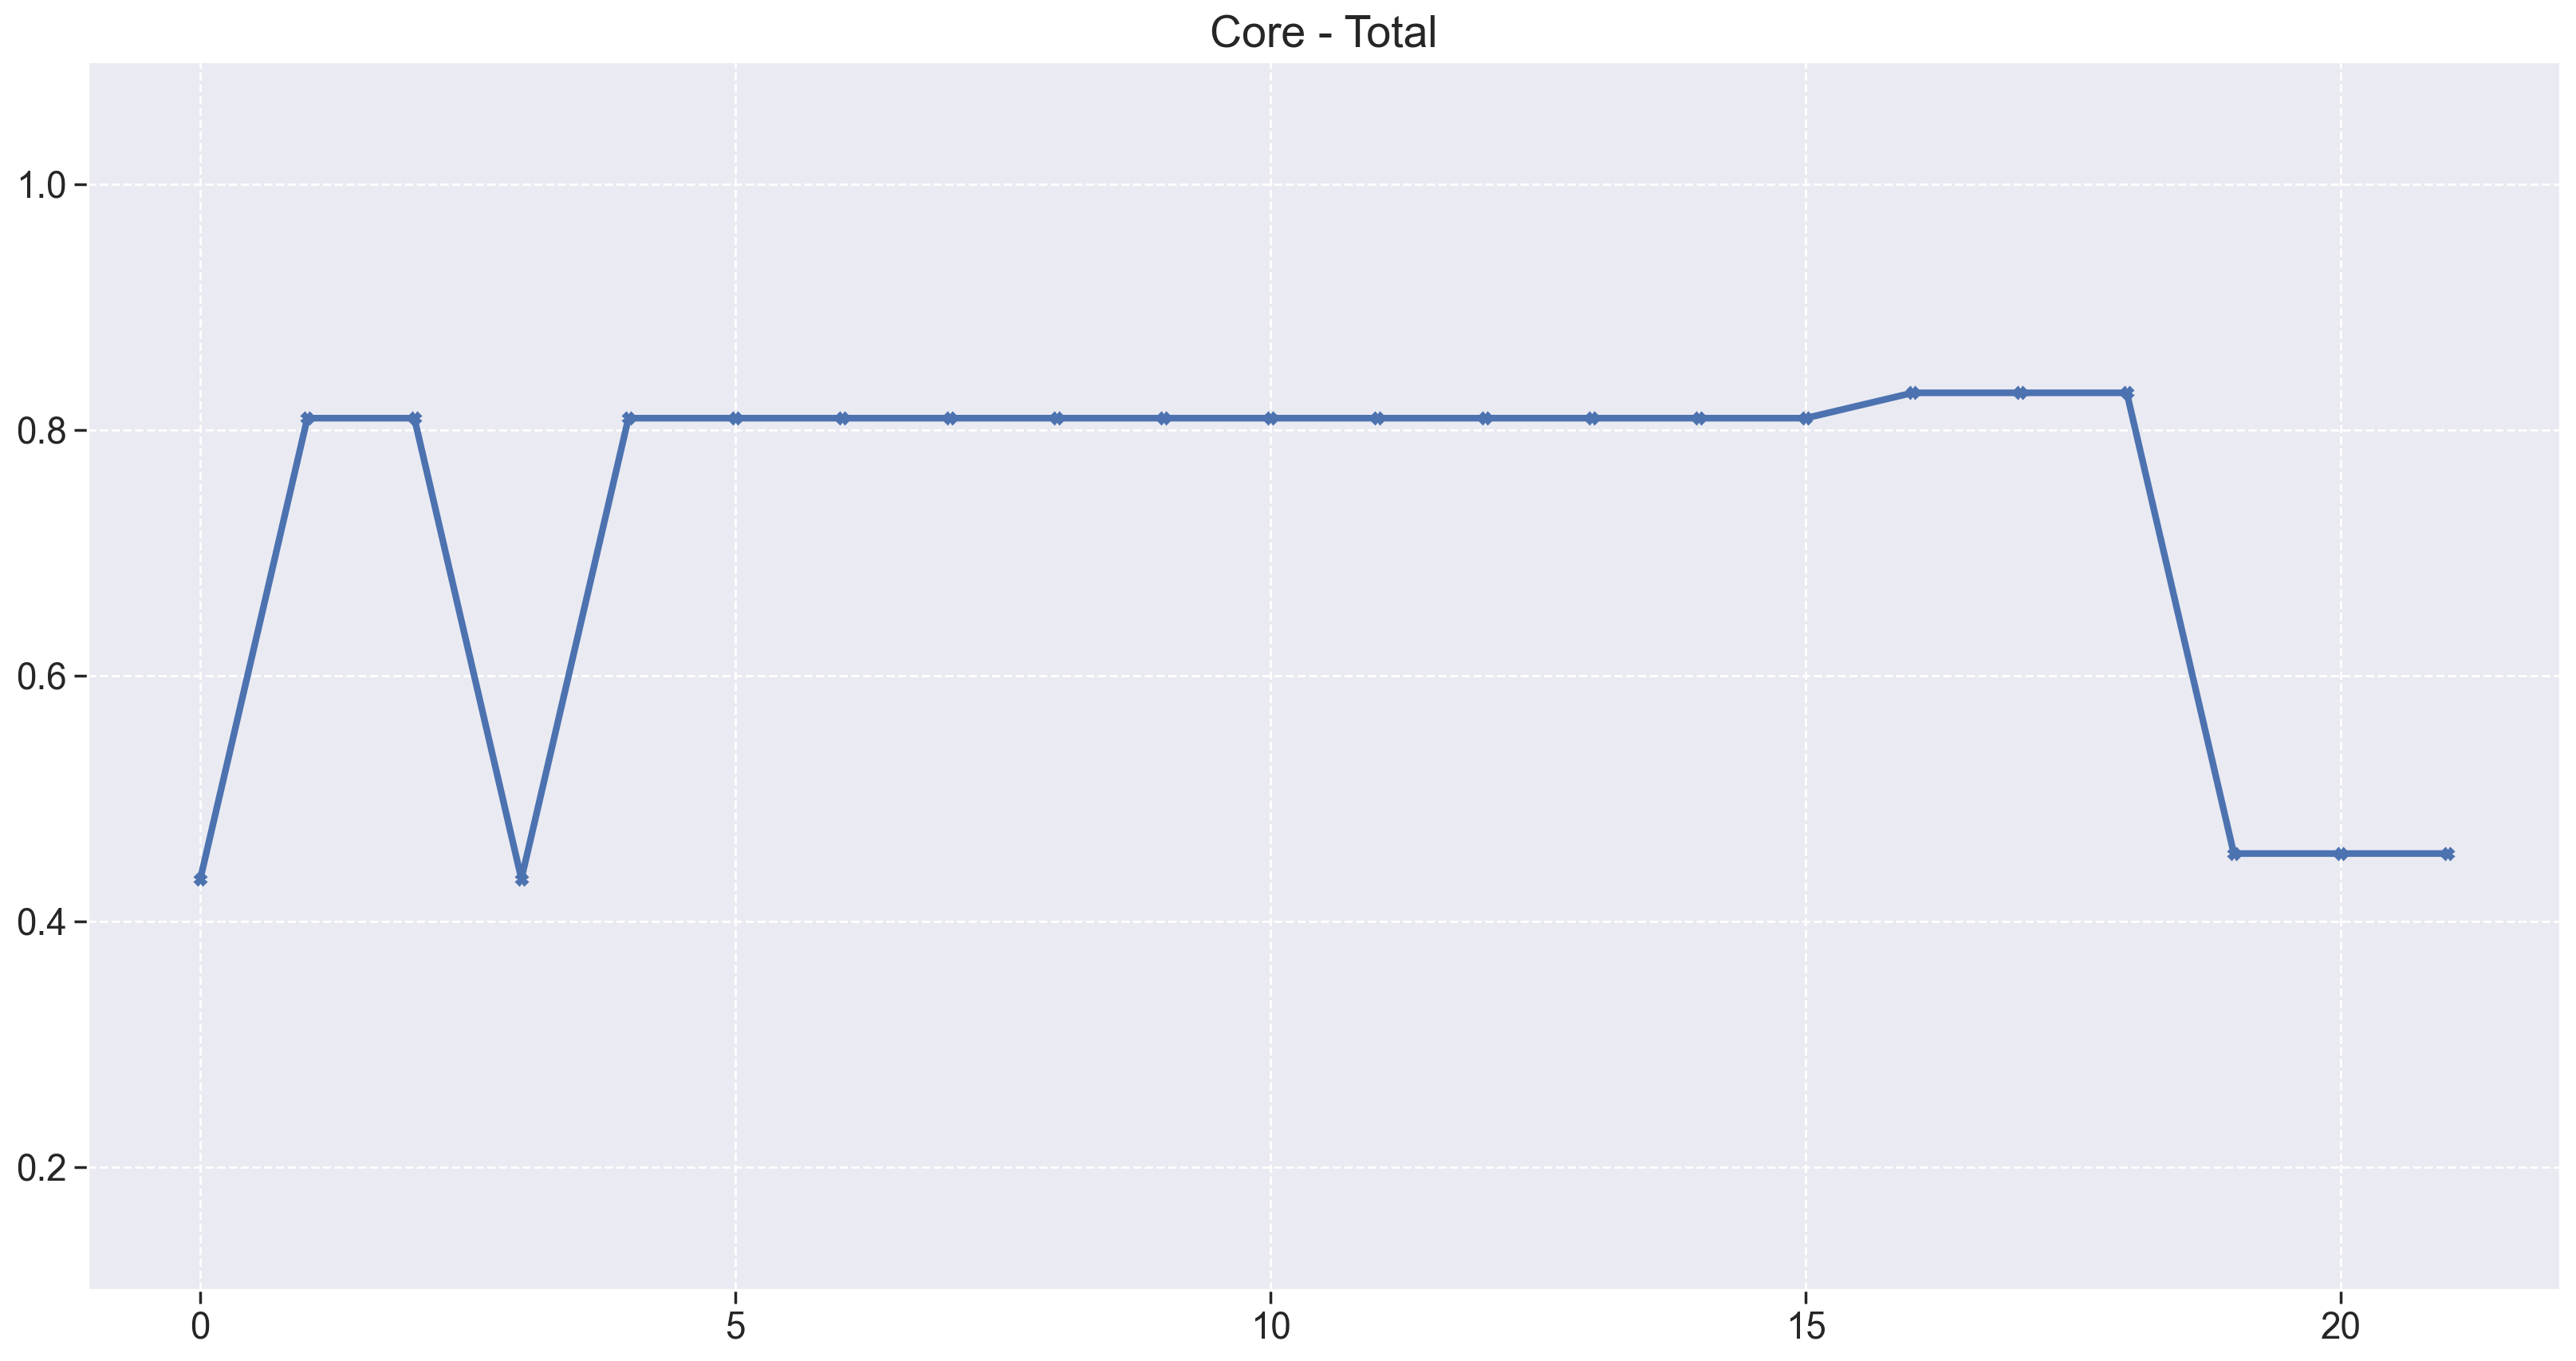

Action
Maintainability Stats
 mean  mode  median  std  var  min  max
 0.33  0.33    0.33  0.0  0.0 0.33 0.33
Reliability Stats
    mean     mode   median          std          var      min      max
0.458333 0.458333 0.458333 1.723785e-16 2.971435e-32 0.458333 0.458333


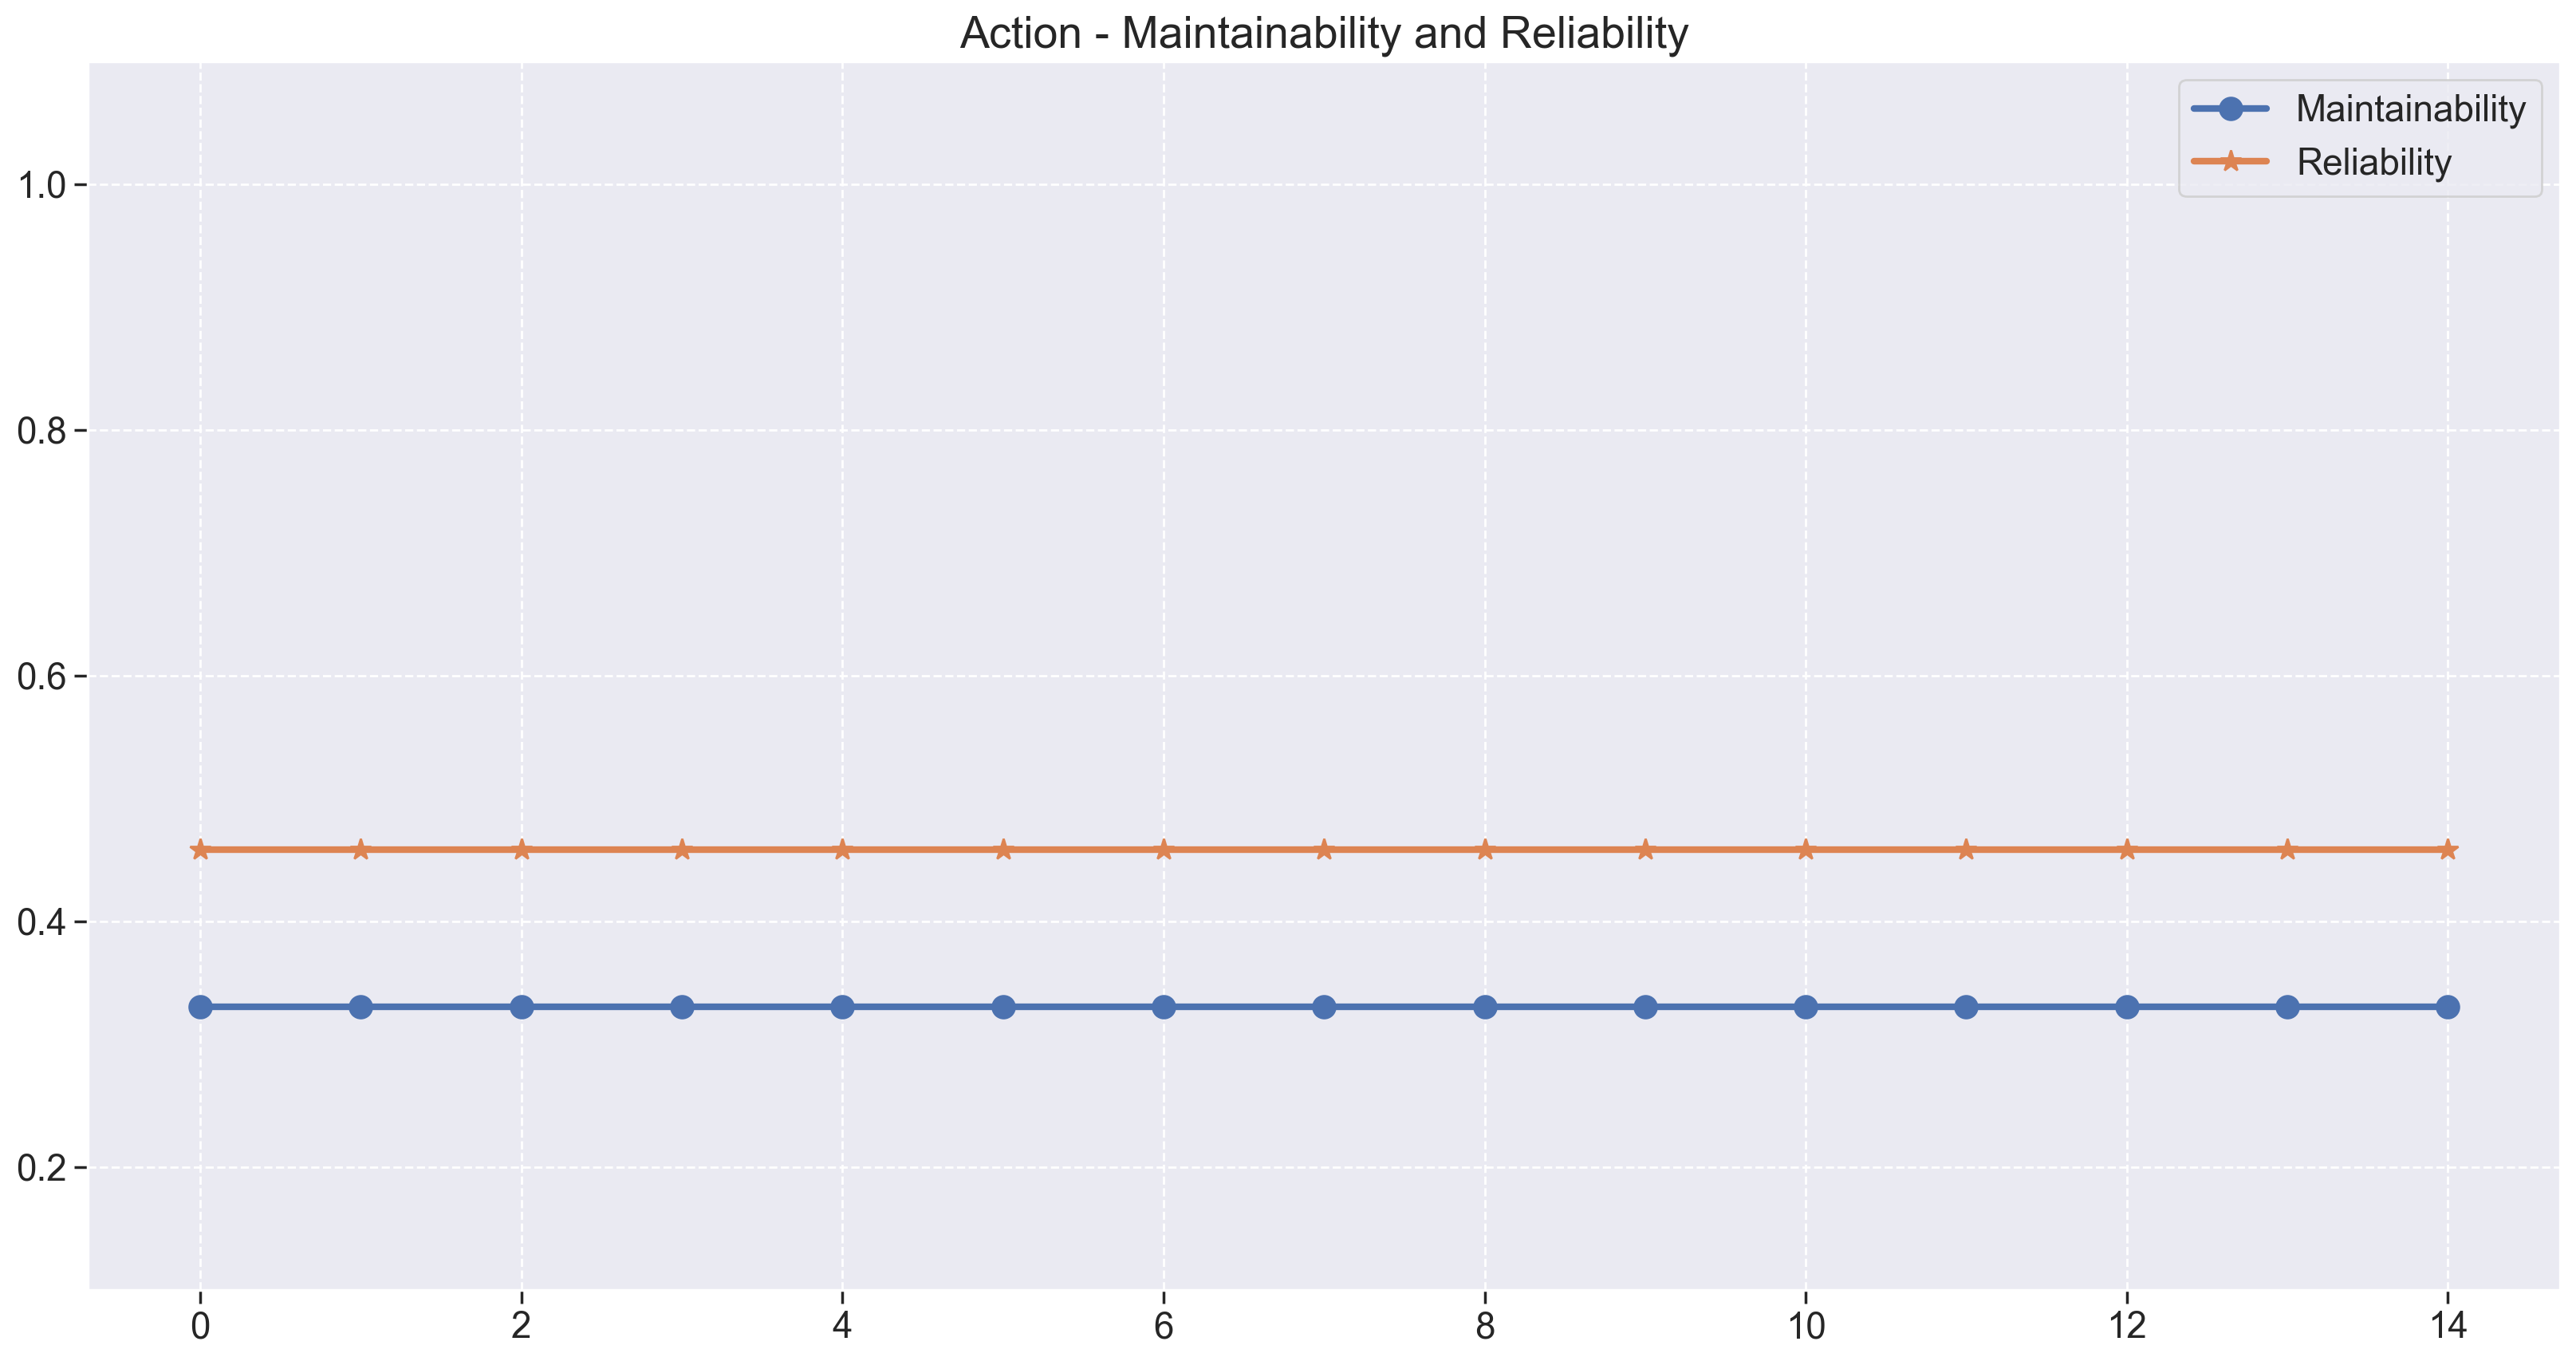

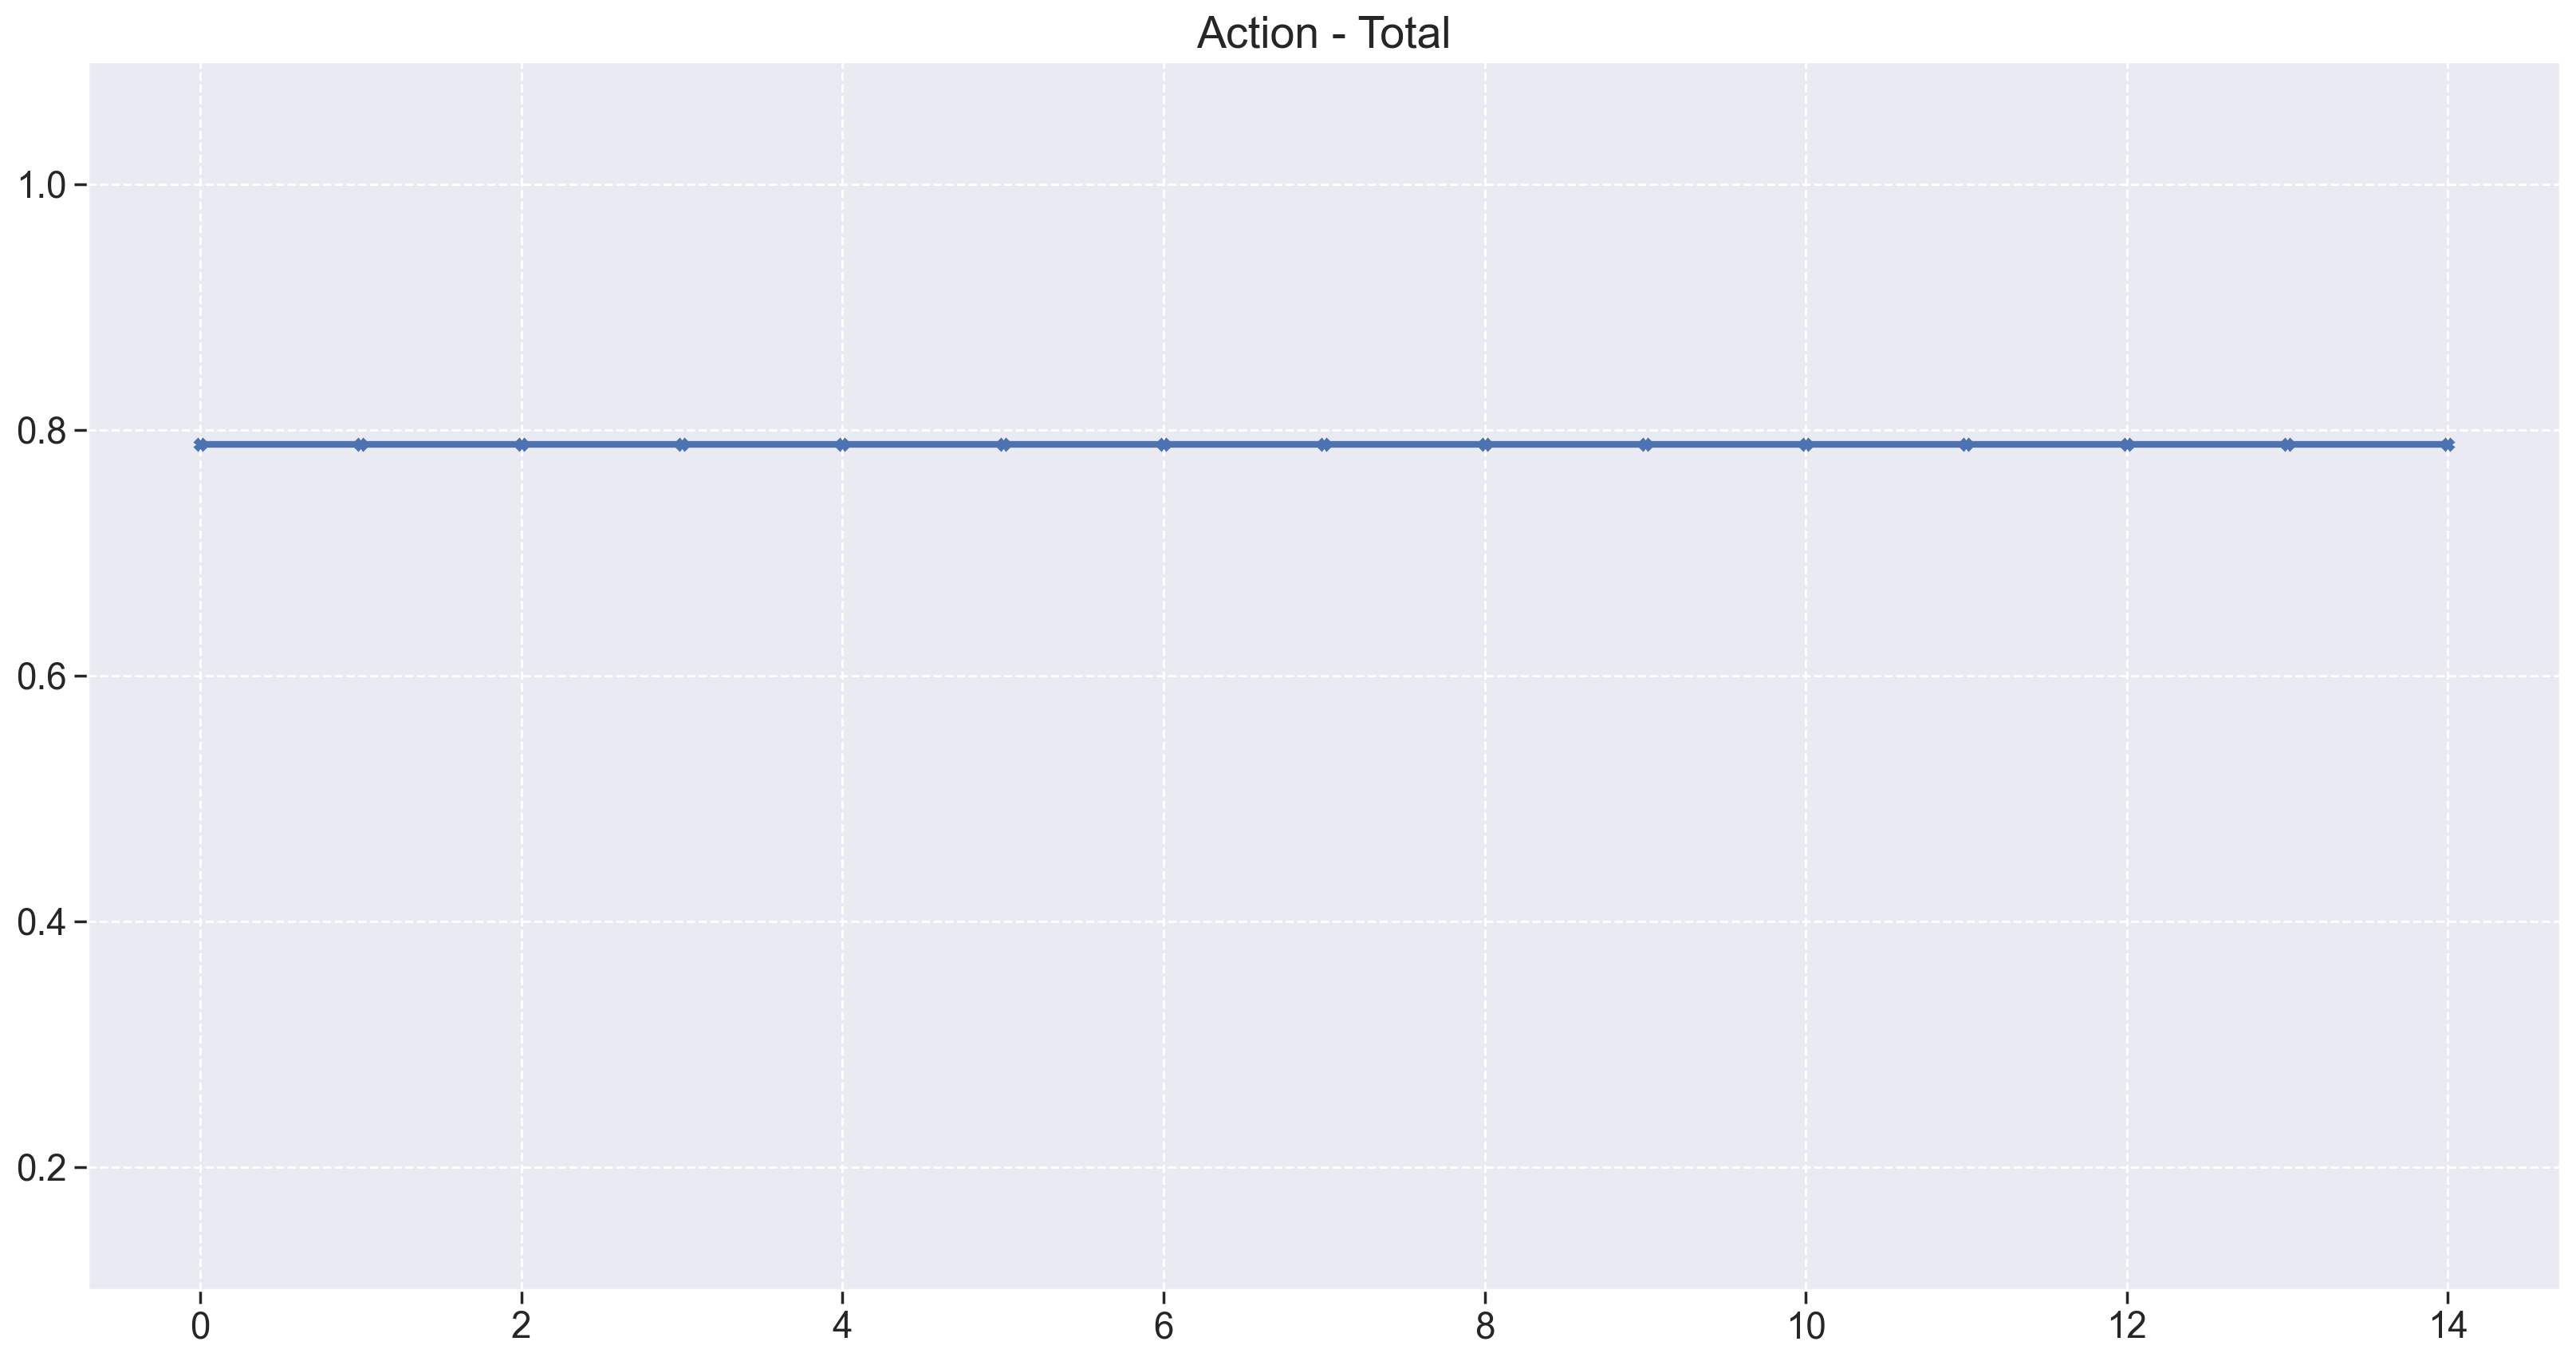

Parser
Maintainability Stats
 mean  mode  median std var   min   max
0.297 0.297   0.297 NaN NaN 0.297 0.297
Reliability Stats
 mean  mode  median std var  min  max
  0.5   0.5     0.5 NaN NaN  0.5  0.5


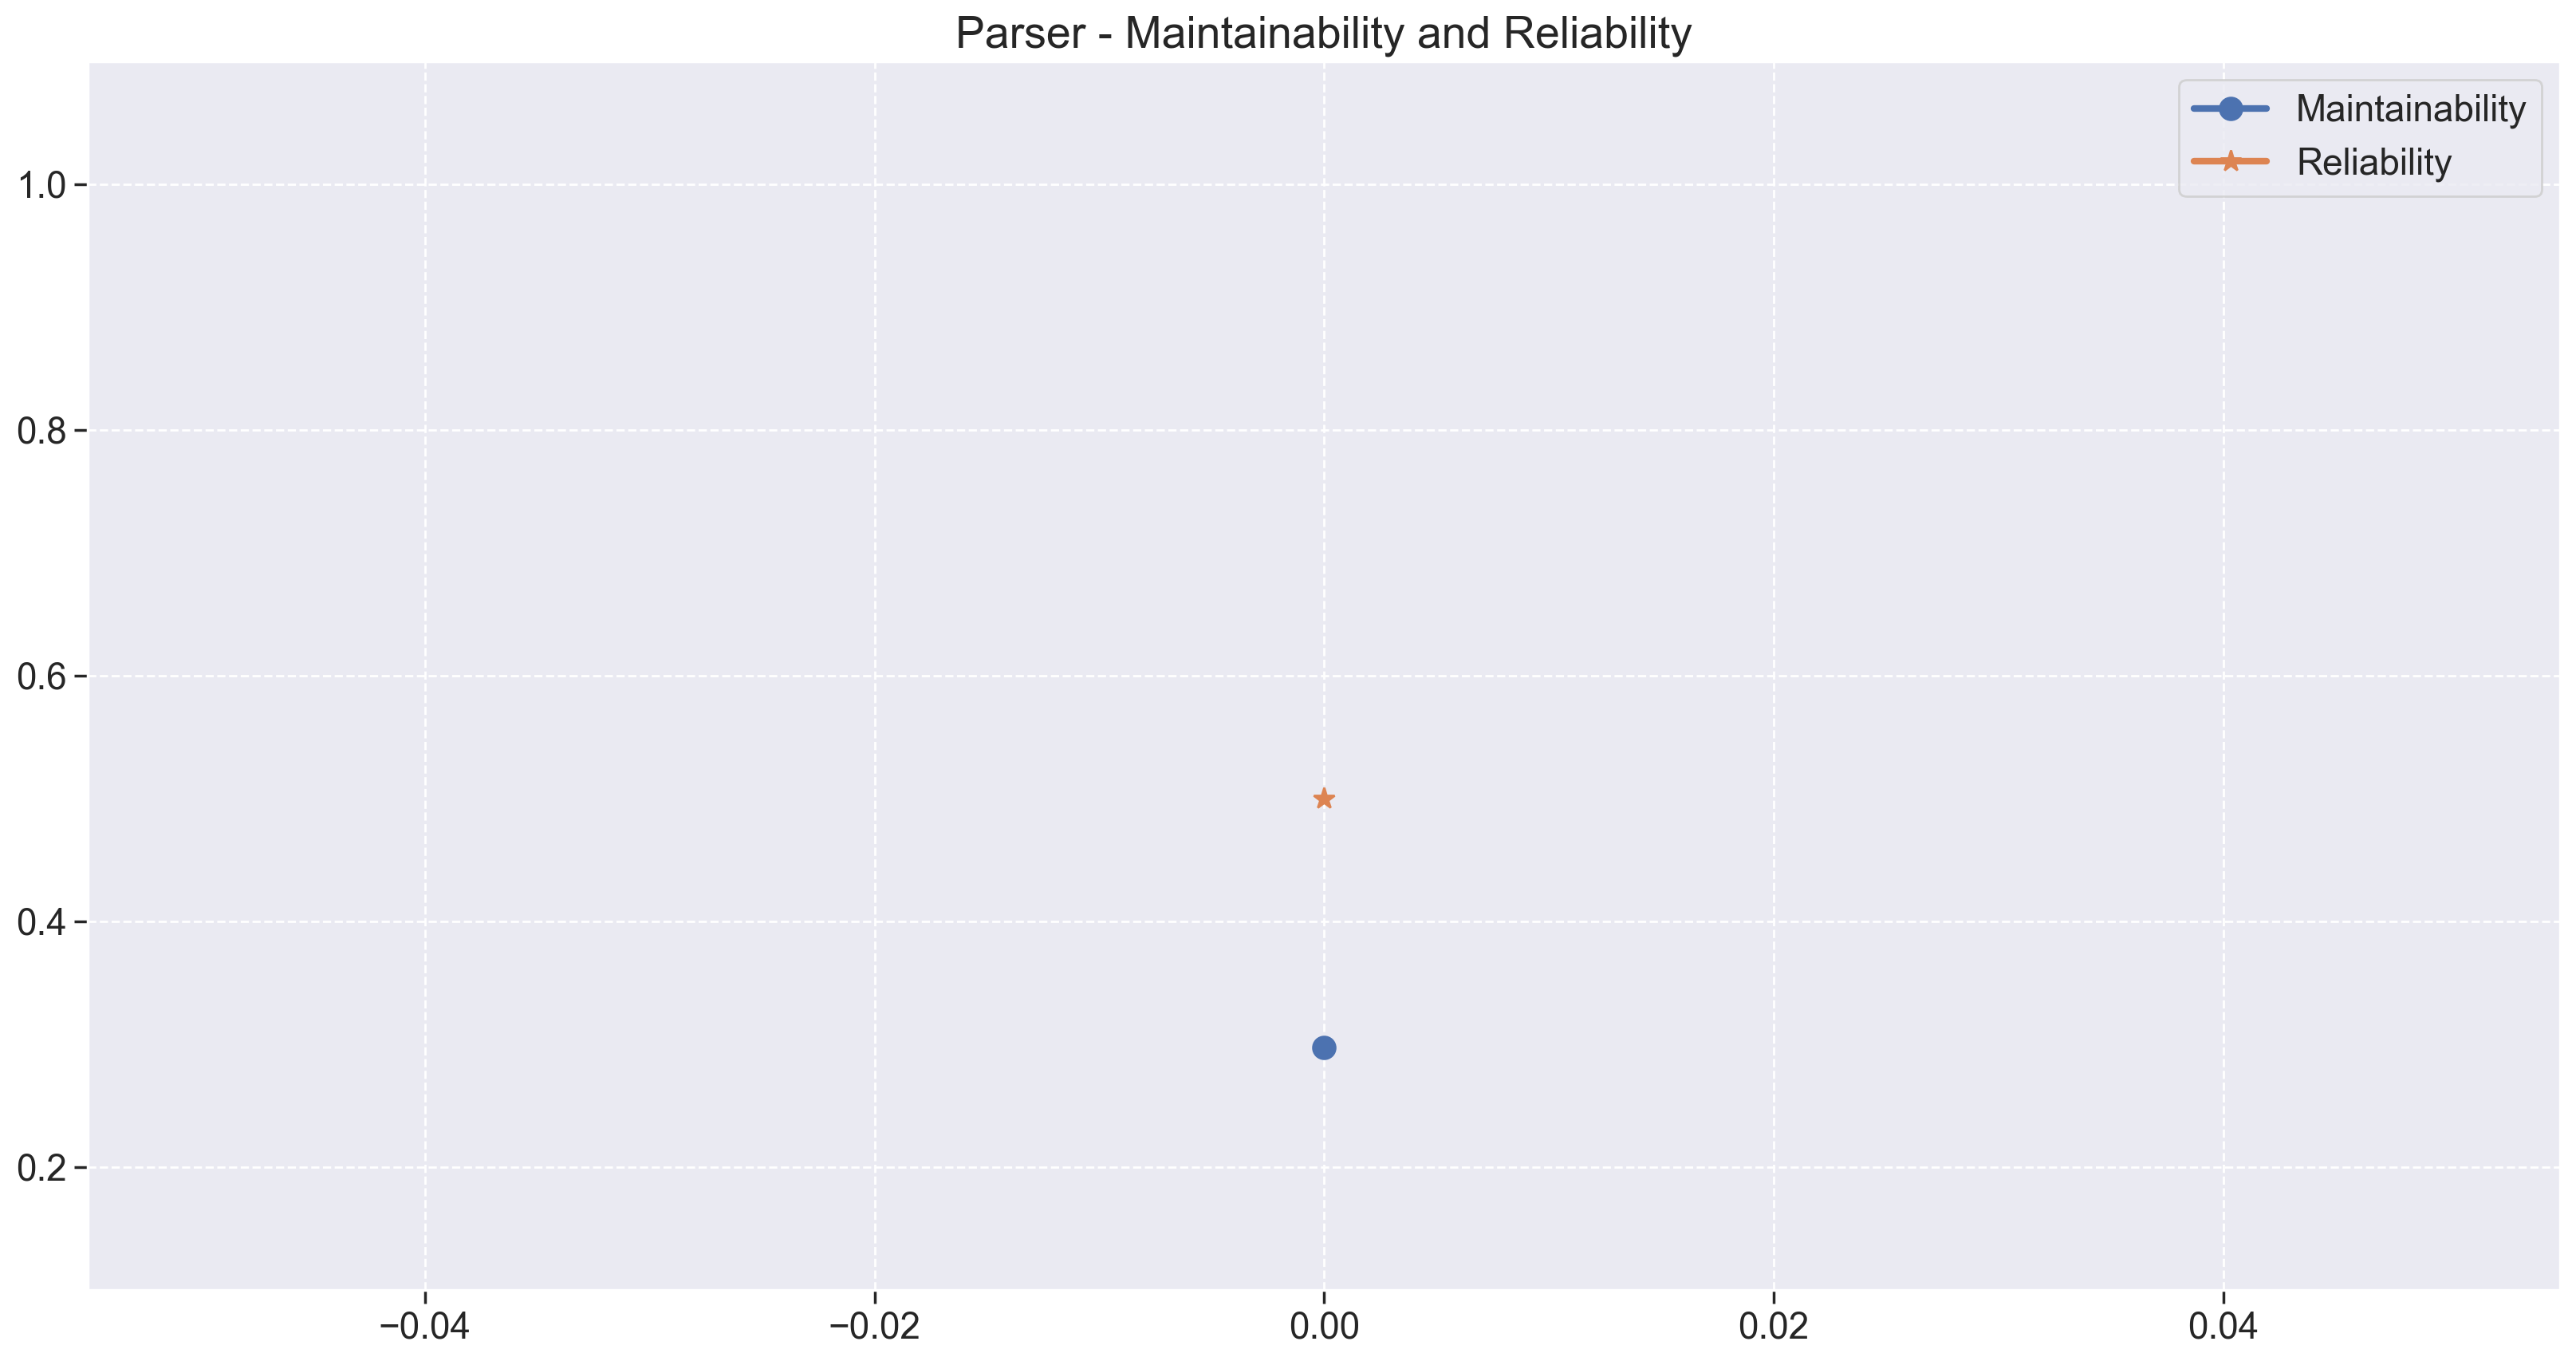

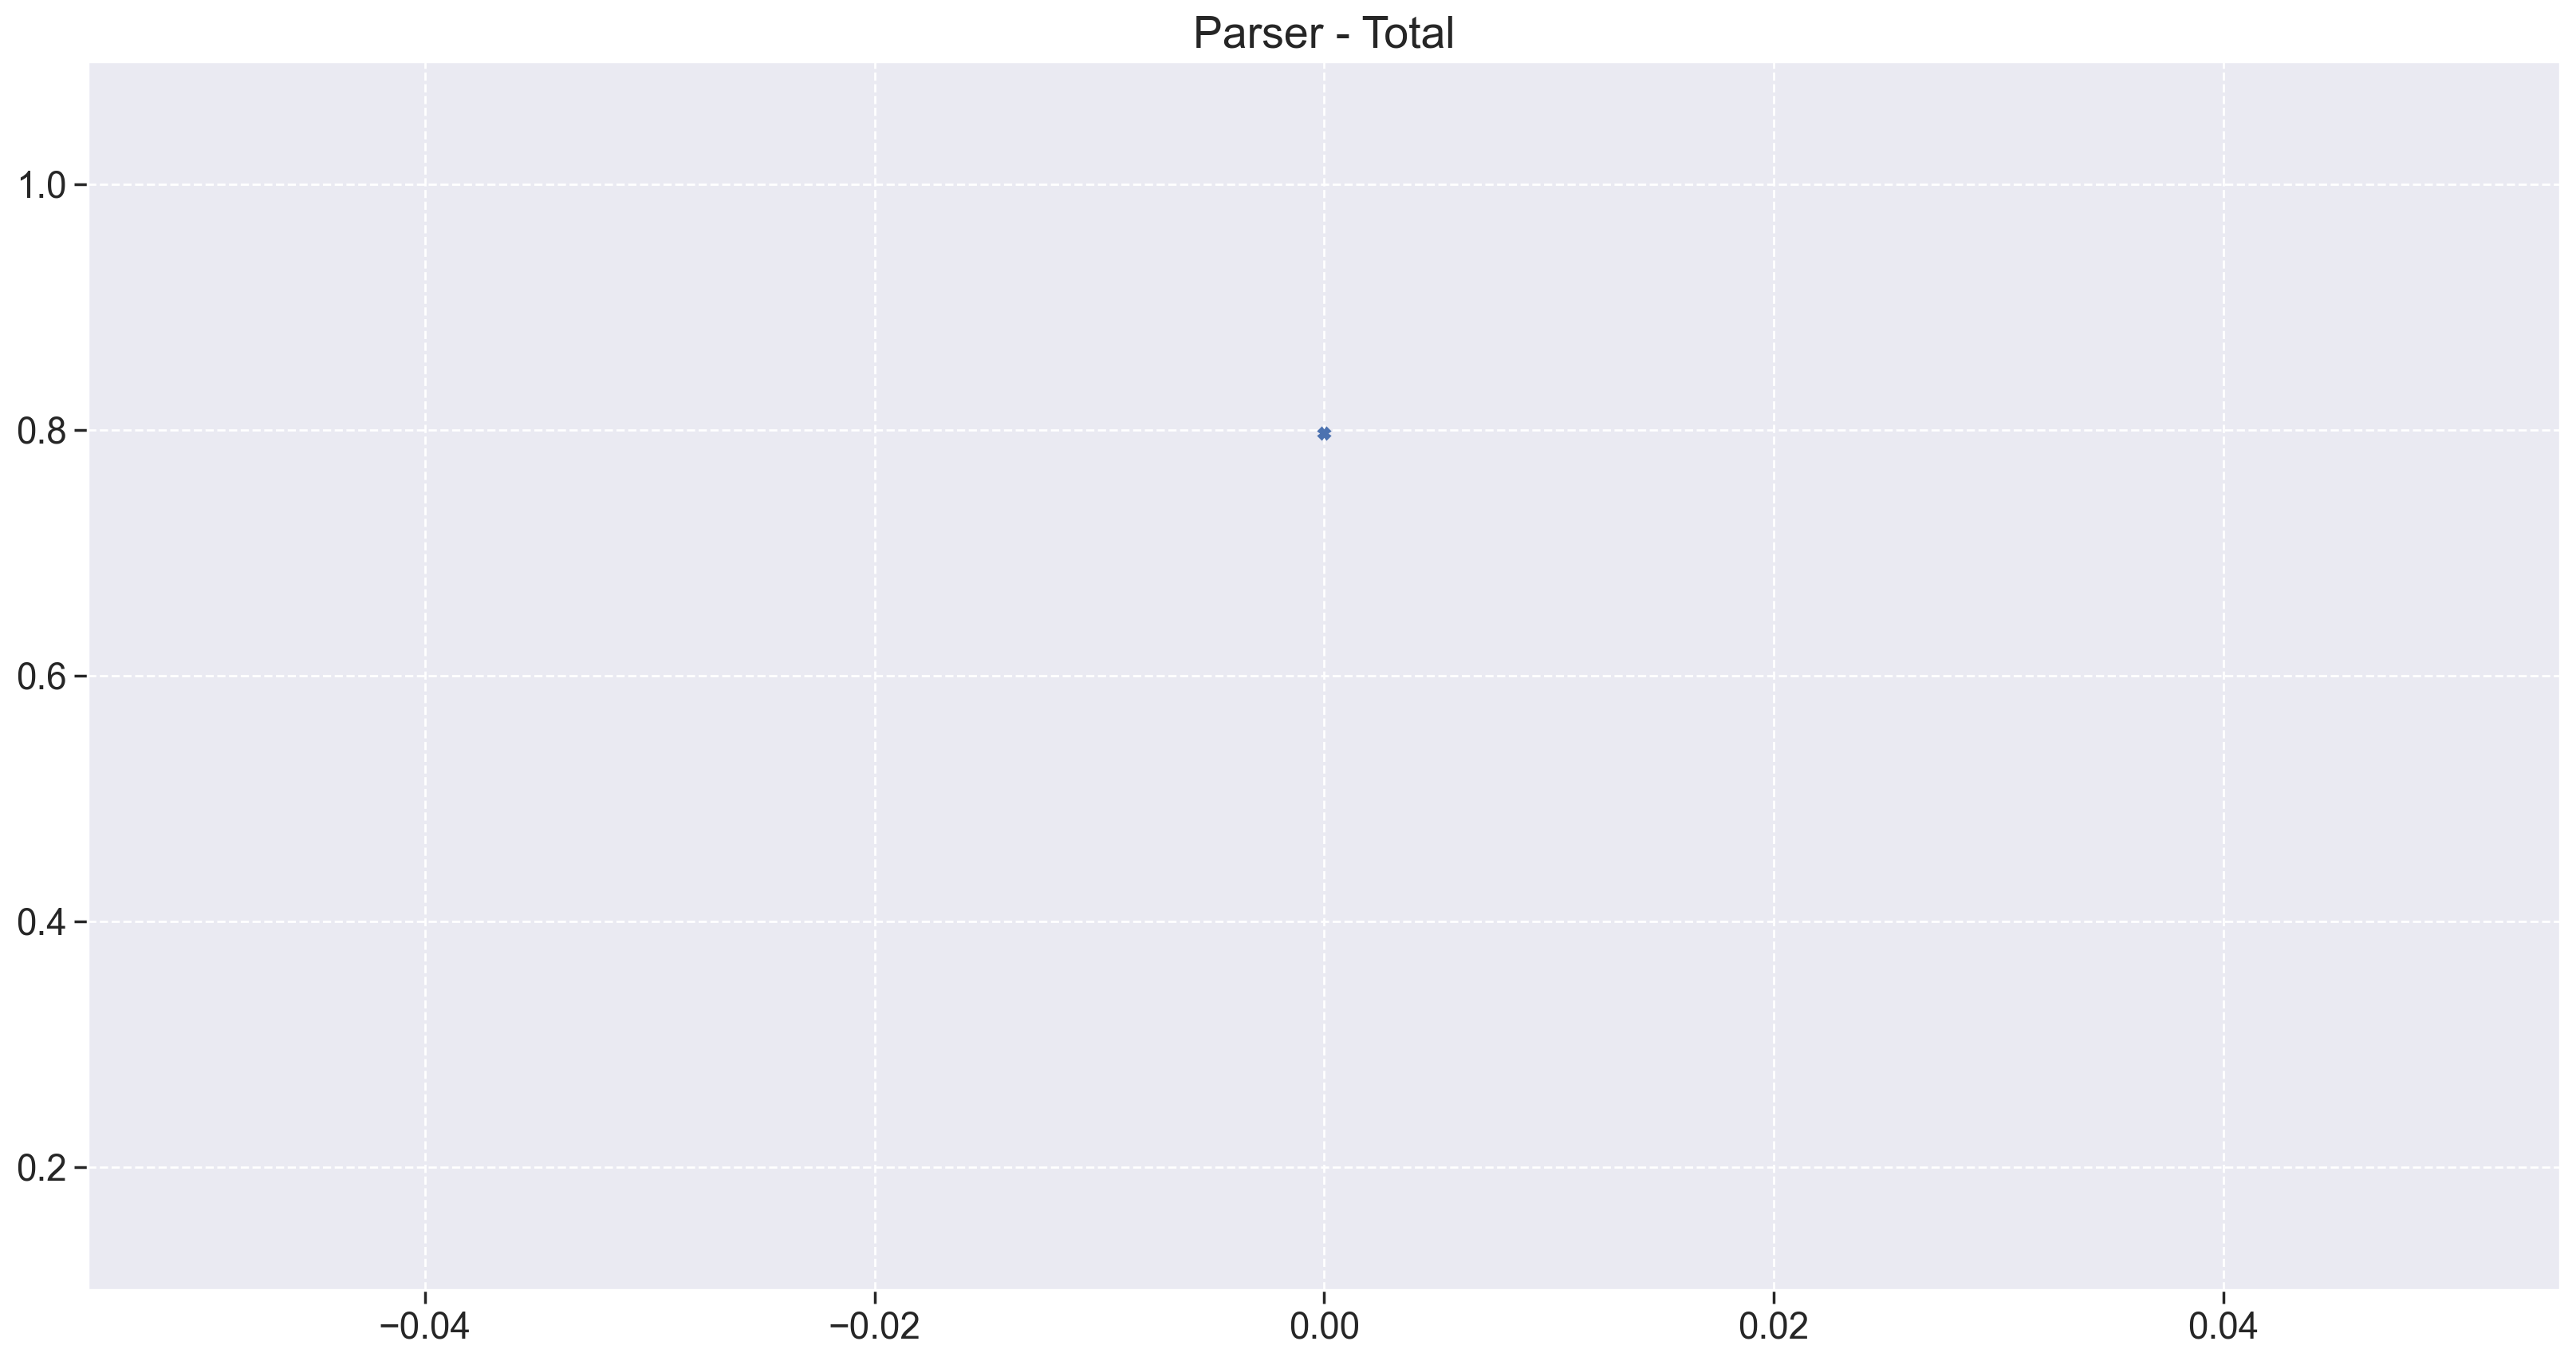

In [63]:
for name, data in metrics.items():
    print(name)
    analysis(data, name)

### Quality characteristic indicator

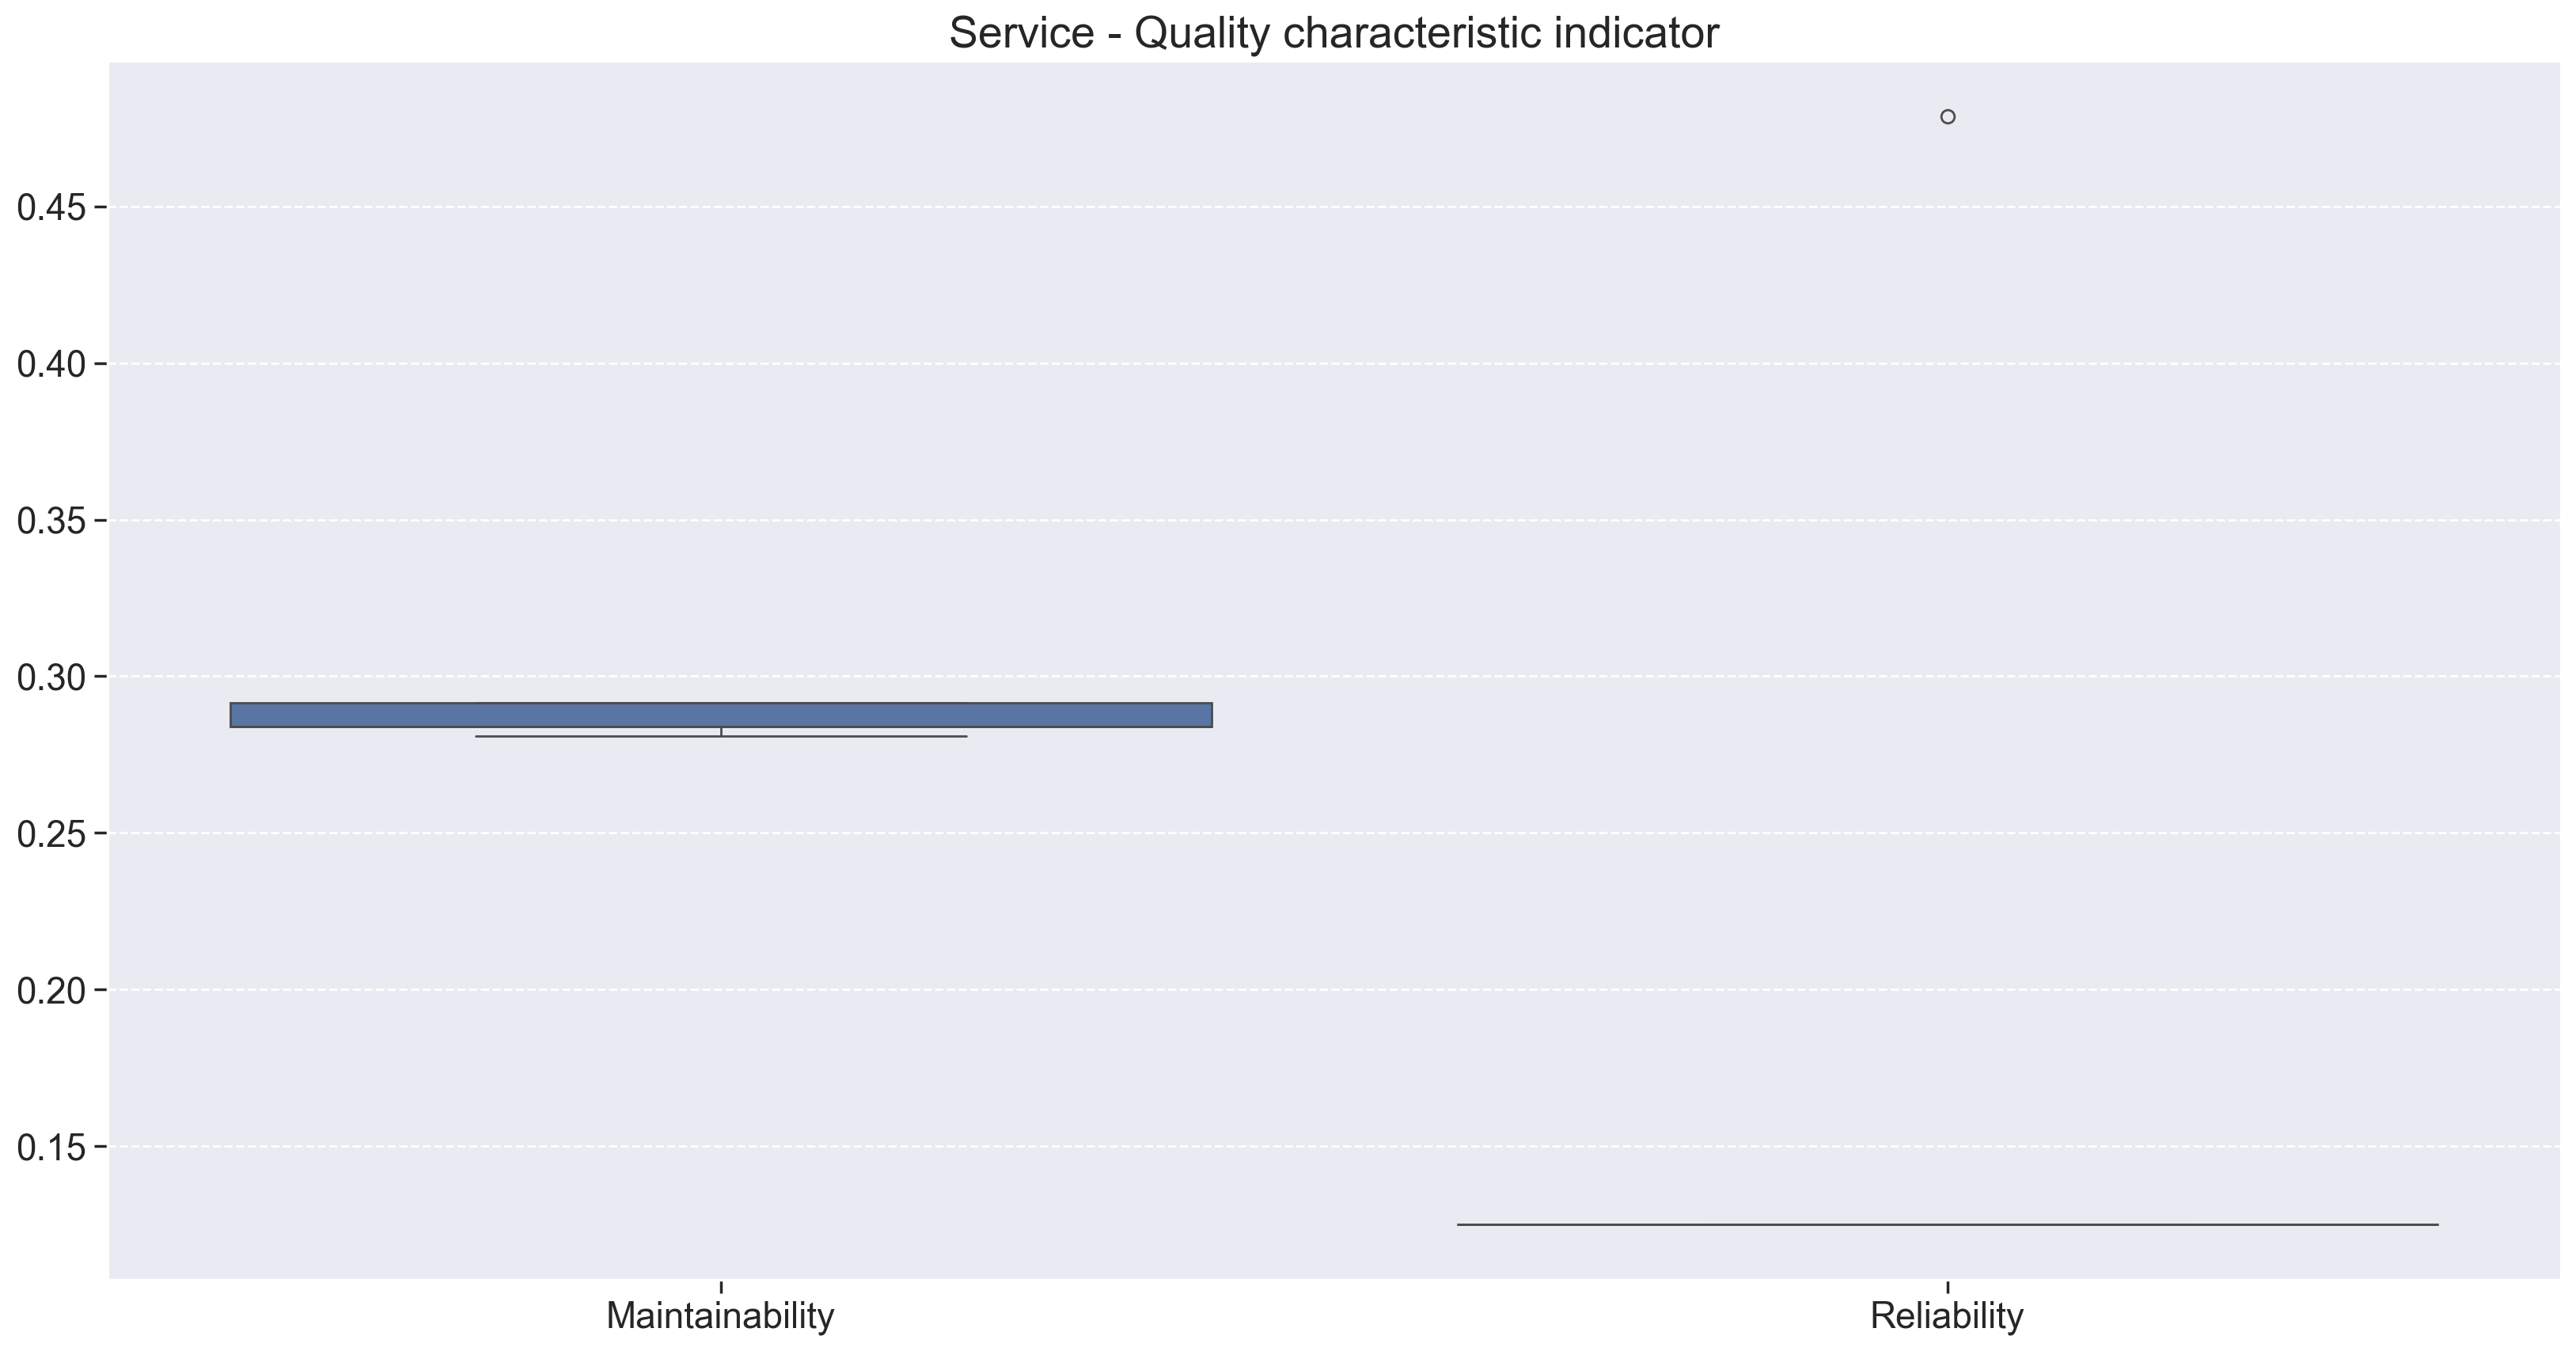

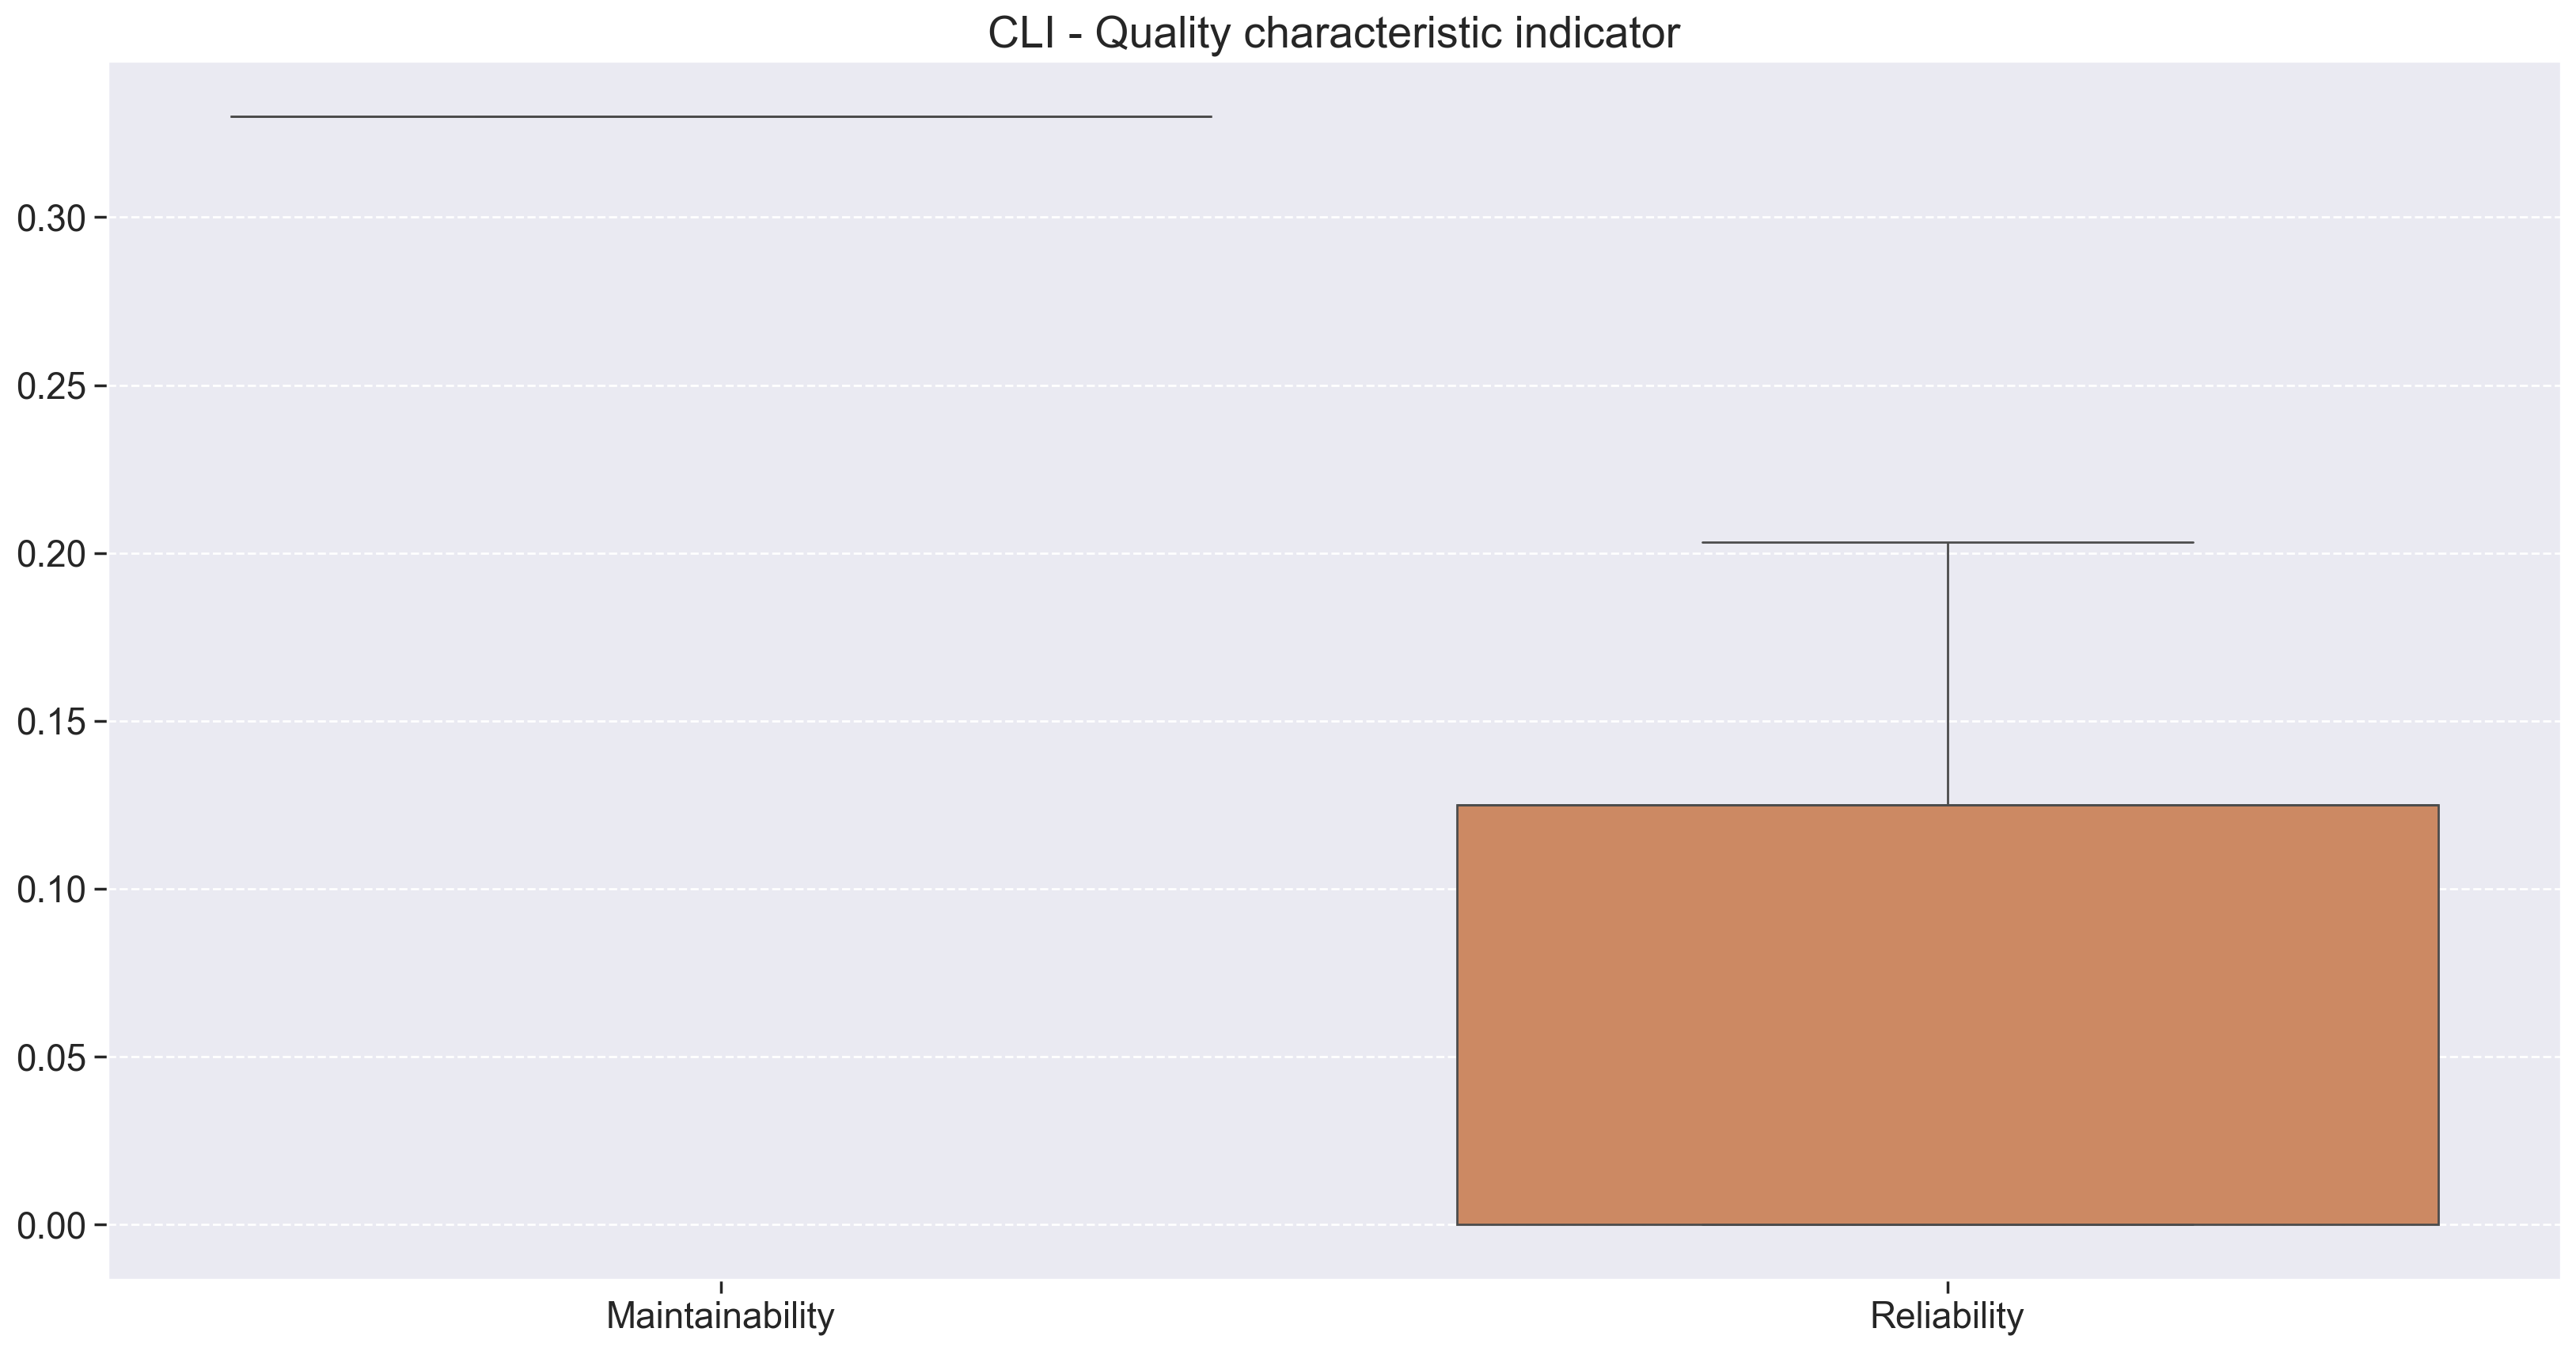

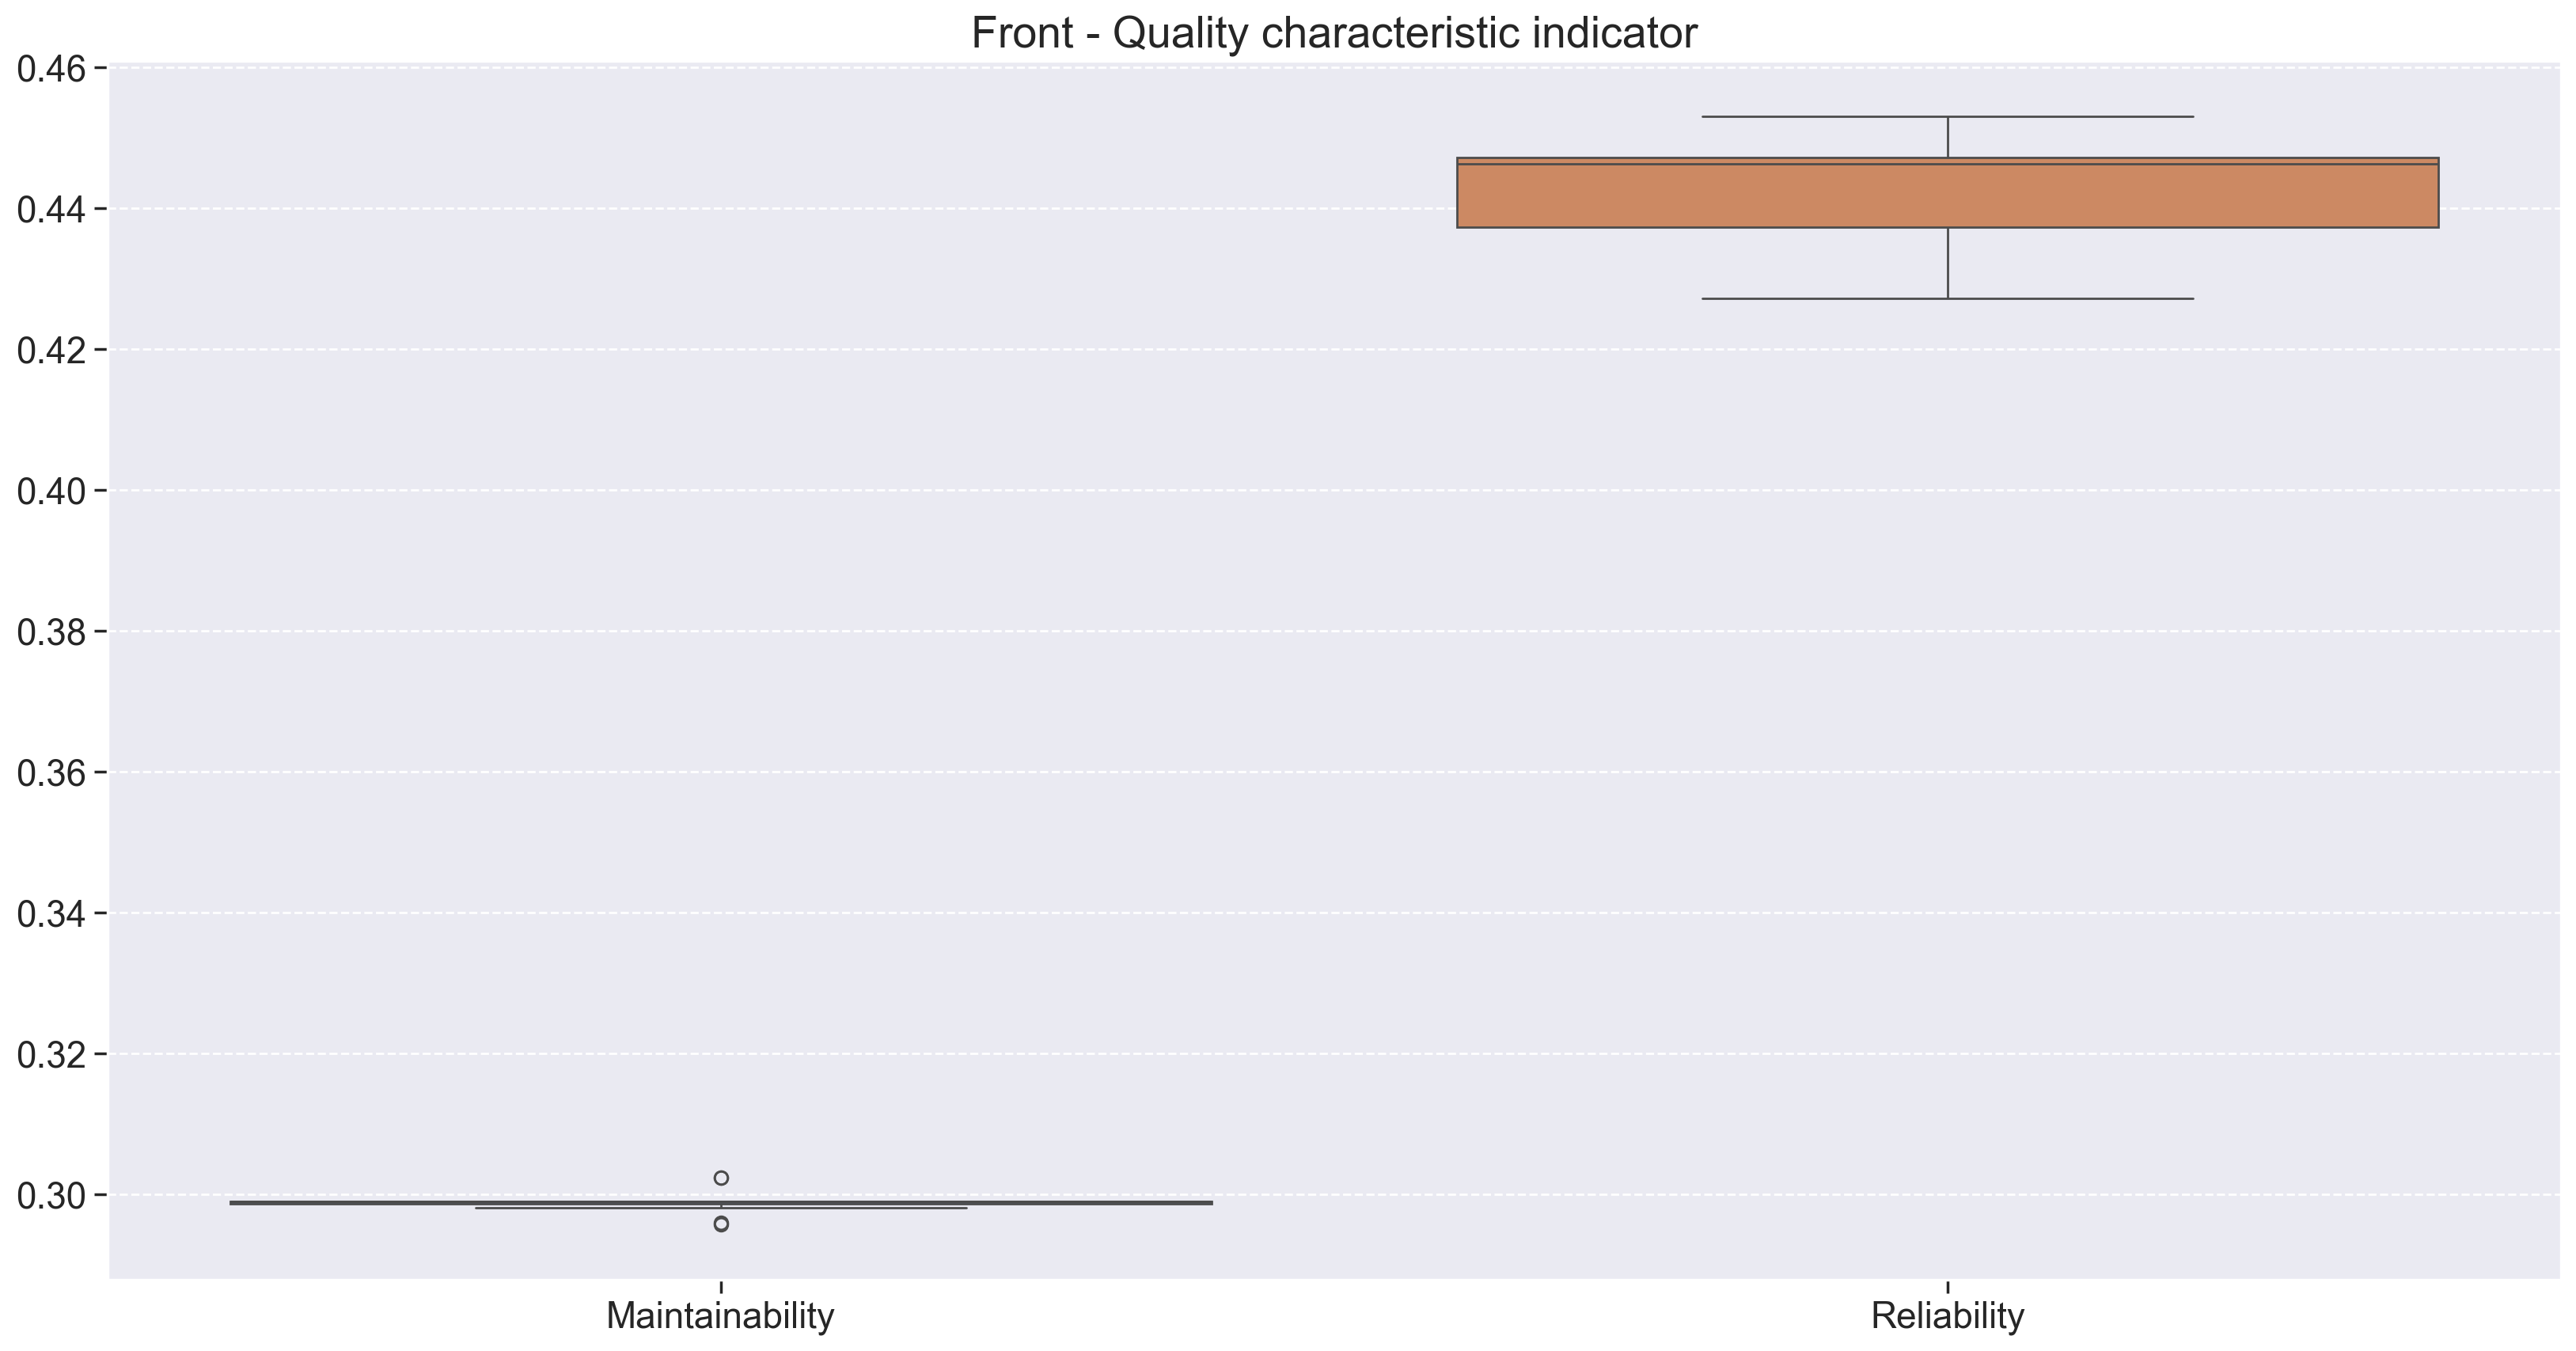

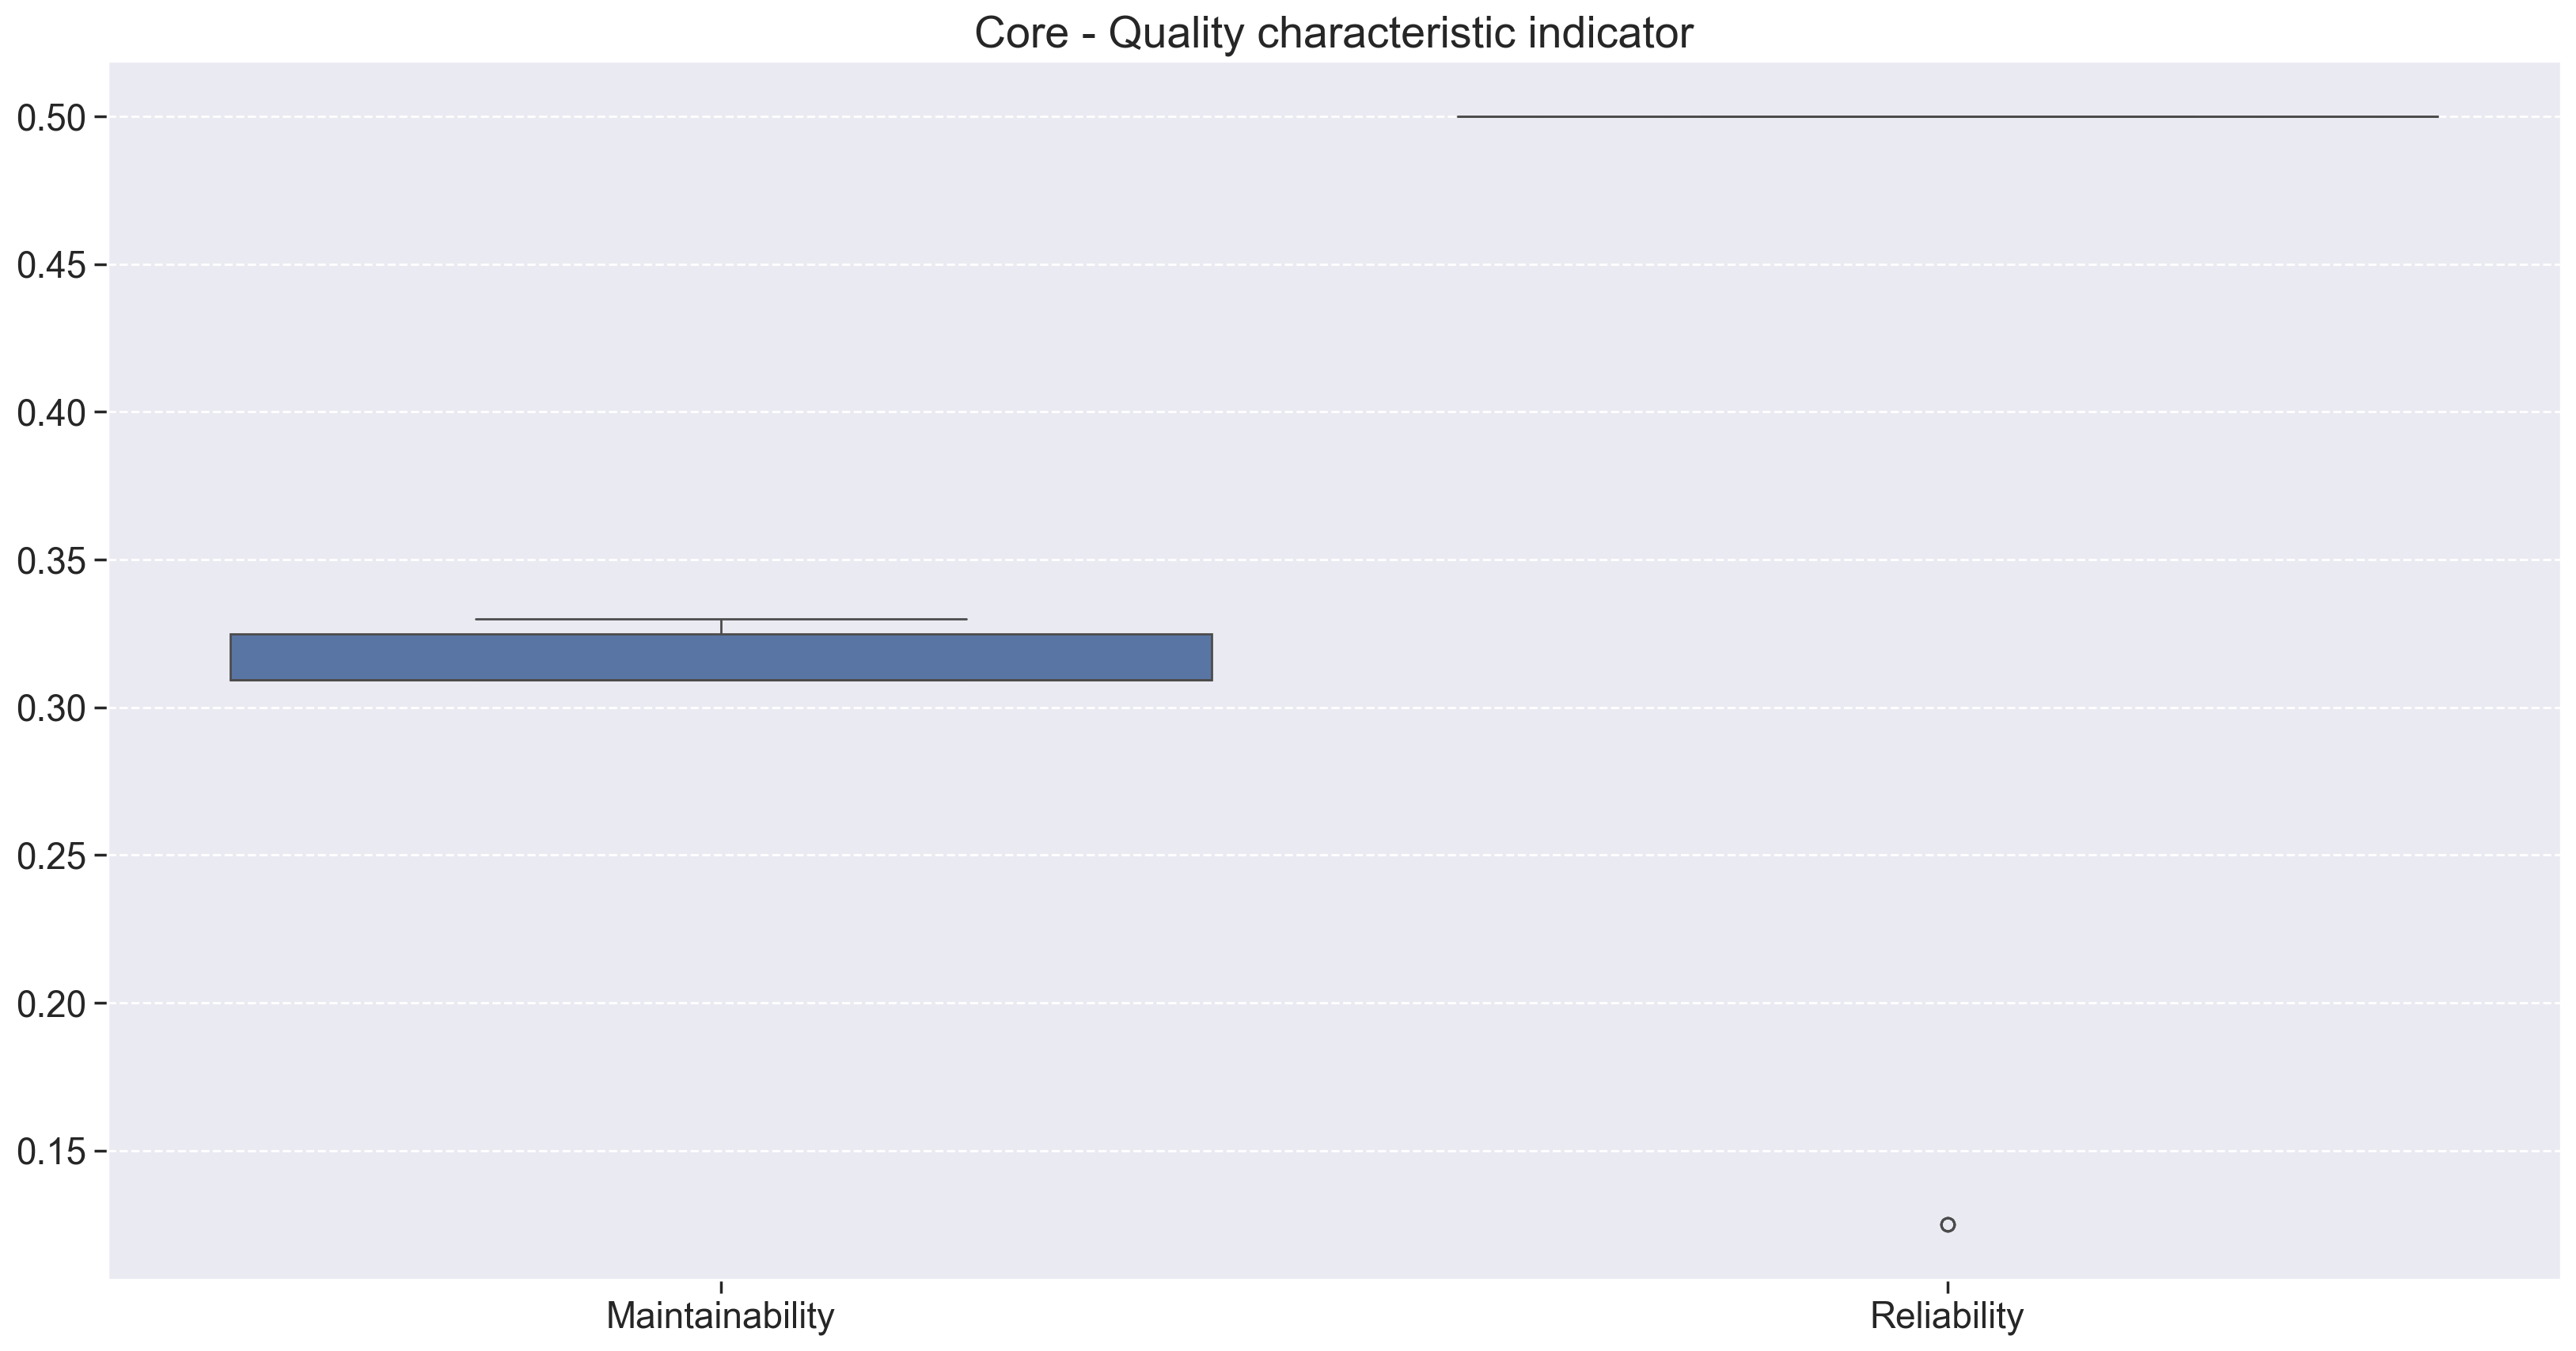

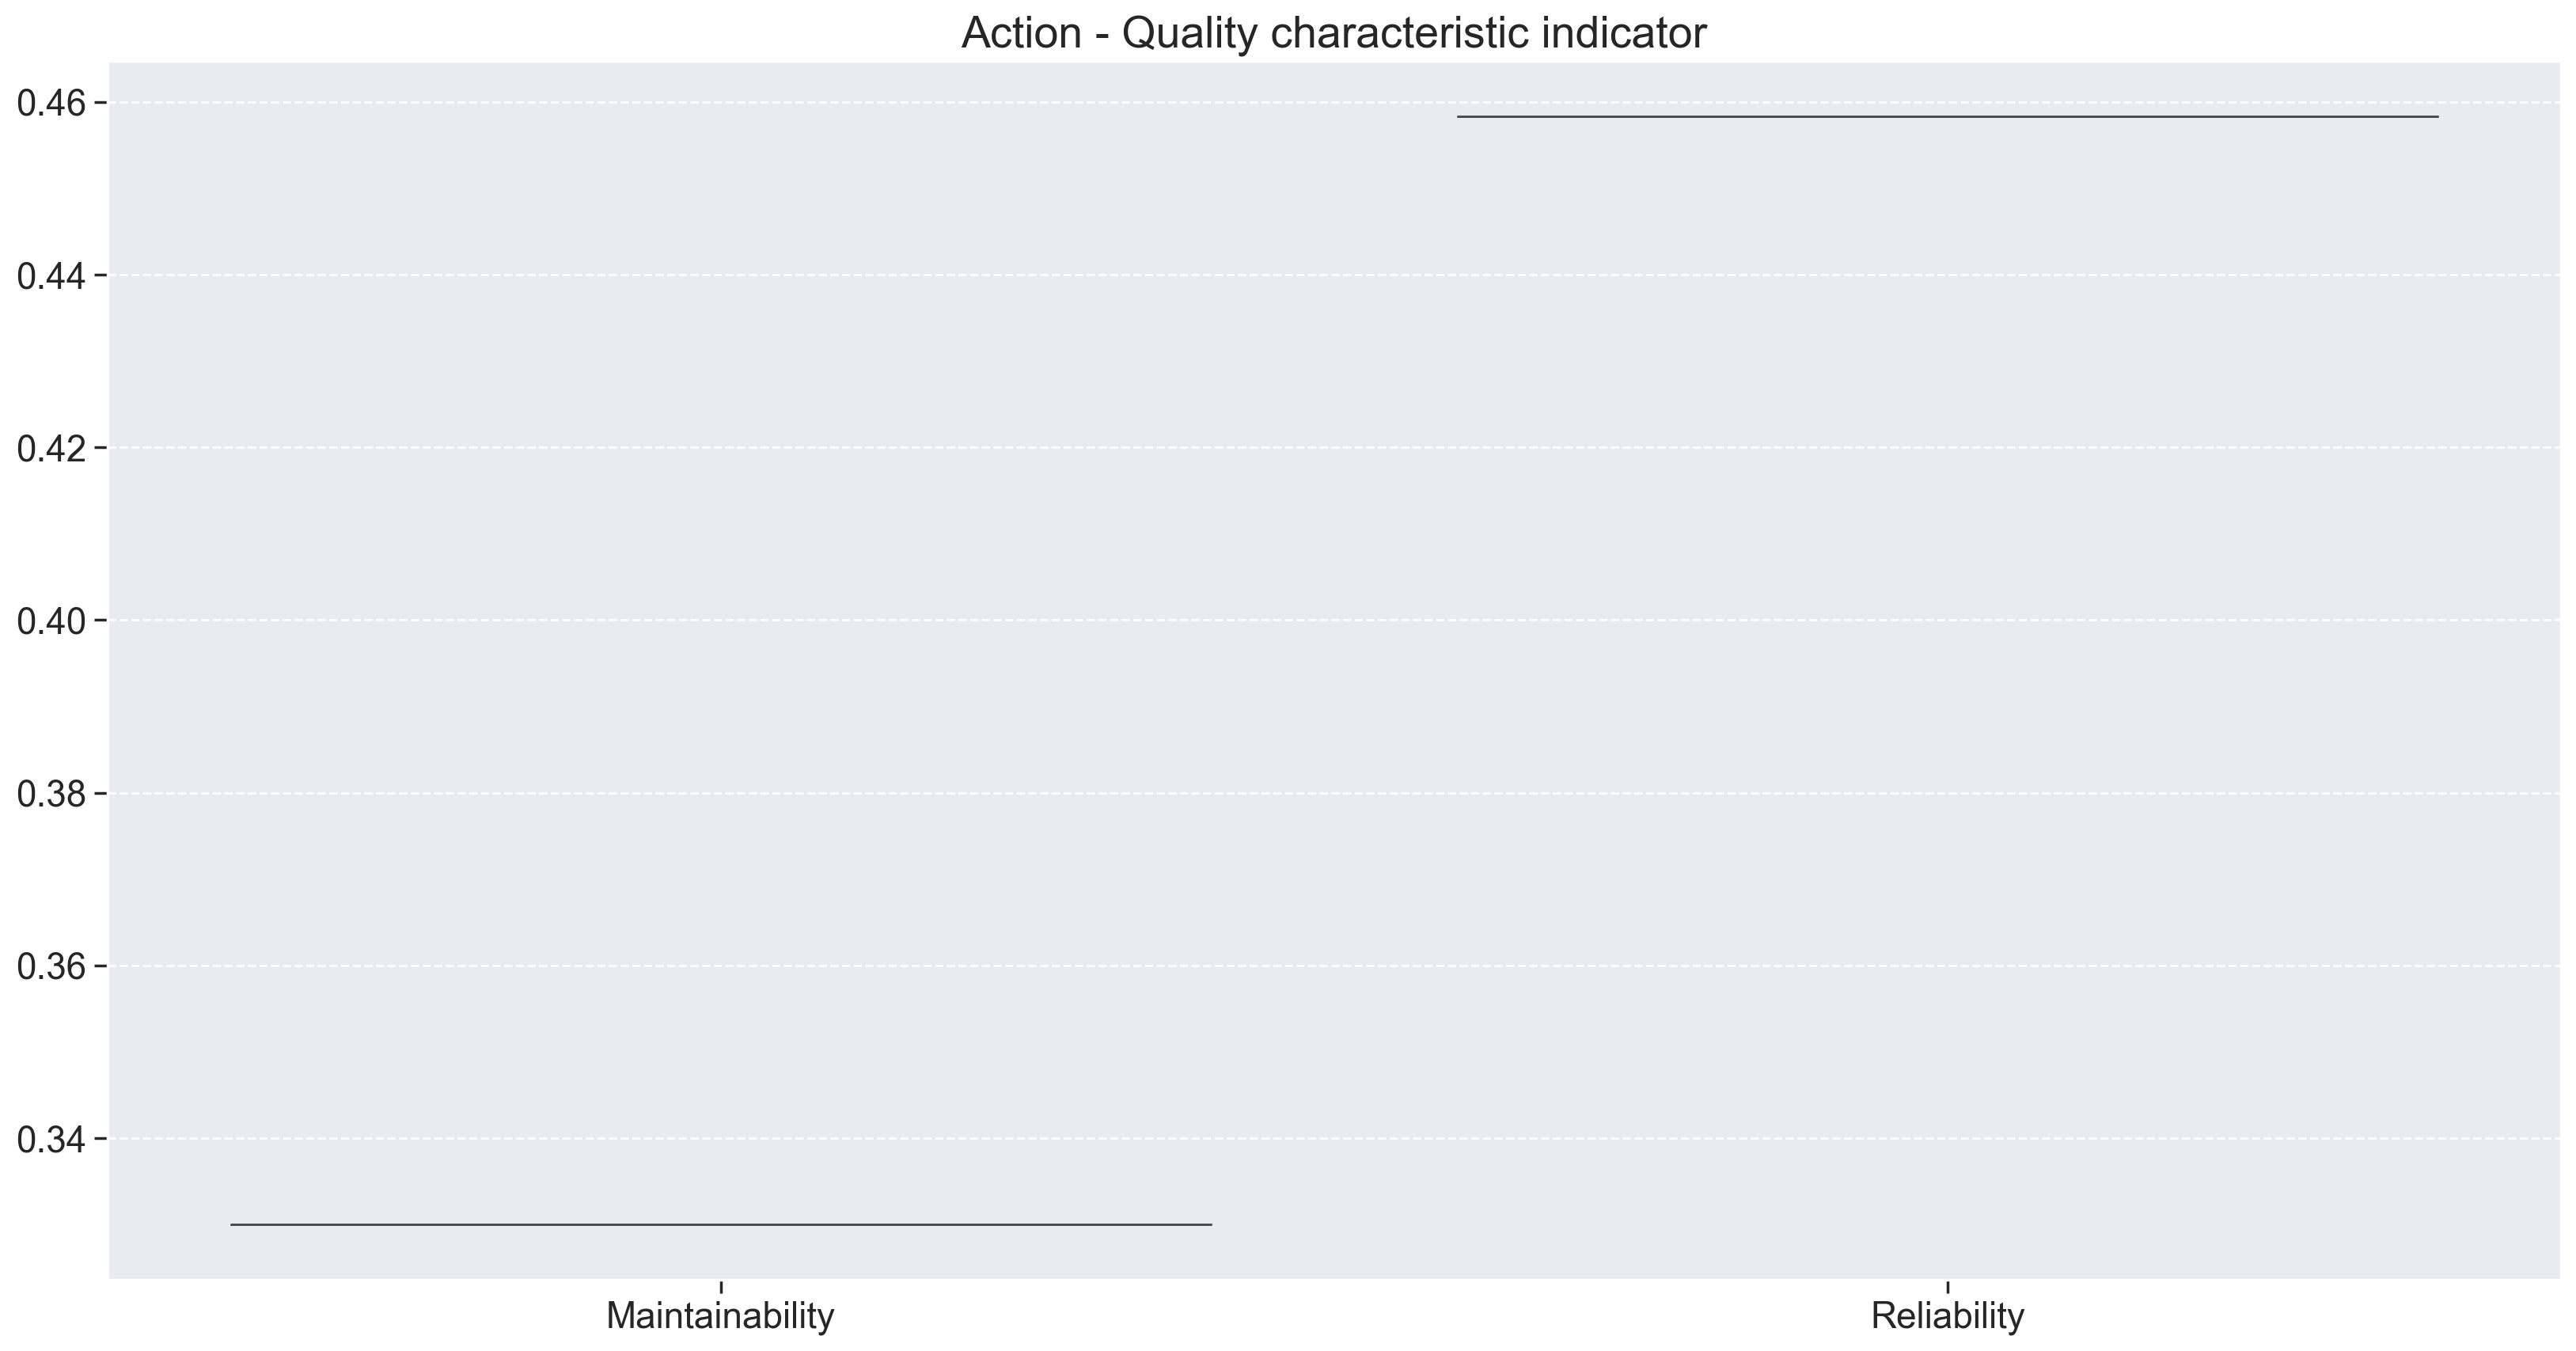

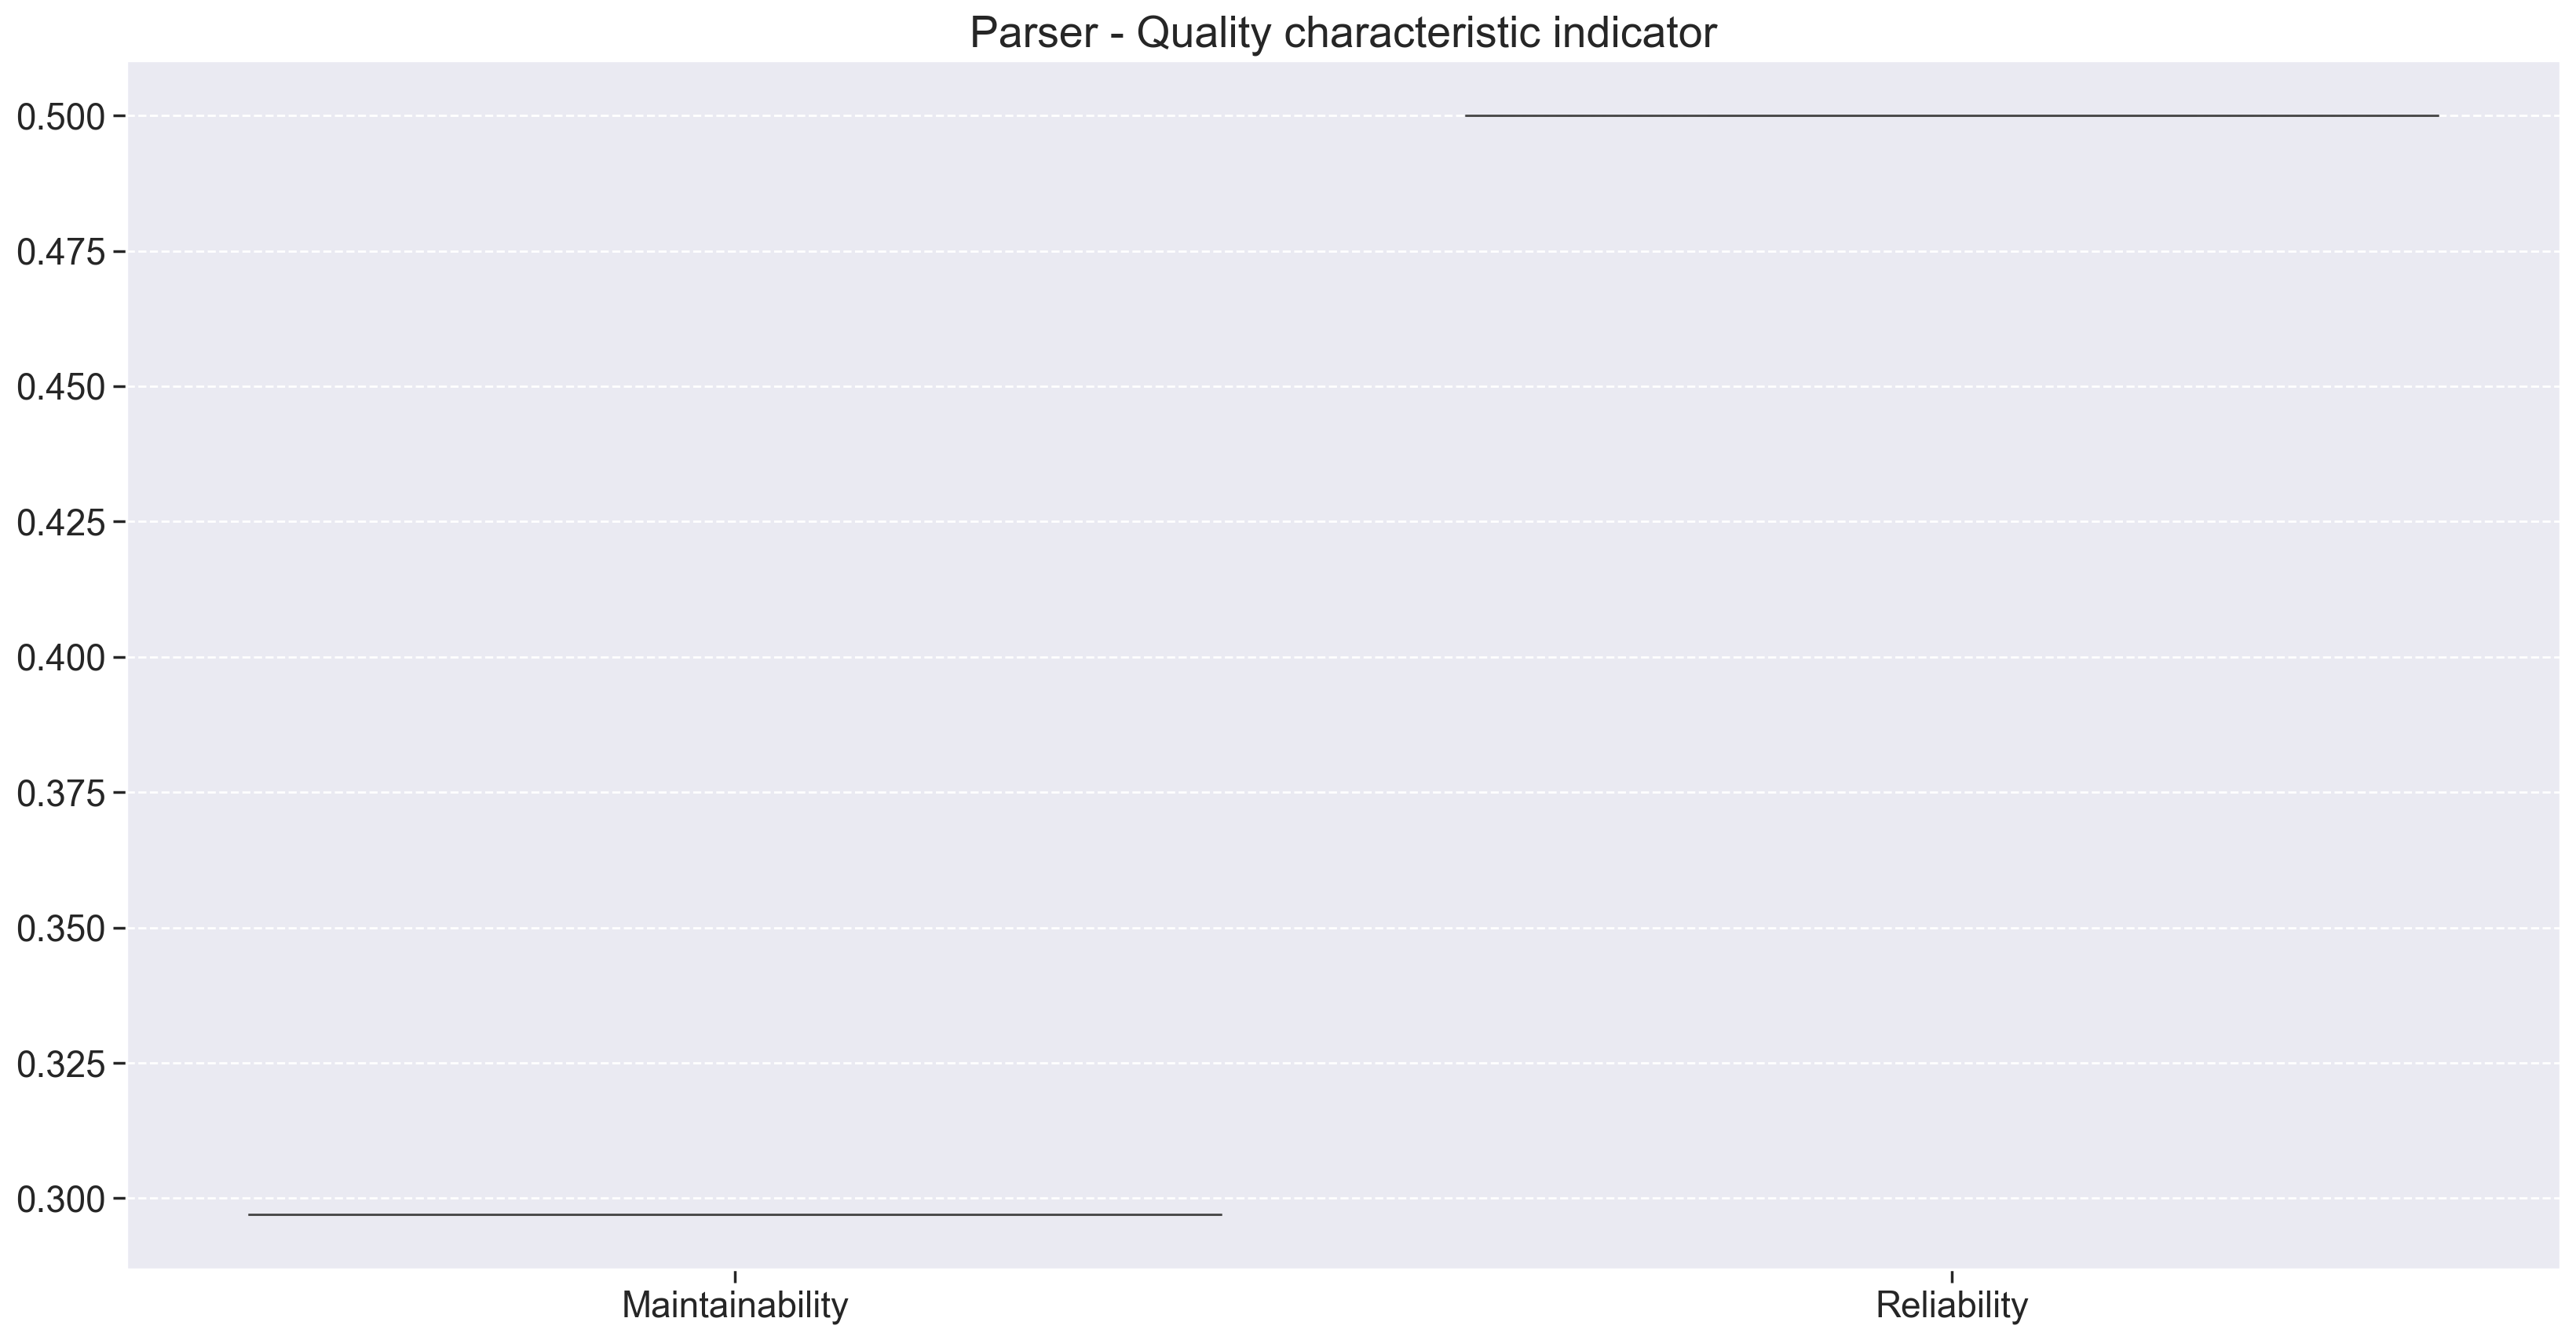

In [64]:

for name, data in metrics.items():
    fig = plt.figure(figsize=(20, 10))
    sns.boxplot(data=data[['Maintainability','Reliability']])

    plt.title(f"{name} - Quality characteristic indicator", fontsize=20)
    plt.show()

### Quality indicator visualization

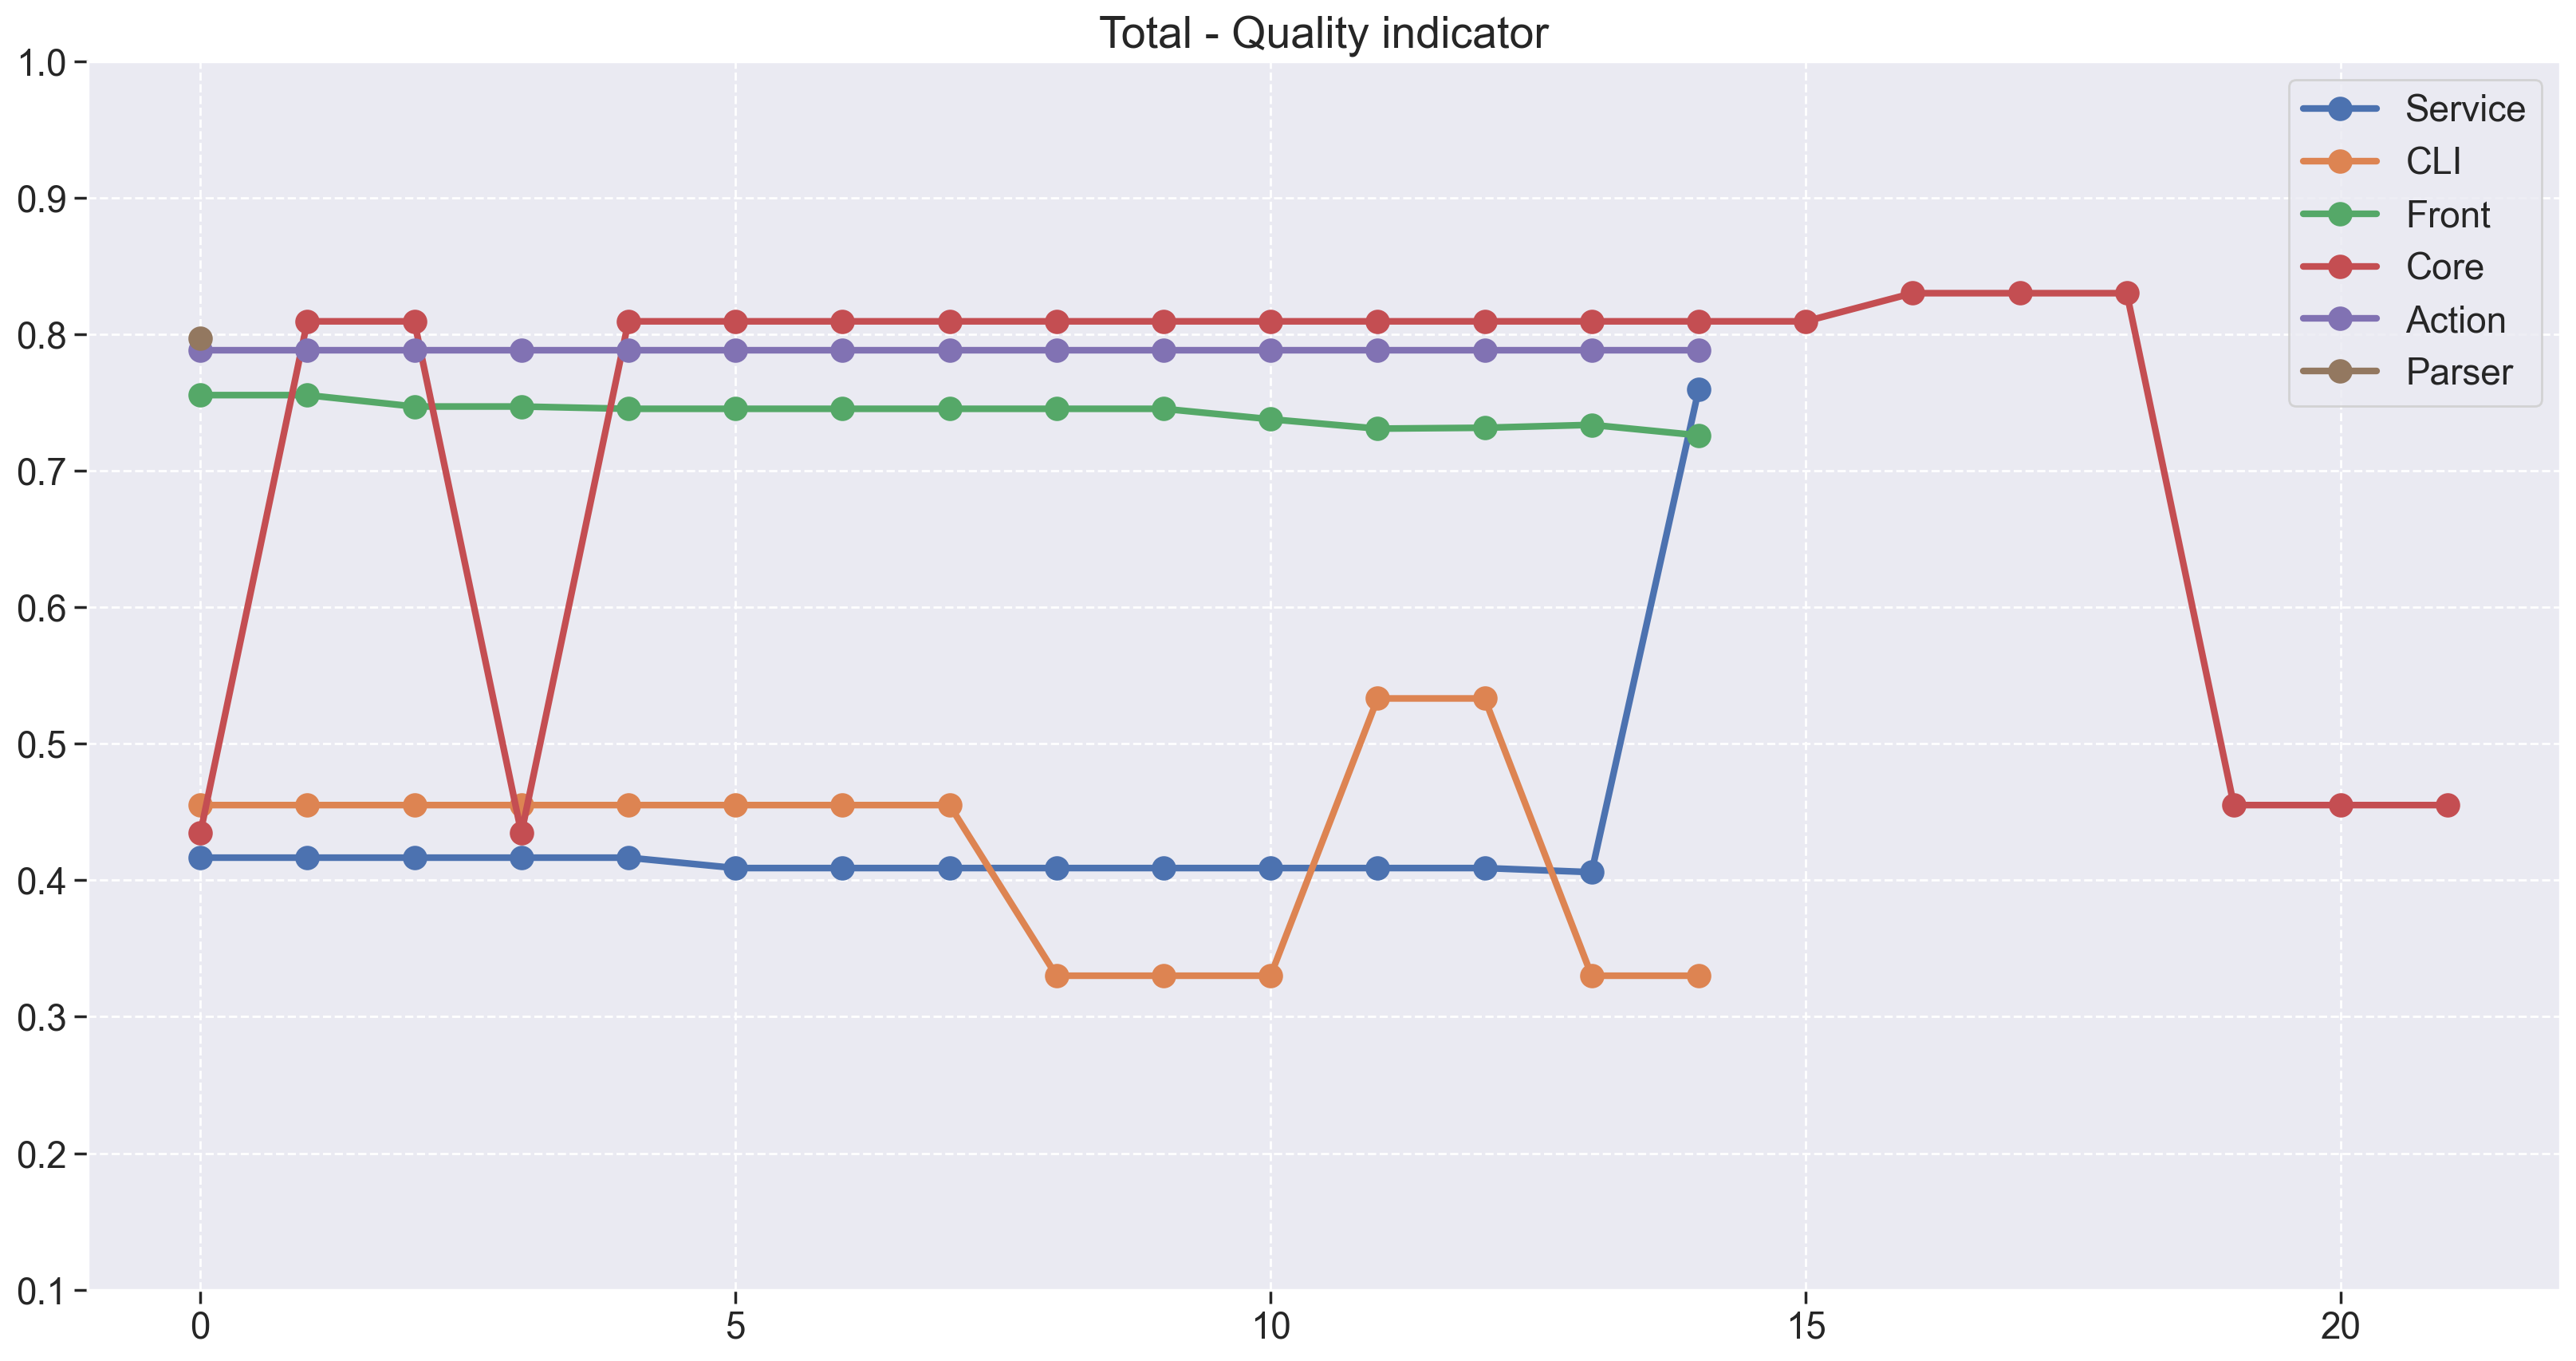

In [65]:
fig = plt.figure(figsize=(20, 10))

for name, data in metrics.items():
    plt.plot(data['total'], linewidth=3, marker='o', markersize=10, label=name)

plt.ylim(.1,1)
plt.title("Total - Quality indicator", fontsize=20)
plt.legend(loc='best')
plt.show()

## Export data

In [66]:
metrics_list = metrics.values()

metrics_df = pd.concat(metrics_list, ignore_index=True)

display(metrics_df)

current_datetime = datetime.datetime.now().strftime("%m-%d-%Y--%H-%M-%S")

metrics_df.to_excel('./data/fga-eps-mds-2023-2-MeasureSoftGram--{}.xlsx'.format(current_datetime), index = False)

metrics_df.to_csv('./data/fga-eps-mds-2023-2-MeasureSoftGram--{}.csv'.format(current_datetime), index = False)

m1        m2        m3   m4   m5        m6  \
0   0.522222  0.244444  1.000000  0.0  1.0  0.000000   
1   0.522222  0.244444  1.000000  0.0  1.0  0.000000   
2   0.522222  0.244444  1.000000  0.0  1.0  0.000000   
3   0.522222  0.244444  1.000000  0.0  1.0  0.000000   
4   0.522222  0.244444  1.000000  0.0  1.0  0.000000   
5   0.505376  0.215054  1.000000  0.0  1.0  0.000000   
6   0.505376  0.215054  1.000000  0.0  1.0  0.000000   
7   0.505376  0.215054  1.000000  0.0  1.0  0.000000   
8   0.505376  0.215054  1.000000  0.0  1.0  0.000000   
9   0.505376  0.215054  1.000000  0.0  1.0  0.000000   
10  0.505376  0.215054  1.000000  0.0  1.0  0.000000   
11  0.505376  0.215054  1.000000  0.0  1.0  0.000000   
12  0.505376  0.215054  1.000000  0.0  1.0  0.000000   
13  0.500000  0.202128  1.000000  0.0  1.0  0.000000   
14  0.500000  0.202128  1.000000  1.0  1.0  0.914894   
15  0.875000  0.125000  1.000000  0.0  1.0  0.000000   
16  0.875000  0.125000  1.000000  0.0  1.0  0.000000   
17  0.875000  0.125000  1.000000  0.0  1.0  0.000000   
18  0.875000  0.125000  1.000000  0.0  1.0  0.000000   
19  0.875000  0.125000  1.000000  0.0  1.0  0.000000   
20  0.875000  0.125000  1.000000  0.0  1.0  0.000000   
21  0.875000  0.125000  1.000000  0.0  1.0  0.000000   
22  0.875000  0.125000  1.000000  0.0  1.0  0.000000   
23  0.875000  0.125000  1.000000  0.0  0.0  0.000000   
24  0.875000  0.125000  1.000000  0.0  0.0  0.000000   
25  0.875000  0.125000  1.000000  0.0  0.0  0.000000   
26  0.875000  0.125000  1.000000  0.0  0.0  0.812500   
27  0.875000  0.125000  1.000000  0.0  0.0  0.812500   
28  0.875000  0.125000  1.000000  0.0  0.0  0.000000   
29  0.875000  0.125000  1.000000  0.0  0.0  0.000000   
30  0.825503  0.020134  0.986577  1.0  1.0  0.812081   
31  0.825503  0.020134  0.986577  1.0  1.0  0.812081   
32  0.825503  0.020134  0.966443  1.0  1.0  0.791946   
33  0.825503  0.020134  0.966443  1.0  1.0  0.791946   
34  0.825503  0.020134  0.966443  1.0  1.0  0.785235   
35  0.825503  0.020134  0.966443  1.0  1.0  0.785235   
36  0.825503  0.020134  0.966443  1.0  1.0  0.785235   
37  0.825503  0.020134  0.966443  1.0  1.0  0.785235   
38  0.825503  0.020134  0.966443  1.0  1.0  0.785235   
39  0.825503  0.020134  0.966443  1.0  1.0  0.785235   
40  0.828947  0.019737  0.960526  1.0  1.0  0.756579   
41  0.831169  0.019481  0.941558  1.0  1.0  0.740260   
42  0.832258  0.019355  0.941935  1.0  1.0  0.741935   
43  0.832258  0.019355  0.954839  1.0  1.0  0.741935   
44  0.835443  0.031646  0.943038  1.0  1.0  0.708861   
45  0.625000  0.250000  1.000000  0.0  1.0  0.000000   
46  0.625000  0.250000  1.000000  1.0  1.0  1.000000   
47  0.625000  0.250000  1.000000  1.0  1.0  1.000000   
48  0.625000  0.250000  1.000000  0.0  1.0  0.000000   
49  0.625000  0.250000  1.000000  1.0  1.0  1.000000   
50  0.625000  0.250000  1.000000  1.0  1.0  1.000000   
51  0.625000  0.250000  1.000000  1.0  1.0  1.000000   
52  0.625000  0.250000  1.000000  1.0  1.0  1.000000   
53  0.625000  0.250000  1.000000  1.0  1.0  1.000000   
54  0.625000  0.250000  1.000000  1.0  1.0  1.000000   
55  0.625000  0.250000  1.000000  1.0  1.0  1.000000   
56  0.625000  0.250000  1.000000  1.0  1.0  1.000000   
57  0.625000  0.250000  1.000000  1.0  1.0  1.000000   
58  0.625000  0.250000  1.000000  1.0  1.0  1.000000   
59  0.625000  0.250000  1.000000  1.0  1.0  1.000000   
60  0.625000  0.250000  1.000000  1.0  1.0  1.000000   
61  0.750000  0.250000  1.000000  1.0  1.0  1.000000   
62  0.750000  0.250000  1.000000  1.0  1.0  1.000000   
63  0.750000  0.250000  1.000000  1.0  1.0  1.000000   
64  0.750000  0.250000  1.000000  0.0  1.0  0.000000   
65  0.750000  0.250000  1.000000  0.0  1.0  0.000000   
66  0.750000  0.250000  1.000000  0.0  1.0  0.000000   
67  1.000000  0.000000  1.000000  1.0  1.0  0.833333   
68  1.000000  0.000000  1.000000  1.0  1.0  0.833333   
69  1.000000  0.000000  1.000000  1.0  1.0  0.833333   
70  1.000000  0.000000  1.000000  